In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# Define the input shape based on your CWT images
input_shape = (224, 224, 3)

# Using a pre-trained ResNet50 model as an example
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Adjusted for 4 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24,113,284
Trainable params: 525,572
Non-trainable params: 23,587,712
______________________________________

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Library for wavelet transforms
from scipy.io import loadmat
from scipy.signal import resample
import os

# List of dataset filenames corresponding to different classes
dataset_filenames = ['a0.mat', 'a1.mat', 'a2.mat', 'a3.mat', 'a4.mat', 'a5.mat']

# Set parameters
sampling_frequency = 100  # Sampling frequency in Hz

# Directory to save CWT images
output_dir = 'CWT_images'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each dataset
for dataset_filename in dataset_filenames:
    # Load EEG data from the MATLAB file
    mat_data = loadmat(dataset_filename)
    
    # Iterate over all variables in the .mat file
    for var_name in mat_data:
        if var_name.startswith('__'):  # Skip meta entries like '__header__', '__version__', '__globals__'
            continue
        
        eeg_data = mat_data[var_name]  # Access the data using the variable name

        # Check if the variable is numeric and has more than one dimension (i.e., it's a signal)
        if isinstance(eeg_data, np.ndarray) and eeg_data.ndim > 0:
            # Convert the data to a NumPy array and flatten it
            signal = eeg_data.astype(float).flatten()

            # Resample signal if necessary (for uniformity)
            signal = resample(signal, len(signal))

            # Compute Continuous Wavelet Transform (CWT)
            scales = np.arange(1, 128)  # Example range of scales
            coefficients, frequencies = pywt.cwt(signal, scales, 'morl', sampling_period=1/sampling_frequency)

            # Plot CWT scalogram
            plt.figure(figsize=(12, 8))
            plt.imshow(np.abs(coefficients), extent=[0, len(signal), frequencies[-1], frequencies[0]],
                       aspect='auto', cmap='jet')
            
            # Remove labels and title
            plt.axis('off')  # Hide the axis
            
            # Save the CWT scalogram image
            output_image_name = f'{dataset_filename[:-4]}_{var_name}_CWT.png'
            plt.savefig(os.path.join(output_dir, output_image_name), bbox_inches='tight', pad_inches=0)
            plt.close()  # Close the plot to save memory

print(f"CWT images saved in the '{output_dir}' directory.")


CWT images saved in the 'CWT_images' directory.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Library for wavelet transforms
from scipy.io import loadmat
from scipy.signal import resample
import os

# List of dataset filenames corresponding to different classes
dataset_filenames = ['a0.mat', 'a1.mat', 'a2.mat', 'a3.mat', 'a4.mat', 'a5.mat']

# Set parameters
sampling_frequency = 100  # Sampling frequency in Hz
imbalance_ratios = [2, 10, 20, 50, 100]  # Imbalance ratios ρ
mu_values = [2, 5, 8]  # Values for step imbalance

# Directory to save CWT images
output_dir = 'CWT_images'
os.makedirs(output_dir, exist_ok=True)

# Function to create step imbalance
def create_step_imbalance(signal, max_samples, ratio):
    min_samples = max_samples // ratio
    return signal[:min_samples]

# Function to create linear imbalance
def create_linear_imbalance(signal, max_samples, class_index, num_classes, ratio):
    samples = max_samples * (ratio ** (class_index / (num_classes - 1.0)))
    return signal[:int(samples)]

# Iterate over each dataset
for dataset_filename in dataset_filenames:
    # Load EEG data from the MATLAB file
    mat_data = loadmat(dataset_filename)
    eeg_data = mat_data[f'{dataset_filename[:-4]}0001']  # Assuming variable names follow a pattern

    # Convert the data to a NumPy array and flatten it
    signal = eeg_data.astype(float).flatten()

    # Resample signal if necessary (for uniformity)
    signal = resample(signal, len(signal))

    max_samples = len(signal)  # Maximum number of samples in the class

    # Apply step and linear imbalance
    for ratio in imbalance_ratios:
        for mu in mu_values:
            # Step imbalance
            step_imbalanced_signal = create_step_imbalance(signal, max_samples, ratio)
            scales = np.arange(1, 128)  # Example range of scales
            coefficients, frequencies = pywt.cwt(step_imbalanced_signal, scales, 'morl', sampling_period=1/sampling_frequency)

            plt.figure(figsize=(12, 8))
            plt.imshow(np.abs(coefficients), extent=[0, len(step_imbalanced_signal), frequencies[-1], frequencies[0]],
                       aspect='auto', cmap='jet')
            plt.axis('off')  # Hide the axis
            output_image_name = f'{dataset_filename[:-4]}_step_imbalance_ρ{ratio}_μ{mu}_CWT.png'
            plt.savefig(os.path.join(output_dir, output_image_name), bbox_inches='tight', pad_inches=0)
            plt.close()

        # Linear imbalance
        for i, _ in enumerate(dataset_filenames):
            linear_imbalanced_signal = create_linear_imbalance(signal, max_samples, i, len(dataset_filenames), ratio)
            scales = np.arange(1, 128)  # Example range of scales
            coefficients, frequencies = pywt.cwt(linear_imbalanced_signal, scales, 'morl', sampling_period=1/sampling_frequency)

            plt.figure(figsize=(12, 8))
            plt.imshow(np.abs(coefficients), extent=[0, len(linear_imbalanced_signal), frequencies[-1], frequencies[0]],
                       aspect='auto', cmap='jet')
            plt.axis('off')  # Hide the axis
            output_image_name = f'{dataset_filename[:-4]}_linear_imbalance_ρ{ratio}_class{i}_CWT.png'
            plt.savefig(os.path.join(output_dir, output_image_name), bbox_inches='tight', pad_inches=0)
            plt.close()

print(f"CWT images for imbalanced datasets saved in the '{output_dir}' directory.")


CWT images for imbalanced datasets saved in the 'CWT_images' directory.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Directory containing the CWT images
output_dir = 'CWT_images'
imbalanced_dir = 'Imbalanced_CWT_images'
os.makedirs(imbalanced_dir, exist_ok=True)

# Imbalance settings
imbalance_ratios = [2, 10, 20, 50, 100]  # Imbalance ratios ρ
mu_values = [2, 5, 8]  # Values for step imbalance

# Load CWT images
cwt_images = [img for img in os.listdir(output_dir) if img.endswith('.png')]

def load_image(filepath):
    return Image.open(filepath)

def save_image(image, filepath):
    image.save(filepath)

# Function to simulate step imbalance
def create_step_imbalance(images, max_samples, ratio):
    min_samples = max_samples // ratio
    return images[:min_samples]

# Function to simulate linear imbalance
def create_linear_imbalance(images, max_samples, class_index, num_classes, ratio):
    samples = int(max_samples * (ratio ** (class_index / (num_classes - 1.0))))
    return images[:samples]

# Iterate over imbalance ratios and apply to CWT images
for ratio in imbalance_ratios:
    for mu in mu_values:
        for idx, image_file in enumerate(cwt_images):
            class_images = [img for img in cwt_images if f'class_{idx}' in img]  # Select images of the same class
            max_samples = len(class_images)  # Maximum number of samples in the class

            # Step imbalance
            step_imbalanced_images = create_step_imbalance(class_images, max_samples, ratio)
            for img_name in step_imbalanced_images:
                img = load_image(os.path.join(output_dir, img_name))
                output_name = f'step_imbalance_ρ{ratio}_μ{mu}_{img_name}'
                save_image(img, os.path.join(imbalanced_dir, output_name))

            # Linear imbalance
            linear_imbalanced_images = create_linear_imbalance(class_images, max_samples, idx, len(cwt_images), ratio)
            for img_name in linear_imbalanced_images:
                img = load_image(os.path.join(output_dir, img_name))
                output_name = f'linear_imbalance_ρ{ratio}_class{idx}_{img_name}'
                save_image(img, os.path.join(imbalanced_dir, output_name))

print(f"Imbalanced CWT images saved in the '{imbalanced_dir}' directory.")


Imbalanced CWT images saved in the 'Imbalanced_CWT_images' directory.


In [6]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Directory containing the imbalanced CWT images
imbalanced_dir = 'Imbalanced_CWT_images'

# Function to plot examples of imbalanced settings
def plot_imbalanced_examples(ratio, mu):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    axs = axs.flatten()

    for idx, ax in enumerate(axs):
        img_name = f'step_imbalance_ρ{ratio}_μ{mu}_class_{idx}_CWT.png'
        img_path = os.path.join(imbalanced_dir, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Class {idx}')
        else:
            ax.set_visible(False)

    plt.suptitle(f'Examples of Step Imbalance ρ={ratio}, μ={mu}', fontsize=16)
    plt.show()

# Plot examples for a specific imbalance ratio and μ value
plot_imbalanced_examples(ratio=10, mu=5)


In [5]:
import numpy as np
import os
from PIL import Image

# Directory containing the CWT images
output_dir = 'CWT_images'
imbalanced_dir = 'Imbalanced_CWT_images'
os.makedirs(imbalanced_dir, exist_ok=True)

# Imbalance settings
imbalance_ratios = [2, 10, 20, 50, 100]  # Imbalance ratios ρ
mu_values = [2, 5, 8]  # Values for step imbalance

# Load CWT images
cwt_images = [img for img in os.listdir(output_dir) if img.endswith('.png')]

def load_image(filepath):
    return Image.open(filepath)

def save_image(image, filepath):
    image.save(filepath)

# Function to simulate step imbalance
def create_step_imbalance(images, max_samples, ratio):
    min_samples = max_samples // ratio
    return images[:min_samples]

# Function to simulate linear imbalance
def create_linear_imbalance(images, max_samples, class_index, num_classes, ratio):
    samples = int(max_samples * (ratio ** (class_index / (num_classes - 1.0))))
    return images[:samples]

# Debugging: Print loaded images
print(f"Total CWT images found: {len(cwt_images)}")
print(f"First 5 images: {cwt_images[:5]}")

# Check for each class and apply imbalance
for ratio in imbalance_ratios:
    for mu in mu_values:
        for idx in range(len(cwt_images)):
            # Debugging: Show current process details
            print(f"Processing class {idx} with ratio {ratio} and μ {mu}")
            
            # Select images corresponding to the current class
            class_images = [img for img in cwt_images if f'class_{idx}' in img]  
            
            if len(class_images) == 0:
                print(f"No images found for class {idx}. Skipping.")
                continue
            
            max_samples = len(class_images)  # Maximum number of samples in the class
            
            # Debugging: Print number of images for the current class
            print(f"Class {idx} has {max_samples} images.")

            # Step imbalance
            step_imbalanced_images = create_step_imbalance(class_images, max_samples, ratio)
            for img_name in step_imbalanced_images:
                img = load_image(os.path.join(output_dir, img_name))
                output_name = f'step_imbalance_ρ{ratio}_μ{mu}_{img_name}'
                save_image(img, os.path.join(imbalanced_dir, output_name))

            # Linear imbalance
            linear_imbalanced_images = create_linear_imbalance(class_images, max_samples, idx, len(cwt_images), ratio)
            for img_name in linear_imbalanced_images:
                img = load_image(os.path.join(output_dir, img_name))
                output_name = f'linear_imbalance_ρ{ratio}_class{idx}_{img_name}'
                save_image(img, os.path.join(imbalanced_dir, output_name))

print(f"Imbalanced CWT images saved in the '{imbalanced_dir}' directory.")


Total CWT images found: 4968
First 5 images: ['a0_a00001_CWT.png', 'a0_a00002_CWT.png', 'a0_a00003_CWT.png', 'a0_a00004_CWT.png', 'a0_a00005_CWT.png']
Processing class 0 with ratio 2 and μ 2
No images found for class 0. Skipping.
Processing class 1 with ratio 2 and μ 2
No images found for class 1. Skipping.
Processing class 2 with ratio 2 and μ 2
No images found for class 2. Skipping.
Processing class 3 with ratio 2 and μ 2
No images found for class 3. Skipping.
Processing class 4 with ratio 2 and μ 2
No images found for class 4. Skipping.
Processing class 5 with ratio 2 and μ 2
No images found for class 5. Skipping.
Processing class 6 with ratio 2 and μ 2
No images found for class 6. Skipping.
Processing class 7 with ratio 2 and μ 2
No images found for class 7. Skipping.
Processing class 8 with ratio 2 and μ 2
No images found for class 8. Skipping.
Processing class 9 with ratio 2 and μ 2
No images found for class 9. Skipping.
Processing class 10 with ratio 2 and μ 2
No images found fo

No images found for class 239. Skipping.
Processing class 240 with ratio 2 and μ 2
No images found for class 240. Skipping.
Processing class 241 with ratio 2 and μ 2
No images found for class 241. Skipping.
Processing class 242 with ratio 2 and μ 2
No images found for class 242. Skipping.
Processing class 243 with ratio 2 and μ 2
No images found for class 243. Skipping.
Processing class 244 with ratio 2 and μ 2
No images found for class 244. Skipping.
Processing class 245 with ratio 2 and μ 2
No images found for class 245. Skipping.
Processing class 246 with ratio 2 and μ 2
No images found for class 246. Skipping.
Processing class 247 with ratio 2 and μ 2
No images found for class 247. Skipping.
Processing class 248 with ratio 2 and μ 2
No images found for class 248. Skipping.
Processing class 249 with ratio 2 and μ 2
No images found for class 249. Skipping.
Processing class 250 with ratio 2 and μ 2
No images found for class 250. Skipping.
Processing class 251 with ratio 2 and μ 2
No i

No images found for class 475. Skipping.
Processing class 476 with ratio 2 and μ 2
No images found for class 476. Skipping.
Processing class 477 with ratio 2 and μ 2
No images found for class 477. Skipping.
Processing class 478 with ratio 2 and μ 2
No images found for class 478. Skipping.
Processing class 479 with ratio 2 and μ 2
No images found for class 479. Skipping.
Processing class 480 with ratio 2 and μ 2
No images found for class 480. Skipping.
Processing class 481 with ratio 2 and μ 2
No images found for class 481. Skipping.
Processing class 482 with ratio 2 and μ 2
No images found for class 482. Skipping.
Processing class 483 with ratio 2 and μ 2
No images found for class 483. Skipping.
Processing class 484 with ratio 2 and μ 2
No images found for class 484. Skipping.
Processing class 485 with ratio 2 and μ 2
No images found for class 485. Skipping.
Processing class 486 with ratio 2 and μ 2
No images found for class 486. Skipping.
Processing class 487 with ratio 2 and μ 2
No i

Processing class 975 with ratio 2 and μ 2
No images found for class 975. Skipping.
Processing class 976 with ratio 2 and μ 2
No images found for class 976. Skipping.
Processing class 977 with ratio 2 and μ 2
No images found for class 977. Skipping.
Processing class 978 with ratio 2 and μ 2
No images found for class 978. Skipping.
Processing class 979 with ratio 2 and μ 2
No images found for class 979. Skipping.
Processing class 980 with ratio 2 and μ 2
No images found for class 980. Skipping.
Processing class 981 with ratio 2 and μ 2
No images found for class 981. Skipping.
Processing class 982 with ratio 2 and μ 2
No images found for class 982. Skipping.
Processing class 983 with ratio 2 and μ 2
No images found for class 983. Skipping.
Processing class 984 with ratio 2 and μ 2
No images found for class 984. Skipping.
Processing class 985 with ratio 2 and μ 2
No images found for class 985. Skipping.
Processing class 986 with ratio 2 and μ 2
No images found for class 986. Skipping.
Proc

Processing class 1475 with ratio 2 and μ 2
No images found for class 1475. Skipping.
Processing class 1476 with ratio 2 and μ 2
No images found for class 1476. Skipping.
Processing class 1477 with ratio 2 and μ 2
No images found for class 1477. Skipping.
Processing class 1478 with ratio 2 and μ 2
No images found for class 1478. Skipping.
Processing class 1479 with ratio 2 and μ 2
No images found for class 1479. Skipping.
Processing class 1480 with ratio 2 and μ 2
No images found for class 1480. Skipping.
Processing class 1481 with ratio 2 and μ 2
No images found for class 1481. Skipping.
Processing class 1482 with ratio 2 and μ 2
No images found for class 1482. Skipping.
Processing class 1483 with ratio 2 and μ 2
No images found for class 1483. Skipping.
Processing class 1484 with ratio 2 and μ 2
No images found for class 1484. Skipping.
Processing class 1485 with ratio 2 and μ 2
No images found for class 1485. Skipping.
Processing class 1486 with ratio 2 and μ 2
No images found for cl

No images found for class 1724. Skipping.
Processing class 1725 with ratio 2 and μ 2
No images found for class 1725. Skipping.
Processing class 1726 with ratio 2 and μ 2
No images found for class 1726. Skipping.
Processing class 1727 with ratio 2 and μ 2
No images found for class 1727. Skipping.
Processing class 1728 with ratio 2 and μ 2
No images found for class 1728. Skipping.
Processing class 1729 with ratio 2 and μ 2
No images found for class 1729. Skipping.
Processing class 1730 with ratio 2 and μ 2
No images found for class 1730. Skipping.
Processing class 1731 with ratio 2 and μ 2
No images found for class 1731. Skipping.
Processing class 1732 with ratio 2 and μ 2
No images found for class 1732. Skipping.
Processing class 1733 with ratio 2 and μ 2
No images found for class 1733. Skipping.
Processing class 1734 with ratio 2 and μ 2
No images found for class 1734. Skipping.
Processing class 1735 with ratio 2 and μ 2
No images found for class 1735. Skipping.
Processing class 1736 w

No images found for class 1974. Skipping.
Processing class 1975 with ratio 2 and μ 2
No images found for class 1975. Skipping.
Processing class 1976 with ratio 2 and μ 2
No images found for class 1976. Skipping.
Processing class 1977 with ratio 2 and μ 2
No images found for class 1977. Skipping.
Processing class 1978 with ratio 2 and μ 2
No images found for class 1978. Skipping.
Processing class 1979 with ratio 2 and μ 2
No images found for class 1979. Skipping.
Processing class 1980 with ratio 2 and μ 2
No images found for class 1980. Skipping.
Processing class 1981 with ratio 2 and μ 2
No images found for class 1981. Skipping.
Processing class 1982 with ratio 2 and μ 2
No images found for class 1982. Skipping.
Processing class 1983 with ratio 2 and μ 2
No images found for class 1983. Skipping.
Processing class 1984 with ratio 2 and μ 2
No images found for class 1984. Skipping.
Processing class 1985 with ratio 2 and μ 2
No images found for class 1985. Skipping.
Processing class 1986 w

Processing class 2399 with ratio 2 and μ 2
No images found for class 2399. Skipping.
Processing class 2400 with ratio 2 and μ 2
No images found for class 2400. Skipping.
Processing class 2401 with ratio 2 and μ 2
No images found for class 2401. Skipping.
Processing class 2402 with ratio 2 and μ 2
No images found for class 2402. Skipping.
Processing class 2403 with ratio 2 and μ 2
No images found for class 2403. Skipping.
Processing class 2404 with ratio 2 and μ 2
No images found for class 2404. Skipping.
Processing class 2405 with ratio 2 and μ 2
No images found for class 2405. Skipping.
Processing class 2406 with ratio 2 and μ 2
No images found for class 2406. Skipping.
Processing class 2407 with ratio 2 and μ 2
No images found for class 2407. Skipping.
Processing class 2408 with ratio 2 and μ 2
No images found for class 2408. Skipping.
Processing class 2409 with ratio 2 and μ 2
No images found for class 2409. Skipping.
Processing class 2410 with ratio 2 and μ 2
No images found for cl

Processing class 2724 with ratio 2 and μ 2
No images found for class 2724. Skipping.
Processing class 2725 with ratio 2 and μ 2
No images found for class 2725. Skipping.
Processing class 2726 with ratio 2 and μ 2
No images found for class 2726. Skipping.
Processing class 2727 with ratio 2 and μ 2
No images found for class 2727. Skipping.
Processing class 2728 with ratio 2 and μ 2
No images found for class 2728. Skipping.
Processing class 2729 with ratio 2 and μ 2
No images found for class 2729. Skipping.
Processing class 2730 with ratio 2 and μ 2
No images found for class 2730. Skipping.
Processing class 2731 with ratio 2 and μ 2
No images found for class 2731. Skipping.
Processing class 2732 with ratio 2 and μ 2
No images found for class 2732. Skipping.
Processing class 2733 with ratio 2 and μ 2
No images found for class 2733. Skipping.
Processing class 2734 with ratio 2 and μ 2
No images found for class 2734. Skipping.
Processing class 2735 with ratio 2 and μ 2
No images found for cl

No images found for class 3223. Skipping.
Processing class 3224 with ratio 2 and μ 2
No images found for class 3224. Skipping.
Processing class 3225 with ratio 2 and μ 2
No images found for class 3225. Skipping.
Processing class 3226 with ratio 2 and μ 2
No images found for class 3226. Skipping.
Processing class 3227 with ratio 2 and μ 2
No images found for class 3227. Skipping.
Processing class 3228 with ratio 2 and μ 2
No images found for class 3228. Skipping.
Processing class 3229 with ratio 2 and μ 2
No images found for class 3229. Skipping.
Processing class 3230 with ratio 2 and μ 2
No images found for class 3230. Skipping.
Processing class 3231 with ratio 2 and μ 2
No images found for class 3231. Skipping.
Processing class 3232 with ratio 2 and μ 2
No images found for class 3232. Skipping.
Processing class 3233 with ratio 2 and μ 2
No images found for class 3233. Skipping.
Processing class 3234 with ratio 2 and μ 2
No images found for class 3234. Skipping.
Processing class 3235 w

No images found for class 3656. Skipping.
Processing class 3657 with ratio 2 and μ 2
No images found for class 3657. Skipping.
Processing class 3658 with ratio 2 and μ 2
No images found for class 3658. Skipping.
Processing class 3659 with ratio 2 and μ 2
No images found for class 3659. Skipping.
Processing class 3660 with ratio 2 and μ 2
No images found for class 3660. Skipping.
Processing class 3661 with ratio 2 and μ 2
No images found for class 3661. Skipping.
Processing class 3662 with ratio 2 and μ 2
No images found for class 3662. Skipping.
Processing class 3663 with ratio 2 and μ 2
No images found for class 3663. Skipping.
Processing class 3664 with ratio 2 and μ 2
No images found for class 3664. Skipping.
Processing class 3665 with ratio 2 and μ 2
No images found for class 3665. Skipping.
Processing class 3666 with ratio 2 and μ 2
No images found for class 3666. Skipping.
Processing class 3667 with ratio 2 and μ 2
No images found for class 3667. Skipping.
Processing class 3668 w

No images found for class 3954. Skipping.
Processing class 3955 with ratio 2 and μ 2
No images found for class 3955. Skipping.
Processing class 3956 with ratio 2 and μ 2
No images found for class 3956. Skipping.
Processing class 3957 with ratio 2 and μ 2
No images found for class 3957. Skipping.
Processing class 3958 with ratio 2 and μ 2
No images found for class 3958. Skipping.
Processing class 3959 with ratio 2 and μ 2
No images found for class 3959. Skipping.
Processing class 3960 with ratio 2 and μ 2
No images found for class 3960. Skipping.
Processing class 3961 with ratio 2 and μ 2
No images found for class 3961. Skipping.
Processing class 3962 with ratio 2 and μ 2
No images found for class 3962. Skipping.
Processing class 3963 with ratio 2 and μ 2
No images found for class 3963. Skipping.
Processing class 3964 with ratio 2 and μ 2
No images found for class 3964. Skipping.
Processing class 3965 with ratio 2 and μ 2
No images found for class 3965. Skipping.
Processing class 3966 w

Processing class 4223 with ratio 2 and μ 2
No images found for class 4223. Skipping.
Processing class 4224 with ratio 2 and μ 2
No images found for class 4224. Skipping.
Processing class 4225 with ratio 2 and μ 2
No images found for class 4225. Skipping.
Processing class 4226 with ratio 2 and μ 2
No images found for class 4226. Skipping.
Processing class 4227 with ratio 2 and μ 2
No images found for class 4227. Skipping.
Processing class 4228 with ratio 2 and μ 2
No images found for class 4228. Skipping.
Processing class 4229 with ratio 2 and μ 2
No images found for class 4229. Skipping.
Processing class 4230 with ratio 2 and μ 2
No images found for class 4230. Skipping.
Processing class 4231 with ratio 2 and μ 2
No images found for class 4231. Skipping.
Processing class 4232 with ratio 2 and μ 2
No images found for class 4232. Skipping.
Processing class 4233 with ratio 2 and μ 2
No images found for class 4233. Skipping.
Processing class 4234 with ratio 2 and μ 2
No images found for cl

No images found for class 4588. Skipping.
Processing class 4589 with ratio 2 and μ 2
No images found for class 4589. Skipping.
Processing class 4590 with ratio 2 and μ 2
No images found for class 4590. Skipping.
Processing class 4591 with ratio 2 and μ 2
No images found for class 4591. Skipping.
Processing class 4592 with ratio 2 and μ 2
No images found for class 4592. Skipping.
Processing class 4593 with ratio 2 and μ 2
No images found for class 4593. Skipping.
Processing class 4594 with ratio 2 and μ 2
No images found for class 4594. Skipping.
Processing class 4595 with ratio 2 and μ 2
No images found for class 4595. Skipping.
Processing class 4596 with ratio 2 and μ 2
No images found for class 4596. Skipping.
Processing class 4597 with ratio 2 and μ 2
No images found for class 4597. Skipping.
Processing class 4598 with ratio 2 and μ 2
No images found for class 4598. Skipping.
Processing class 4599 with ratio 2 and μ 2
No images found for class 4599. Skipping.
Processing class 4600 w

No images found for class 4967. Skipping.
Processing class 0 with ratio 2 and μ 5
No images found for class 0. Skipping.
Processing class 1 with ratio 2 and μ 5
No images found for class 1. Skipping.
Processing class 2 with ratio 2 and μ 5
No images found for class 2. Skipping.
Processing class 3 with ratio 2 and μ 5
No images found for class 3. Skipping.
Processing class 4 with ratio 2 and μ 5
No images found for class 4. Skipping.
Processing class 5 with ratio 2 and μ 5
No images found for class 5. Skipping.
Processing class 6 with ratio 2 and μ 5
No images found for class 6. Skipping.
Processing class 7 with ratio 2 and μ 5
No images found for class 7. Skipping.
Processing class 8 with ratio 2 and μ 5
No images found for class 8. Skipping.
Processing class 9 with ratio 2 and μ 5
No images found for class 9. Skipping.
Processing class 10 with ratio 2 and μ 5
No images found for class 10. Skipping.
Processing class 11 with ratio 2 and μ 5
No images found for class 11. Skipping.
Proces

Processing class 254 with ratio 2 and μ 5
No images found for class 254. Skipping.
Processing class 255 with ratio 2 and μ 5
No images found for class 255. Skipping.
Processing class 256 with ratio 2 and μ 5
No images found for class 256. Skipping.
Processing class 257 with ratio 2 and μ 5
No images found for class 257. Skipping.
Processing class 258 with ratio 2 and μ 5
No images found for class 258. Skipping.
Processing class 259 with ratio 2 and μ 5
No images found for class 259. Skipping.
Processing class 260 with ratio 2 and μ 5
No images found for class 260. Skipping.
Processing class 261 with ratio 2 and μ 5
No images found for class 261. Skipping.
Processing class 262 with ratio 2 and μ 5
No images found for class 262. Skipping.
Processing class 263 with ratio 2 and μ 5
No images found for class 263. Skipping.
Processing class 264 with ratio 2 and μ 5
No images found for class 264. Skipping.
Processing class 265 with ratio 2 and μ 5
No images found for class 265. Skipping.
Proc

No images found for class 595. Skipping.
Processing class 596 with ratio 2 and μ 5
No images found for class 596. Skipping.
Processing class 597 with ratio 2 and μ 5
No images found for class 597. Skipping.
Processing class 598 with ratio 2 and μ 5
No images found for class 598. Skipping.
Processing class 599 with ratio 2 and μ 5
No images found for class 599. Skipping.
Processing class 600 with ratio 2 and μ 5
No images found for class 600. Skipping.
Processing class 601 with ratio 2 and μ 5
No images found for class 601. Skipping.
Processing class 602 with ratio 2 and μ 5
No images found for class 602. Skipping.
Processing class 603 with ratio 2 and μ 5
No images found for class 603. Skipping.
Processing class 604 with ratio 2 and μ 5
No images found for class 604. Skipping.
Processing class 605 with ratio 2 and μ 5
No images found for class 605. Skipping.
Processing class 606 with ratio 2 and μ 5
No images found for class 606. Skipping.
Processing class 607 with ratio 2 and μ 5
No i

No images found for class 1003. Skipping.
Processing class 1004 with ratio 2 and μ 5
No images found for class 1004. Skipping.
Processing class 1005 with ratio 2 and μ 5
No images found for class 1005. Skipping.
Processing class 1006 with ratio 2 and μ 5
No images found for class 1006. Skipping.
Processing class 1007 with ratio 2 and μ 5
No images found for class 1007. Skipping.
Processing class 1008 with ratio 2 and μ 5
No images found for class 1008. Skipping.
Processing class 1009 with ratio 2 and μ 5
No images found for class 1009. Skipping.
Processing class 1010 with ratio 2 and μ 5
No images found for class 1010. Skipping.
Processing class 1011 with ratio 2 and μ 5
No images found for class 1011. Skipping.
Processing class 1012 with ratio 2 and μ 5
No images found for class 1012. Skipping.
Processing class 1013 with ratio 2 and μ 5
No images found for class 1013. Skipping.
Processing class 1014 with ratio 2 and μ 5
No images found for class 1014. Skipping.
Processing class 1015 w

No images found for class 1194. Skipping.
Processing class 1195 with ratio 2 and μ 5
No images found for class 1195. Skipping.
Processing class 1196 with ratio 2 and μ 5
No images found for class 1196. Skipping.
Processing class 1197 with ratio 2 and μ 5
No images found for class 1197. Skipping.
Processing class 1198 with ratio 2 and μ 5
No images found for class 1198. Skipping.
Processing class 1199 with ratio 2 and μ 5
No images found for class 1199. Skipping.
Processing class 1200 with ratio 2 and μ 5
No images found for class 1200. Skipping.
Processing class 1201 with ratio 2 and μ 5
No images found for class 1201. Skipping.
Processing class 1202 with ratio 2 and μ 5
No images found for class 1202. Skipping.
Processing class 1203 with ratio 2 and μ 5
No images found for class 1203. Skipping.
Processing class 1204 with ratio 2 and μ 5
No images found for class 1204. Skipping.
Processing class 1205 with ratio 2 and μ 5
No images found for class 1205. Skipping.
Processing class 1206 w

Processing class 1503 with ratio 2 and μ 5
No images found for class 1503. Skipping.
Processing class 1504 with ratio 2 and μ 5
No images found for class 1504. Skipping.
Processing class 1505 with ratio 2 and μ 5
No images found for class 1505. Skipping.
Processing class 1506 with ratio 2 and μ 5
No images found for class 1506. Skipping.
Processing class 1507 with ratio 2 and μ 5
No images found for class 1507. Skipping.
Processing class 1508 with ratio 2 and μ 5
No images found for class 1508. Skipping.
Processing class 1509 with ratio 2 and μ 5
No images found for class 1509. Skipping.
Processing class 1510 with ratio 2 and μ 5
No images found for class 1510. Skipping.
Processing class 1511 with ratio 2 and μ 5
No images found for class 1511. Skipping.
Processing class 1512 with ratio 2 and μ 5
No images found for class 1512. Skipping.
Processing class 1513 with ratio 2 and μ 5
No images found for class 1513. Skipping.
Processing class 1514 with ratio 2 and μ 5
No images found for cl

Processing class 2003 with ratio 2 and μ 5
No images found for class 2003. Skipping.
Processing class 2004 with ratio 2 and μ 5
No images found for class 2004. Skipping.
Processing class 2005 with ratio 2 and μ 5
No images found for class 2005. Skipping.
Processing class 2006 with ratio 2 and μ 5
No images found for class 2006. Skipping.
Processing class 2007 with ratio 2 and μ 5
No images found for class 2007. Skipping.
Processing class 2008 with ratio 2 and μ 5
No images found for class 2008. Skipping.
Processing class 2009 with ratio 2 and μ 5
No images found for class 2009. Skipping.
Processing class 2010 with ratio 2 and μ 5
No images found for class 2010. Skipping.
Processing class 2011 with ratio 2 and μ 5
No images found for class 2011. Skipping.
Processing class 2012 with ratio 2 and μ 5
No images found for class 2012. Skipping.
Processing class 2013 with ratio 2 and μ 5
No images found for class 2013. Skipping.
Processing class 2014 with ratio 2 and μ 5
No images found for cl

No images found for class 2252. Skipping.
Processing class 2253 with ratio 2 and μ 5
No images found for class 2253. Skipping.
Processing class 2254 with ratio 2 and μ 5
No images found for class 2254. Skipping.
Processing class 2255 with ratio 2 and μ 5
No images found for class 2255. Skipping.
Processing class 2256 with ratio 2 and μ 5
No images found for class 2256. Skipping.
Processing class 2257 with ratio 2 and μ 5
No images found for class 2257. Skipping.
Processing class 2258 with ratio 2 and μ 5
No images found for class 2258. Skipping.
Processing class 2259 with ratio 2 and μ 5
No images found for class 2259. Skipping.
Processing class 2260 with ratio 2 and μ 5
No images found for class 2260. Skipping.
Processing class 2261 with ratio 2 and μ 5
No images found for class 2261. Skipping.
Processing class 2262 with ratio 2 and μ 5
No images found for class 2262. Skipping.
Processing class 2263 with ratio 2 and μ 5
No images found for class 2263. Skipping.
Processing class 2264 w

No images found for class 2752. Skipping.
Processing class 2753 with ratio 2 and μ 5
No images found for class 2753. Skipping.
Processing class 2754 with ratio 2 and μ 5
No images found for class 2754. Skipping.
Processing class 2755 with ratio 2 and μ 5
No images found for class 2755. Skipping.
Processing class 2756 with ratio 2 and μ 5
No images found for class 2756. Skipping.
Processing class 2757 with ratio 2 and μ 5
No images found for class 2757. Skipping.
Processing class 2758 with ratio 2 and μ 5
No images found for class 2758. Skipping.
Processing class 2759 with ratio 2 and μ 5
No images found for class 2759. Skipping.
Processing class 2760 with ratio 2 and μ 5
No images found for class 2760. Skipping.
Processing class 2761 with ratio 2 and μ 5
No images found for class 2761. Skipping.
Processing class 2762 with ratio 2 and μ 5
No images found for class 2762. Skipping.
Processing class 2763 with ratio 2 and μ 5
No images found for class 2763. Skipping.
Processing class 2764 w

Processing class 3252 with ratio 2 and μ 5
No images found for class 3252. Skipping.
Processing class 3253 with ratio 2 and μ 5
No images found for class 3253. Skipping.
Processing class 3254 with ratio 2 and μ 5
No images found for class 3254. Skipping.
Processing class 3255 with ratio 2 and μ 5
No images found for class 3255. Skipping.
Processing class 3256 with ratio 2 and μ 5
No images found for class 3256. Skipping.
Processing class 3257 with ratio 2 and μ 5
No images found for class 3257. Skipping.
Processing class 3258 with ratio 2 and μ 5
No images found for class 3258. Skipping.
Processing class 3259 with ratio 2 and μ 5
No images found for class 3259. Skipping.
Processing class 3260 with ratio 2 and μ 5
No images found for class 3260. Skipping.
Processing class 3261 with ratio 2 and μ 5
No images found for class 3261. Skipping.
Processing class 3262 with ratio 2 and μ 5
No images found for class 3262. Skipping.
Processing class 3263 with ratio 2 and μ 5
No images found for cl

Processing class 3718 with ratio 2 and μ 5
No images found for class 3718. Skipping.
Processing class 3719 with ratio 2 and μ 5
No images found for class 3719. Skipping.
Processing class 3720 with ratio 2 and μ 5
No images found for class 3720. Skipping.
Processing class 3721 with ratio 2 and μ 5
No images found for class 3721. Skipping.
Processing class 3722 with ratio 2 and μ 5
No images found for class 3722. Skipping.
Processing class 3723 with ratio 2 and μ 5
No images found for class 3723. Skipping.
Processing class 3724 with ratio 2 and μ 5
No images found for class 3724. Skipping.
Processing class 3725 with ratio 2 and μ 5
No images found for class 3725. Skipping.
Processing class 3726 with ratio 2 and μ 5
No images found for class 3726. Skipping.
Processing class 3727 with ratio 2 and μ 5
No images found for class 3727. Skipping.
Processing class 3728 with ratio 2 and μ 5
No images found for class 3728. Skipping.
Processing class 3729 with ratio 2 and μ 5
No images found for cl

No images found for class 3954. Skipping.
Processing class 3955 with ratio 2 and μ 5
No images found for class 3955. Skipping.
Processing class 3956 with ratio 2 and μ 5
No images found for class 3956. Skipping.
Processing class 3957 with ratio 2 and μ 5
No images found for class 3957. Skipping.
Processing class 3958 with ratio 2 and μ 5
No images found for class 3958. Skipping.
Processing class 3959 with ratio 2 and μ 5
No images found for class 3959. Skipping.
Processing class 3960 with ratio 2 and μ 5
No images found for class 3960. Skipping.
Processing class 3961 with ratio 2 and μ 5
No images found for class 3961. Skipping.
Processing class 3962 with ratio 2 and μ 5
No images found for class 3962. Skipping.
Processing class 3963 with ratio 2 and μ 5
No images found for class 3963. Skipping.
Processing class 3964 with ratio 2 and μ 5
No images found for class 3964. Skipping.
Processing class 3965 with ratio 2 and μ 5
No images found for class 3965. Skipping.
Processing class 3966 w

No images found for class 4159. Skipping.
Processing class 4160 with ratio 2 and μ 5
No images found for class 4160. Skipping.
Processing class 4161 with ratio 2 and μ 5
No images found for class 4161. Skipping.
Processing class 4162 with ratio 2 and μ 5
No images found for class 4162. Skipping.
Processing class 4163 with ratio 2 and μ 5
No images found for class 4163. Skipping.
Processing class 4164 with ratio 2 and μ 5
No images found for class 4164. Skipping.
Processing class 4165 with ratio 2 and μ 5
No images found for class 4165. Skipping.
Processing class 4166 with ratio 2 and μ 5
No images found for class 4166. Skipping.
Processing class 4167 with ratio 2 and μ 5
No images found for class 4167. Skipping.
Processing class 4168 with ratio 2 and μ 5
No images found for class 4168. Skipping.
Processing class 4169 with ratio 2 and μ 5
No images found for class 4169. Skipping.
Processing class 4170 with ratio 2 and μ 5
No images found for class 4170. Skipping.
Processing class 4171 w

Processing class 4501 with ratio 2 and μ 5
No images found for class 4501. Skipping.
Processing class 4502 with ratio 2 and μ 5
No images found for class 4502. Skipping.
Processing class 4503 with ratio 2 and μ 5
No images found for class 4503. Skipping.
Processing class 4504 with ratio 2 and μ 5
No images found for class 4504. Skipping.
Processing class 4505 with ratio 2 and μ 5
No images found for class 4505. Skipping.
Processing class 4506 with ratio 2 and μ 5
No images found for class 4506. Skipping.
Processing class 4507 with ratio 2 and μ 5
No images found for class 4507. Skipping.
Processing class 4508 with ratio 2 and μ 5
No images found for class 4508. Skipping.
Processing class 4509 with ratio 2 and μ 5
No images found for class 4509. Skipping.
Processing class 4510 with ratio 2 and μ 5
No images found for class 4510. Skipping.
Processing class 4511 with ratio 2 and μ 5
No images found for class 4511. Skipping.
Processing class 4512 with ratio 2 and μ 5
No images found for cl

Processing class 4751 with ratio 2 and μ 5
No images found for class 4751. Skipping.
Processing class 4752 with ratio 2 and μ 5
No images found for class 4752. Skipping.
Processing class 4753 with ratio 2 and μ 5
No images found for class 4753. Skipping.
Processing class 4754 with ratio 2 and μ 5
No images found for class 4754. Skipping.
Processing class 4755 with ratio 2 and μ 5
No images found for class 4755. Skipping.
Processing class 4756 with ratio 2 and μ 5
No images found for class 4756. Skipping.
Processing class 4757 with ratio 2 and μ 5
No images found for class 4757. Skipping.
Processing class 4758 with ratio 2 and μ 5
No images found for class 4758. Skipping.
Processing class 4759 with ratio 2 and μ 5
No images found for class 4759. Skipping.
Processing class 4760 with ratio 2 and μ 5
No images found for class 4760. Skipping.
Processing class 4761 with ratio 2 and μ 5
No images found for class 4761. Skipping.
Processing class 4762 with ratio 2 and μ 5
No images found for cl

No images found for class 282. Skipping.
Processing class 283 with ratio 2 and μ 8
No images found for class 283. Skipping.
Processing class 284 with ratio 2 and μ 8
No images found for class 284. Skipping.
Processing class 285 with ratio 2 and μ 8
No images found for class 285. Skipping.
Processing class 286 with ratio 2 and μ 8
No images found for class 286. Skipping.
Processing class 287 with ratio 2 and μ 8
No images found for class 287. Skipping.
Processing class 288 with ratio 2 and μ 8
No images found for class 288. Skipping.
Processing class 289 with ratio 2 and μ 8
No images found for class 289. Skipping.
Processing class 290 with ratio 2 and μ 8
No images found for class 290. Skipping.
Processing class 291 with ratio 2 and μ 8
No images found for class 291. Skipping.
Processing class 292 with ratio 2 and μ 8
No images found for class 292. Skipping.
Processing class 293 with ratio 2 and μ 8
No images found for class 293. Skipping.
Processing class 294 with ratio 2 and μ 8
No i

No images found for class 782. Skipping.
Processing class 783 with ratio 2 and μ 8
No images found for class 783. Skipping.
Processing class 784 with ratio 2 and μ 8
No images found for class 784. Skipping.
Processing class 785 with ratio 2 and μ 8
No images found for class 785. Skipping.
Processing class 786 with ratio 2 and μ 8
No images found for class 786. Skipping.
Processing class 787 with ratio 2 and μ 8
No images found for class 787. Skipping.
Processing class 788 with ratio 2 and μ 8
No images found for class 788. Skipping.
Processing class 789 with ratio 2 and μ 8
No images found for class 789. Skipping.
Processing class 790 with ratio 2 and μ 8
No images found for class 790. Skipping.
Processing class 791 with ratio 2 and μ 8
No images found for class 791. Skipping.
Processing class 792 with ratio 2 and μ 8
No images found for class 792. Skipping.
Processing class 793 with ratio 2 and μ 8
No images found for class 793. Skipping.
Processing class 794 with ratio 2 and μ 8
No i

Processing class 1282 with ratio 2 and μ 8
No images found for class 1282. Skipping.
Processing class 1283 with ratio 2 and μ 8
No images found for class 1283. Skipping.
Processing class 1284 with ratio 2 and μ 8
No images found for class 1284. Skipping.
Processing class 1285 with ratio 2 and μ 8
No images found for class 1285. Skipping.
Processing class 1286 with ratio 2 and μ 8
No images found for class 1286. Skipping.
Processing class 1287 with ratio 2 and μ 8
No images found for class 1287. Skipping.
Processing class 1288 with ratio 2 and μ 8
No images found for class 1288. Skipping.
Processing class 1289 with ratio 2 and μ 8
No images found for class 1289. Skipping.
Processing class 1290 with ratio 2 and μ 8
No images found for class 1290. Skipping.
Processing class 1291 with ratio 2 and μ 8
No images found for class 1291. Skipping.
Processing class 1292 with ratio 2 and μ 8
No images found for class 1292. Skipping.
Processing class 1293 with ratio 2 and μ 8
No images found for cl

Processing class 1532 with ratio 2 and μ 8
No images found for class 1532. Skipping.
Processing class 1533 with ratio 2 and μ 8
No images found for class 1533. Skipping.
Processing class 1534 with ratio 2 and μ 8
No images found for class 1534. Skipping.
Processing class 1535 with ratio 2 and μ 8
No images found for class 1535. Skipping.
Processing class 1536 with ratio 2 and μ 8
No images found for class 1536. Skipping.
Processing class 1537 with ratio 2 and μ 8
No images found for class 1537. Skipping.
Processing class 1538 with ratio 2 and μ 8
No images found for class 1538. Skipping.
Processing class 1539 with ratio 2 and μ 8
No images found for class 1539. Skipping.
Processing class 1540 with ratio 2 and μ 8
No images found for class 1540. Skipping.
Processing class 1541 with ratio 2 and μ 8
No images found for class 1541. Skipping.
Processing class 1542 with ratio 2 and μ 8
No images found for class 1542. Skipping.
Processing class 1543 with ratio 2 and μ 8
No images found for cl

No images found for class 2031. Skipping.
Processing class 2032 with ratio 2 and μ 8
No images found for class 2032. Skipping.
Processing class 2033 with ratio 2 and μ 8
No images found for class 2033. Skipping.
Processing class 2034 with ratio 2 and μ 8
No images found for class 2034. Skipping.
Processing class 2035 with ratio 2 and μ 8
No images found for class 2035. Skipping.
Processing class 2036 with ratio 2 and μ 8
No images found for class 2036. Skipping.
Processing class 2037 with ratio 2 and μ 8
No images found for class 2037. Skipping.
Processing class 2038 with ratio 2 and μ 8
No images found for class 2038. Skipping.
Processing class 2039 with ratio 2 and μ 8
No images found for class 2039. Skipping.
Processing class 2040 with ratio 2 and μ 8
No images found for class 2040. Skipping.
Processing class 2041 with ratio 2 and μ 8
No images found for class 2041. Skipping.
Processing class 2042 with ratio 2 and μ 8
No images found for class 2042. Skipping.
Processing class 2043 w

No images found for class 2327. Skipping.
Processing class 2328 with ratio 2 and μ 8
No images found for class 2328. Skipping.
Processing class 2329 with ratio 2 and μ 8
No images found for class 2329. Skipping.
Processing class 2330 with ratio 2 and μ 8
No images found for class 2330. Skipping.
Processing class 2331 with ratio 2 and μ 8
No images found for class 2331. Skipping.
Processing class 2332 with ratio 2 and μ 8
No images found for class 2332. Skipping.
Processing class 2333 with ratio 2 and μ 8
No images found for class 2333. Skipping.
Processing class 2334 with ratio 2 and μ 8
No images found for class 2334. Skipping.
Processing class 2335 with ratio 2 and μ 8
No images found for class 2335. Skipping.
Processing class 2336 with ratio 2 and μ 8
No images found for class 2336. Skipping.
Processing class 2337 with ratio 2 and μ 8
No images found for class 2337. Skipping.
Processing class 2338 with ratio 2 and μ 8
No images found for class 2338. Skipping.
Processing class 2339 w

Processing class 2781 with ratio 2 and μ 8
No images found for class 2781. Skipping.
Processing class 2782 with ratio 2 and μ 8
No images found for class 2782. Skipping.
Processing class 2783 with ratio 2 and μ 8
No images found for class 2783. Skipping.
Processing class 2784 with ratio 2 and μ 8
No images found for class 2784. Skipping.
Processing class 2785 with ratio 2 and μ 8
No images found for class 2785. Skipping.
Processing class 2786 with ratio 2 and μ 8
No images found for class 2786. Skipping.
Processing class 2787 with ratio 2 and μ 8
No images found for class 2787. Skipping.
Processing class 2788 with ratio 2 and μ 8
No images found for class 2788. Skipping.
Processing class 2789 with ratio 2 and μ 8
No images found for class 2789. Skipping.
Processing class 2790 with ratio 2 and μ 8
No images found for class 2790. Skipping.
Processing class 2791 with ratio 2 and μ 8
No images found for class 2791. Skipping.
Processing class 2792 with ratio 2 and μ 8
No images found for cl

Processing class 3281 with ratio 2 and μ 8
No images found for class 3281. Skipping.
Processing class 3282 with ratio 2 and μ 8
No images found for class 3282. Skipping.
Processing class 3283 with ratio 2 and μ 8
No images found for class 3283. Skipping.
Processing class 3284 with ratio 2 and μ 8
No images found for class 3284. Skipping.
Processing class 3285 with ratio 2 and μ 8
No images found for class 3285. Skipping.
Processing class 3286 with ratio 2 and μ 8
No images found for class 3286. Skipping.
Processing class 3287 with ratio 2 and μ 8
No images found for class 3287. Skipping.
Processing class 3288 with ratio 2 and μ 8
No images found for class 3288. Skipping.
Processing class 3289 with ratio 2 and μ 8
No images found for class 3289. Skipping.
Processing class 3290 with ratio 2 and μ 8
No images found for class 3290. Skipping.
Processing class 3291 with ratio 2 and μ 8
No images found for class 3291. Skipping.
Processing class 3292 with ratio 2 and μ 8
No images found for cl

No images found for class 3780. Skipping.
Processing class 3781 with ratio 2 and μ 8
No images found for class 3781. Skipping.
Processing class 3782 with ratio 2 and μ 8
No images found for class 3782. Skipping.
Processing class 3783 with ratio 2 and μ 8
No images found for class 3783. Skipping.
Processing class 3784 with ratio 2 and μ 8
No images found for class 3784. Skipping.
Processing class 3785 with ratio 2 and μ 8
No images found for class 3785. Skipping.
Processing class 3786 with ratio 2 and μ 8
No images found for class 3786. Skipping.
Processing class 3787 with ratio 2 and μ 8
No images found for class 3787. Skipping.
Processing class 3788 with ratio 2 and μ 8
No images found for class 3788. Skipping.
Processing class 3789 with ratio 2 and μ 8
No images found for class 3789. Skipping.
Processing class 3790 with ratio 2 and μ 8
No images found for class 3790. Skipping.
Processing class 3791 with ratio 2 and μ 8
No images found for class 3791. Skipping.
Processing class 3792 w

No images found for class 4280. Skipping.
Processing class 4281 with ratio 2 and μ 8
No images found for class 4281. Skipping.
Processing class 4282 with ratio 2 and μ 8
No images found for class 4282. Skipping.
Processing class 4283 with ratio 2 and μ 8
No images found for class 4283. Skipping.
Processing class 4284 with ratio 2 and μ 8
No images found for class 4284. Skipping.
Processing class 4285 with ratio 2 and μ 8
No images found for class 4285. Skipping.
Processing class 4286 with ratio 2 and μ 8
No images found for class 4286. Skipping.
Processing class 4287 with ratio 2 and μ 8
No images found for class 4287. Skipping.
Processing class 4288 with ratio 2 and μ 8
No images found for class 4288. Skipping.
Processing class 4289 with ratio 2 and μ 8
No images found for class 4289. Skipping.
Processing class 4290 with ratio 2 and μ 8
No images found for class 4290. Skipping.
Processing class 4291 with ratio 2 and μ 8
No images found for class 4291. Skipping.
Processing class 4292 w

Processing class 4780 with ratio 2 and μ 8
No images found for class 4780. Skipping.
Processing class 4781 with ratio 2 and μ 8
No images found for class 4781. Skipping.
Processing class 4782 with ratio 2 and μ 8
No images found for class 4782. Skipping.
Processing class 4783 with ratio 2 and μ 8
No images found for class 4783. Skipping.
Processing class 4784 with ratio 2 and μ 8
No images found for class 4784. Skipping.
Processing class 4785 with ratio 2 and μ 8
No images found for class 4785. Skipping.
Processing class 4786 with ratio 2 and μ 8
No images found for class 4786. Skipping.
Processing class 4787 with ratio 2 and μ 8
No images found for class 4787. Skipping.
Processing class 4788 with ratio 2 and μ 8
No images found for class 4788. Skipping.
Processing class 4789 with ratio 2 and μ 8
No images found for class 4789. Skipping.
Processing class 4790 with ratio 2 and μ 8
No images found for class 4790. Skipping.
Processing class 4791 with ratio 2 and μ 8
No images found for cl

Processing class 312 with ratio 10 and μ 2
No images found for class 312. Skipping.
Processing class 313 with ratio 10 and μ 2
No images found for class 313. Skipping.
Processing class 314 with ratio 10 and μ 2
No images found for class 314. Skipping.
Processing class 315 with ratio 10 and μ 2
No images found for class 315. Skipping.
Processing class 316 with ratio 10 and μ 2
No images found for class 316. Skipping.
Processing class 317 with ratio 10 and μ 2
No images found for class 317. Skipping.
Processing class 318 with ratio 10 and μ 2
No images found for class 318. Skipping.
Processing class 319 with ratio 10 and μ 2
No images found for class 319. Skipping.
Processing class 320 with ratio 10 and μ 2
No images found for class 320. Skipping.
Processing class 321 with ratio 10 and μ 2
No images found for class 321. Skipping.
Processing class 322 with ratio 10 and μ 2
No images found for class 322. Skipping.
Processing class 323 with ratio 10 and μ 2
No images found for class 323. Sk

Processing class 600 with ratio 10 and μ 2
No images found for class 600. Skipping.
Processing class 601 with ratio 10 and μ 2
No images found for class 601. Skipping.
Processing class 602 with ratio 10 and μ 2
No images found for class 602. Skipping.
Processing class 603 with ratio 10 and μ 2
No images found for class 603. Skipping.
Processing class 604 with ratio 10 and μ 2
No images found for class 604. Skipping.
Processing class 605 with ratio 10 and μ 2
No images found for class 605. Skipping.
Processing class 606 with ratio 10 and μ 2
No images found for class 606. Skipping.
Processing class 607 with ratio 10 and μ 2
No images found for class 607. Skipping.
Processing class 608 with ratio 10 and μ 2
No images found for class 608. Skipping.
Processing class 609 with ratio 10 and μ 2
No images found for class 609. Skipping.
Processing class 610 with ratio 10 and μ 2
No images found for class 610. Skipping.
Processing class 611 with ratio 10 and μ 2
No images found for class 611. Sk

No images found for class 1061. Skipping.
Processing class 1062 with ratio 10 and μ 2
No images found for class 1062. Skipping.
Processing class 1063 with ratio 10 and μ 2
No images found for class 1063. Skipping.
Processing class 1064 with ratio 10 and μ 2
No images found for class 1064. Skipping.
Processing class 1065 with ratio 10 and μ 2
No images found for class 1065. Skipping.
Processing class 1066 with ratio 10 and μ 2
No images found for class 1066. Skipping.
Processing class 1067 with ratio 10 and μ 2
No images found for class 1067. Skipping.
Processing class 1068 with ratio 10 and μ 2
No images found for class 1068. Skipping.
Processing class 1069 with ratio 10 and μ 2
No images found for class 1069. Skipping.
Processing class 1070 with ratio 10 and μ 2
No images found for class 1070. Skipping.
Processing class 1071 with ratio 10 and μ 2
No images found for class 1071. Skipping.
Processing class 1072 with ratio 10 and μ 2
No images found for class 1072. Skipping.
Processing c

Processing class 1561 with ratio 10 and μ 2
No images found for class 1561. Skipping.
Processing class 1562 with ratio 10 and μ 2
No images found for class 1562. Skipping.
Processing class 1563 with ratio 10 and μ 2
No images found for class 1563. Skipping.
Processing class 1564 with ratio 10 and μ 2
No images found for class 1564. Skipping.
Processing class 1565 with ratio 10 and μ 2
No images found for class 1565. Skipping.
Processing class 1566 with ratio 10 and μ 2
No images found for class 1566. Skipping.
Processing class 1567 with ratio 10 and μ 2
No images found for class 1567. Skipping.
Processing class 1568 with ratio 10 and μ 2
No images found for class 1568. Skipping.
Processing class 1569 with ratio 10 and μ 2
No images found for class 1569. Skipping.
Processing class 1570 with ratio 10 and μ 2
No images found for class 1570. Skipping.
Processing class 1571 with ratio 10 and μ 2
No images found for class 1571. Skipping.
Processing class 1572 with ratio 10 and μ 2
No images 

Processing class 2061 with ratio 10 and μ 2
No images found for class 2061. Skipping.
Processing class 2062 with ratio 10 and μ 2
No images found for class 2062. Skipping.
Processing class 2063 with ratio 10 and μ 2
No images found for class 2063. Skipping.
Processing class 2064 with ratio 10 and μ 2
No images found for class 2064. Skipping.
Processing class 2065 with ratio 10 and μ 2
No images found for class 2065. Skipping.
Processing class 2066 with ratio 10 and μ 2
No images found for class 2066. Skipping.
Processing class 2067 with ratio 10 and μ 2
No images found for class 2067. Skipping.
Processing class 2068 with ratio 10 and μ 2
No images found for class 2068. Skipping.
Processing class 2069 with ratio 10 and μ 2
No images found for class 2069. Skipping.
Processing class 2070 with ratio 10 and μ 2
No images found for class 2070. Skipping.
Processing class 2071 with ratio 10 and μ 2
No images found for class 2071. Skipping.
Processing class 2072 with ratio 10 and μ 2
No images 

No images found for class 2310. Skipping.
Processing class 2311 with ratio 10 and μ 2
No images found for class 2311. Skipping.
Processing class 2312 with ratio 10 and μ 2
No images found for class 2312. Skipping.
Processing class 2313 with ratio 10 and μ 2
No images found for class 2313. Skipping.
Processing class 2314 with ratio 10 and μ 2
No images found for class 2314. Skipping.
Processing class 2315 with ratio 10 and μ 2
No images found for class 2315. Skipping.
Processing class 2316 with ratio 10 and μ 2
No images found for class 2316. Skipping.
Processing class 2317 with ratio 10 and μ 2
No images found for class 2317. Skipping.
Processing class 2318 with ratio 10 and μ 2
No images found for class 2318. Skipping.
Processing class 2319 with ratio 10 and μ 2
No images found for class 2319. Skipping.
Processing class 2320 with ratio 10 and μ 2
No images found for class 2320. Skipping.
Processing class 2321 with ratio 10 and μ 2
No images found for class 2321. Skipping.
Processing c

No images found for class 2810. Skipping.
Processing class 2811 with ratio 10 and μ 2
No images found for class 2811. Skipping.
Processing class 2812 with ratio 10 and μ 2
No images found for class 2812. Skipping.
Processing class 2813 with ratio 10 and μ 2
No images found for class 2813. Skipping.
Processing class 2814 with ratio 10 and μ 2
No images found for class 2814. Skipping.
Processing class 2815 with ratio 10 and μ 2
No images found for class 2815. Skipping.
Processing class 2816 with ratio 10 and μ 2
No images found for class 2816. Skipping.
Processing class 2817 with ratio 10 and μ 2
No images found for class 2817. Skipping.
Processing class 2818 with ratio 10 and μ 2
No images found for class 2818. Skipping.
Processing class 2819 with ratio 10 and μ 2
No images found for class 2819. Skipping.
Processing class 2820 with ratio 10 and μ 2
No images found for class 2820. Skipping.
Processing class 2821 with ratio 10 and μ 2
No images found for class 2821. Skipping.
Processing c

Processing class 3310 with ratio 10 and μ 2
No images found for class 3310. Skipping.
Processing class 3311 with ratio 10 and μ 2
No images found for class 3311. Skipping.
Processing class 3312 with ratio 10 and μ 2
No images found for class 3312. Skipping.
Processing class 3313 with ratio 10 and μ 2
No images found for class 3313. Skipping.
Processing class 3314 with ratio 10 and μ 2
No images found for class 3314. Skipping.
Processing class 3315 with ratio 10 and μ 2
No images found for class 3315. Skipping.
Processing class 3316 with ratio 10 and μ 2
No images found for class 3316. Skipping.
Processing class 3317 with ratio 10 and μ 2
No images found for class 3317. Skipping.
Processing class 3318 with ratio 10 and μ 2
No images found for class 3318. Skipping.
Processing class 3319 with ratio 10 and μ 2
No images found for class 3319. Skipping.
Processing class 3320 with ratio 10 and μ 2
No images found for class 3320. Skipping.
Processing class 3321 with ratio 10 and μ 2
No images 

Processing class 3560 with ratio 10 and μ 2
No images found for class 3560. Skipping.
Processing class 3561 with ratio 10 and μ 2
No images found for class 3561. Skipping.
Processing class 3562 with ratio 10 and μ 2
No images found for class 3562. Skipping.
Processing class 3563 with ratio 10 and μ 2
No images found for class 3563. Skipping.
Processing class 3564 with ratio 10 and μ 2
No images found for class 3564. Skipping.
Processing class 3565 with ratio 10 and μ 2
No images found for class 3565. Skipping.
Processing class 3566 with ratio 10 and μ 2
No images found for class 3566. Skipping.
Processing class 3567 with ratio 10 and μ 2
No images found for class 3567. Skipping.
Processing class 3568 with ratio 10 and μ 2
No images found for class 3568. Skipping.
Processing class 3569 with ratio 10 and μ 2
No images found for class 3569. Skipping.
Processing class 3570 with ratio 10 and μ 2
No images found for class 3570. Skipping.
Processing class 3571 with ratio 10 and μ 2
No images 

No images found for class 4059. Skipping.
Processing class 4060 with ratio 10 and μ 2
No images found for class 4060. Skipping.
Processing class 4061 with ratio 10 and μ 2
No images found for class 4061. Skipping.
Processing class 4062 with ratio 10 and μ 2
No images found for class 4062. Skipping.
Processing class 4063 with ratio 10 and μ 2
No images found for class 4063. Skipping.
Processing class 4064 with ratio 10 and μ 2
No images found for class 4064. Skipping.
Processing class 4065 with ratio 10 and μ 2
No images found for class 4065. Skipping.
Processing class 4066 with ratio 10 and μ 2
No images found for class 4066. Skipping.
Processing class 4067 with ratio 10 and μ 2
No images found for class 4067. Skipping.
Processing class 4068 with ratio 10 and μ 2
No images found for class 4068. Skipping.
Processing class 4069 with ratio 10 and μ 2
No images found for class 4069. Skipping.
Processing class 4070 with ratio 10 and μ 2
No images found for class 4070. Skipping.
Processing c

No images found for class 4309. Skipping.
Processing class 4310 with ratio 10 and μ 2
No images found for class 4310. Skipping.
Processing class 4311 with ratio 10 and μ 2
No images found for class 4311. Skipping.
Processing class 4312 with ratio 10 and μ 2
No images found for class 4312. Skipping.
Processing class 4313 with ratio 10 and μ 2
No images found for class 4313. Skipping.
Processing class 4314 with ratio 10 and μ 2
No images found for class 4314. Skipping.
Processing class 4315 with ratio 10 and μ 2
No images found for class 4315. Skipping.
Processing class 4316 with ratio 10 and μ 2
No images found for class 4316. Skipping.
Processing class 4317 with ratio 10 and μ 2
No images found for class 4317. Skipping.
Processing class 4318 with ratio 10 and μ 2
No images found for class 4318. Skipping.
Processing class 4319 with ratio 10 and μ 2
No images found for class 4319. Skipping.
Processing class 4320 with ratio 10 and μ 2
No images found for class 4320. Skipping.
Processing c

No images found for class 4582. Skipping.
Processing class 4583 with ratio 10 and μ 2
No images found for class 4583. Skipping.
Processing class 4584 with ratio 10 and μ 2
No images found for class 4584. Skipping.
Processing class 4585 with ratio 10 and μ 2
No images found for class 4585. Skipping.
Processing class 4586 with ratio 10 and μ 2
No images found for class 4586. Skipping.
Processing class 4587 with ratio 10 and μ 2
No images found for class 4587. Skipping.
Processing class 4588 with ratio 10 and μ 2
No images found for class 4588. Skipping.
Processing class 4589 with ratio 10 and μ 2
No images found for class 4589. Skipping.
Processing class 4590 with ratio 10 and μ 2
No images found for class 4590. Skipping.
Processing class 4591 with ratio 10 and μ 2
No images found for class 4591. Skipping.
Processing class 4592 with ratio 10 and μ 2
No images found for class 4592. Skipping.
Processing class 4593 with ratio 10 and μ 2
No images found for class 4593. Skipping.
Processing c

Processing class 91 with ratio 10 and μ 5
No images found for class 91. Skipping.
Processing class 92 with ratio 10 and μ 5
No images found for class 92. Skipping.
Processing class 93 with ratio 10 and μ 5
No images found for class 93. Skipping.
Processing class 94 with ratio 10 and μ 5
No images found for class 94. Skipping.
Processing class 95 with ratio 10 and μ 5
No images found for class 95. Skipping.
Processing class 96 with ratio 10 and μ 5
No images found for class 96. Skipping.
Processing class 97 with ratio 10 and μ 5
No images found for class 97. Skipping.
Processing class 98 with ratio 10 and μ 5
No images found for class 98. Skipping.
Processing class 99 with ratio 10 and μ 5
No images found for class 99. Skipping.
Processing class 100 with ratio 10 and μ 5
No images found for class 100. Skipping.
Processing class 101 with ratio 10 and μ 5
No images found for class 101. Skipping.
Processing class 102 with ratio 10 and μ 5
No images found for class 102. Skipping.
Processing

No images found for class 590. Skipping.
Processing class 591 with ratio 10 and μ 5
No images found for class 591. Skipping.
Processing class 592 with ratio 10 and μ 5
No images found for class 592. Skipping.
Processing class 593 with ratio 10 and μ 5
No images found for class 593. Skipping.
Processing class 594 with ratio 10 and μ 5
No images found for class 594. Skipping.
Processing class 595 with ratio 10 and μ 5
No images found for class 595. Skipping.
Processing class 596 with ratio 10 and μ 5
No images found for class 596. Skipping.
Processing class 597 with ratio 10 and μ 5
No images found for class 597. Skipping.
Processing class 598 with ratio 10 and μ 5
No images found for class 598. Skipping.
Processing class 599 with ratio 10 and μ 5
No images found for class 599. Skipping.
Processing class 600 with ratio 10 and μ 5
No images found for class 600. Skipping.
Processing class 601 with ratio 10 and μ 5
No images found for class 601. Skipping.
Processing class 602 with ratio 10 

No images found for class 884. Skipping.
Processing class 885 with ratio 10 and μ 5
No images found for class 885. Skipping.
Processing class 886 with ratio 10 and μ 5
No images found for class 886. Skipping.
Processing class 887 with ratio 10 and μ 5
No images found for class 887. Skipping.
Processing class 888 with ratio 10 and μ 5
No images found for class 888. Skipping.
Processing class 889 with ratio 10 and μ 5
No images found for class 889. Skipping.
Processing class 890 with ratio 10 and μ 5
No images found for class 890. Skipping.
Processing class 891 with ratio 10 and μ 5
No images found for class 891. Skipping.
Processing class 892 with ratio 10 and μ 5
No images found for class 892. Skipping.
Processing class 893 with ratio 10 and μ 5
No images found for class 893. Skipping.
Processing class 894 with ratio 10 and μ 5
No images found for class 894. Skipping.
Processing class 895 with ratio 10 and μ 5
No images found for class 895. Skipping.
Processing class 896 with ratio 10 

Processing class 1340 with ratio 10 and μ 5
No images found for class 1340. Skipping.
Processing class 1341 with ratio 10 and μ 5
No images found for class 1341. Skipping.
Processing class 1342 with ratio 10 and μ 5
No images found for class 1342. Skipping.
Processing class 1343 with ratio 10 and μ 5
No images found for class 1343. Skipping.
Processing class 1344 with ratio 10 and μ 5
No images found for class 1344. Skipping.
Processing class 1345 with ratio 10 and μ 5
No images found for class 1345. Skipping.
Processing class 1346 with ratio 10 and μ 5
No images found for class 1346. Skipping.
Processing class 1347 with ratio 10 and μ 5
No images found for class 1347. Skipping.
Processing class 1348 with ratio 10 and μ 5
No images found for class 1348. Skipping.
Processing class 1349 with ratio 10 and μ 5
No images found for class 1349. Skipping.
Processing class 1350 with ratio 10 and μ 5
No images found for class 1350. Skipping.
Processing class 1351 with ratio 10 and μ 5
No images 

No images found for class 1707. Skipping.
Processing class 1708 with ratio 10 and μ 5
No images found for class 1708. Skipping.
Processing class 1709 with ratio 10 and μ 5
No images found for class 1709. Skipping.
Processing class 1710 with ratio 10 and μ 5
No images found for class 1710. Skipping.
Processing class 1711 with ratio 10 and μ 5
No images found for class 1711. Skipping.
Processing class 1712 with ratio 10 and μ 5
No images found for class 1712. Skipping.
Processing class 1713 with ratio 10 and μ 5
No images found for class 1713. Skipping.
Processing class 1714 with ratio 10 and μ 5
No images found for class 1714. Skipping.
Processing class 1715 with ratio 10 and μ 5
No images found for class 1715. Skipping.
Processing class 1716 with ratio 10 and μ 5
No images found for class 1716. Skipping.
Processing class 1717 with ratio 10 and μ 5
No images found for class 1717. Skipping.
Processing class 1718 with ratio 10 and μ 5
No images found for class 1718. Skipping.
Processing c

No images found for class 2089. Skipping.
Processing class 2090 with ratio 10 and μ 5
No images found for class 2090. Skipping.
Processing class 2091 with ratio 10 and μ 5
No images found for class 2091. Skipping.
Processing class 2092 with ratio 10 and μ 5
No images found for class 2092. Skipping.
Processing class 2093 with ratio 10 and μ 5
No images found for class 2093. Skipping.
Processing class 2094 with ratio 10 and μ 5
No images found for class 2094. Skipping.
Processing class 2095 with ratio 10 and μ 5
No images found for class 2095. Skipping.
Processing class 2096 with ratio 10 and μ 5
No images found for class 2096. Skipping.
Processing class 2097 with ratio 10 and μ 5
No images found for class 2097. Skipping.
Processing class 2098 with ratio 10 and μ 5
No images found for class 2098. Skipping.
Processing class 2099 with ratio 10 and μ 5
No images found for class 2099. Skipping.
Processing class 2100 with ratio 10 and μ 5
No images found for class 2100. Skipping.
Processing c

No images found for class 2589. Skipping.
Processing class 2590 with ratio 10 and μ 5
No images found for class 2590. Skipping.
Processing class 2591 with ratio 10 and μ 5
No images found for class 2591. Skipping.
Processing class 2592 with ratio 10 and μ 5
No images found for class 2592. Skipping.
Processing class 2593 with ratio 10 and μ 5
No images found for class 2593. Skipping.
Processing class 2594 with ratio 10 and μ 5
No images found for class 2594. Skipping.
Processing class 2595 with ratio 10 and μ 5
No images found for class 2595. Skipping.
Processing class 2596 with ratio 10 and μ 5
No images found for class 2596. Skipping.
Processing class 2597 with ratio 10 and μ 5
No images found for class 2597. Skipping.
Processing class 2598 with ratio 10 and μ 5
No images found for class 2598. Skipping.
Processing class 2599 with ratio 10 and μ 5
No images found for class 2599. Skipping.
Processing class 2600 with ratio 10 and μ 5
No images found for class 2600. Skipping.
Processing c

Processing class 3089 with ratio 10 and μ 5
No images found for class 3089. Skipping.
Processing class 3090 with ratio 10 and μ 5
No images found for class 3090. Skipping.
Processing class 3091 with ratio 10 and μ 5
No images found for class 3091. Skipping.
Processing class 3092 with ratio 10 and μ 5
No images found for class 3092. Skipping.
Processing class 3093 with ratio 10 and μ 5
No images found for class 3093. Skipping.
Processing class 3094 with ratio 10 and μ 5
No images found for class 3094. Skipping.
Processing class 3095 with ratio 10 and μ 5
No images found for class 3095. Skipping.
Processing class 3096 with ratio 10 and μ 5
No images found for class 3096. Skipping.
Processing class 3097 with ratio 10 and μ 5
No images found for class 3097. Skipping.
Processing class 3098 with ratio 10 and μ 5
No images found for class 3098. Skipping.
Processing class 3099 with ratio 10 and μ 5
No images found for class 3099. Skipping.
Processing class 3100 with ratio 10 and μ 5
No images 

Processing class 3589 with ratio 10 and μ 5
No images found for class 3589. Skipping.
Processing class 3590 with ratio 10 and μ 5
No images found for class 3590. Skipping.
Processing class 3591 with ratio 10 and μ 5
No images found for class 3591. Skipping.
Processing class 3592 with ratio 10 and μ 5
No images found for class 3592. Skipping.
Processing class 3593 with ratio 10 and μ 5
No images found for class 3593. Skipping.
Processing class 3594 with ratio 10 and μ 5
No images found for class 3594. Skipping.
Processing class 3595 with ratio 10 and μ 5
No images found for class 3595. Skipping.
Processing class 3596 with ratio 10 and μ 5
No images found for class 3596. Skipping.
Processing class 3597 with ratio 10 and μ 5
No images found for class 3597. Skipping.
Processing class 3598 with ratio 10 and μ 5
No images found for class 3598. Skipping.
Processing class 3599 with ratio 10 and μ 5
No images found for class 3599. Skipping.
Processing class 3600 with ratio 10 and μ 5
No images 

No images found for class 4088. Skipping.
Processing class 4089 with ratio 10 and μ 5
No images found for class 4089. Skipping.
Processing class 4090 with ratio 10 and μ 5
No images found for class 4090. Skipping.
Processing class 4091 with ratio 10 and μ 5
No images found for class 4091. Skipping.
Processing class 4092 with ratio 10 and μ 5
No images found for class 4092. Skipping.
Processing class 4093 with ratio 10 and μ 5
No images found for class 4093. Skipping.
Processing class 4094 with ratio 10 and μ 5
No images found for class 4094. Skipping.
Processing class 4095 with ratio 10 and μ 5
No images found for class 4095. Skipping.
Processing class 4096 with ratio 10 and μ 5
No images found for class 4096. Skipping.
Processing class 4097 with ratio 10 and μ 5
No images found for class 4097. Skipping.
Processing class 4098 with ratio 10 and μ 5
No images found for class 4098. Skipping.
Processing class 4099 with ratio 10 and μ 5
No images found for class 4099. Skipping.
Processing c

No images found for class 4588. Skipping.
Processing class 4589 with ratio 10 and μ 5
No images found for class 4589. Skipping.
Processing class 4590 with ratio 10 and μ 5
No images found for class 4590. Skipping.
Processing class 4591 with ratio 10 and μ 5
No images found for class 4591. Skipping.
Processing class 4592 with ratio 10 and μ 5
No images found for class 4592. Skipping.
Processing class 4593 with ratio 10 and μ 5
No images found for class 4593. Skipping.
Processing class 4594 with ratio 10 and μ 5
No images found for class 4594. Skipping.
Processing class 4595 with ratio 10 and μ 5
No images found for class 4595. Skipping.
Processing class 4596 with ratio 10 and μ 5
No images found for class 4596. Skipping.
Processing class 4597 with ratio 10 and μ 5
No images found for class 4597. Skipping.
Processing class 4598 with ratio 10 and μ 5
No images found for class 4598. Skipping.
Processing class 4599 with ratio 10 and μ 5
No images found for class 4599. Skipping.
Processing c

Processing class 120 with ratio 10 and μ 8
No images found for class 120. Skipping.
Processing class 121 with ratio 10 and μ 8
No images found for class 121. Skipping.
Processing class 122 with ratio 10 and μ 8
No images found for class 122. Skipping.
Processing class 123 with ratio 10 and μ 8
No images found for class 123. Skipping.
Processing class 124 with ratio 10 and μ 8
No images found for class 124. Skipping.
Processing class 125 with ratio 10 and μ 8
No images found for class 125. Skipping.
Processing class 126 with ratio 10 and μ 8
No images found for class 126. Skipping.
Processing class 127 with ratio 10 and μ 8
No images found for class 127. Skipping.
Processing class 128 with ratio 10 and μ 8
No images found for class 128. Skipping.
Processing class 129 with ratio 10 and μ 8
No images found for class 129. Skipping.
Processing class 130 with ratio 10 and μ 8
No images found for class 130. Skipping.
Processing class 131 with ratio 10 and μ 8
No images found for class 131. Sk

Processing class 620 with ratio 10 and μ 8
No images found for class 620. Skipping.
Processing class 621 with ratio 10 and μ 8
No images found for class 621. Skipping.
Processing class 622 with ratio 10 and μ 8
No images found for class 622. Skipping.
Processing class 623 with ratio 10 and μ 8
No images found for class 623. Skipping.
Processing class 624 with ratio 10 and μ 8
No images found for class 624. Skipping.
Processing class 625 with ratio 10 and μ 8
No images found for class 625. Skipping.
Processing class 626 with ratio 10 and μ 8
No images found for class 626. Skipping.
Processing class 627 with ratio 10 and μ 8
No images found for class 627. Skipping.
Processing class 628 with ratio 10 and μ 8
No images found for class 628. Skipping.
Processing class 629 with ratio 10 and μ 8
No images found for class 629. Skipping.
Processing class 630 with ratio 10 and μ 8
No images found for class 630. Skipping.
Processing class 631 with ratio 10 and μ 8
No images found for class 631. Sk

No images found for class 869. Skipping.
Processing class 870 with ratio 10 and μ 8
No images found for class 870. Skipping.
Processing class 871 with ratio 10 and μ 8
No images found for class 871. Skipping.
Processing class 872 with ratio 10 and μ 8
No images found for class 872. Skipping.
Processing class 873 with ratio 10 and μ 8
No images found for class 873. Skipping.
Processing class 874 with ratio 10 and μ 8
No images found for class 874. Skipping.
Processing class 875 with ratio 10 and μ 8
No images found for class 875. Skipping.
Processing class 876 with ratio 10 and μ 8
No images found for class 876. Skipping.
Processing class 877 with ratio 10 and μ 8
No images found for class 877. Skipping.
Processing class 878 with ratio 10 and μ 8
No images found for class 878. Skipping.
Processing class 879 with ratio 10 and μ 8
No images found for class 879. Skipping.
Processing class 880 with ratio 10 and μ 8
No images found for class 880. Skipping.
Processing class 881 with ratio 10 

No images found for class 1119. Skipping.
Processing class 1120 with ratio 10 and μ 8
No images found for class 1120. Skipping.
Processing class 1121 with ratio 10 and μ 8
No images found for class 1121. Skipping.
Processing class 1122 with ratio 10 and μ 8
No images found for class 1122. Skipping.
Processing class 1123 with ratio 10 and μ 8
No images found for class 1123. Skipping.
Processing class 1124 with ratio 10 and μ 8
No images found for class 1124. Skipping.
Processing class 1125 with ratio 10 and μ 8
No images found for class 1125. Skipping.
Processing class 1126 with ratio 10 and μ 8
No images found for class 1126. Skipping.
Processing class 1127 with ratio 10 and μ 8
No images found for class 1127. Skipping.
Processing class 1128 with ratio 10 and μ 8
No images found for class 1128. Skipping.
Processing class 1129 with ratio 10 and μ 8
No images found for class 1129. Skipping.
Processing class 1130 with ratio 10 and μ 8
No images found for class 1130. Skipping.
Processing c

Processing class 1619 with ratio 10 and μ 8
No images found for class 1619. Skipping.
Processing class 1620 with ratio 10 and μ 8
No images found for class 1620. Skipping.
Processing class 1621 with ratio 10 and μ 8
No images found for class 1621. Skipping.
Processing class 1622 with ratio 10 and μ 8
No images found for class 1622. Skipping.
Processing class 1623 with ratio 10 and μ 8
No images found for class 1623. Skipping.
Processing class 1624 with ratio 10 and μ 8
No images found for class 1624. Skipping.
Processing class 1625 with ratio 10 and μ 8
No images found for class 1625. Skipping.
Processing class 1626 with ratio 10 and μ 8
No images found for class 1626. Skipping.
Processing class 1627 with ratio 10 and μ 8
No images found for class 1627. Skipping.
Processing class 1628 with ratio 10 and μ 8
No images found for class 1628. Skipping.
Processing class 1629 with ratio 10 and μ 8
No images found for class 1629. Skipping.
Processing class 1630 with ratio 10 and μ 8
No images 

Processing class 2119 with ratio 10 and μ 8
No images found for class 2119. Skipping.
Processing class 2120 with ratio 10 and μ 8
No images found for class 2120. Skipping.
Processing class 2121 with ratio 10 and μ 8
No images found for class 2121. Skipping.
Processing class 2122 with ratio 10 and μ 8
No images found for class 2122. Skipping.
Processing class 2123 with ratio 10 and μ 8
No images found for class 2123. Skipping.
Processing class 2124 with ratio 10 and μ 8
No images found for class 2124. Skipping.
Processing class 2125 with ratio 10 and μ 8
No images found for class 2125. Skipping.
Processing class 2126 with ratio 10 and μ 8
No images found for class 2126. Skipping.
Processing class 2127 with ratio 10 and μ 8
No images found for class 2127. Skipping.
Processing class 2128 with ratio 10 and μ 8
No images found for class 2128. Skipping.
Processing class 2129 with ratio 10 and μ 8
No images found for class 2129. Skipping.
Processing class 2130 with ratio 10 and μ 8
No images 

No images found for class 2618. Skipping.
Processing class 2619 with ratio 10 and μ 8
No images found for class 2619. Skipping.
Processing class 2620 with ratio 10 and μ 8
No images found for class 2620. Skipping.
Processing class 2621 with ratio 10 and μ 8
No images found for class 2621. Skipping.
Processing class 2622 with ratio 10 and μ 8
No images found for class 2622. Skipping.
Processing class 2623 with ratio 10 and μ 8
No images found for class 2623. Skipping.
Processing class 2624 with ratio 10 and μ 8
No images found for class 2624. Skipping.
Processing class 2625 with ratio 10 and μ 8
No images found for class 2625. Skipping.
Processing class 2626 with ratio 10 and μ 8
No images found for class 2626. Skipping.
Processing class 2627 with ratio 10 and μ 8
No images found for class 2627. Skipping.
Processing class 2628 with ratio 10 and μ 8
No images found for class 2628. Skipping.
Processing class 2629 with ratio 10 and μ 8
No images found for class 2629. Skipping.
Processing c

No images found for class 3118. Skipping.
Processing class 3119 with ratio 10 and μ 8
No images found for class 3119. Skipping.
Processing class 3120 with ratio 10 and μ 8
No images found for class 3120. Skipping.
Processing class 3121 with ratio 10 and μ 8
No images found for class 3121. Skipping.
Processing class 3122 with ratio 10 and μ 8
No images found for class 3122. Skipping.
Processing class 3123 with ratio 10 and μ 8
No images found for class 3123. Skipping.
Processing class 3124 with ratio 10 and μ 8
No images found for class 3124. Skipping.
Processing class 3125 with ratio 10 and μ 8
No images found for class 3125. Skipping.
Processing class 3126 with ratio 10 and μ 8
No images found for class 3126. Skipping.
Processing class 3127 with ratio 10 and μ 8
No images found for class 3127. Skipping.
Processing class 3128 with ratio 10 and μ 8
No images found for class 3128. Skipping.
Processing class 3129 with ratio 10 and μ 8
No images found for class 3129. Skipping.
Processing c

Processing class 3618 with ratio 10 and μ 8
No images found for class 3618. Skipping.
Processing class 3619 with ratio 10 and μ 8
No images found for class 3619. Skipping.
Processing class 3620 with ratio 10 and μ 8
No images found for class 3620. Skipping.
Processing class 3621 with ratio 10 and μ 8
No images found for class 3621. Skipping.
Processing class 3622 with ratio 10 and μ 8
No images found for class 3622. Skipping.
Processing class 3623 with ratio 10 and μ 8
No images found for class 3623. Skipping.
Processing class 3624 with ratio 10 and μ 8
No images found for class 3624. Skipping.
Processing class 3625 with ratio 10 and μ 8
No images found for class 3625. Skipping.
Processing class 3626 with ratio 10 and μ 8
No images found for class 3626. Skipping.
Processing class 3627 with ratio 10 and μ 8
No images found for class 3627. Skipping.
Processing class 3628 with ratio 10 and μ 8
No images found for class 3628. Skipping.
Processing class 3629 with ratio 10 and μ 8
No images 

Processing class 4118 with ratio 10 and μ 8
No images found for class 4118. Skipping.
Processing class 4119 with ratio 10 and μ 8
No images found for class 4119. Skipping.
Processing class 4120 with ratio 10 and μ 8
No images found for class 4120. Skipping.
Processing class 4121 with ratio 10 and μ 8
No images found for class 4121. Skipping.
Processing class 4122 with ratio 10 and μ 8
No images found for class 4122. Skipping.
Processing class 4123 with ratio 10 and μ 8
No images found for class 4123. Skipping.
Processing class 4124 with ratio 10 and μ 8
No images found for class 4124. Skipping.
Processing class 4125 with ratio 10 and μ 8
No images found for class 4125. Skipping.
Processing class 4126 with ratio 10 and μ 8
No images found for class 4126. Skipping.
Processing class 4127 with ratio 10 and μ 8
No images found for class 4127. Skipping.
Processing class 4128 with ratio 10 and μ 8
No images found for class 4128. Skipping.
Processing class 4129 with ratio 10 and μ 8
No images 

No images found for class 4617. Skipping.
Processing class 4618 with ratio 10 and μ 8
No images found for class 4618. Skipping.
Processing class 4619 with ratio 10 and μ 8
No images found for class 4619. Skipping.
Processing class 4620 with ratio 10 and μ 8
No images found for class 4620. Skipping.
Processing class 4621 with ratio 10 and μ 8
No images found for class 4621. Skipping.
Processing class 4622 with ratio 10 and μ 8
No images found for class 4622. Skipping.
Processing class 4623 with ratio 10 and μ 8
No images found for class 4623. Skipping.
Processing class 4624 with ratio 10 and μ 8
No images found for class 4624. Skipping.
Processing class 4625 with ratio 10 and μ 8
No images found for class 4625. Skipping.
Processing class 4626 with ratio 10 and μ 8
No images found for class 4626. Skipping.
Processing class 4627 with ratio 10 and μ 8
No images found for class 4627. Skipping.
Processing class 4628 with ratio 10 and μ 8
No images found for class 4628. Skipping.
Processing c

No images found for class 4867. Skipping.
Processing class 4868 with ratio 10 and μ 8
No images found for class 4868. Skipping.
Processing class 4869 with ratio 10 and μ 8
No images found for class 4869. Skipping.
Processing class 4870 with ratio 10 and μ 8
No images found for class 4870. Skipping.
Processing class 4871 with ratio 10 and μ 8
No images found for class 4871. Skipping.
Processing class 4872 with ratio 10 and μ 8
No images found for class 4872. Skipping.
Processing class 4873 with ratio 10 and μ 8
No images found for class 4873. Skipping.
Processing class 4874 with ratio 10 and μ 8
No images found for class 4874. Skipping.
Processing class 4875 with ratio 10 and μ 8
No images found for class 4875. Skipping.
Processing class 4876 with ratio 10 and μ 8
No images found for class 4876. Skipping.
Processing class 4877 with ratio 10 and μ 8
No images found for class 4877. Skipping.
Processing class 4878 with ratio 10 and μ 8
No images found for class 4878. Skipping.
Processing c

Processing class 149 with ratio 20 and μ 2
No images found for class 149. Skipping.
Processing class 150 with ratio 20 and μ 2
No images found for class 150. Skipping.
Processing class 151 with ratio 20 and μ 2
No images found for class 151. Skipping.
Processing class 152 with ratio 20 and μ 2
No images found for class 152. Skipping.
Processing class 153 with ratio 20 and μ 2
No images found for class 153. Skipping.
Processing class 154 with ratio 20 and μ 2
No images found for class 154. Skipping.
Processing class 155 with ratio 20 and μ 2
No images found for class 155. Skipping.
Processing class 156 with ratio 20 and μ 2
No images found for class 156. Skipping.
Processing class 157 with ratio 20 and μ 2
No images found for class 157. Skipping.
Processing class 158 with ratio 20 and μ 2
No images found for class 158. Skipping.
Processing class 159 with ratio 20 and μ 2
No images found for class 159. Skipping.
Processing class 160 with ratio 20 and μ 2
No images found for class 160. Sk

Processing class 649 with ratio 20 and μ 2
No images found for class 649. Skipping.
Processing class 650 with ratio 20 and μ 2
No images found for class 650. Skipping.
Processing class 651 with ratio 20 and μ 2
No images found for class 651. Skipping.
Processing class 652 with ratio 20 and μ 2
No images found for class 652. Skipping.
Processing class 653 with ratio 20 and μ 2
No images found for class 653. Skipping.
Processing class 654 with ratio 20 and μ 2
No images found for class 654. Skipping.
Processing class 655 with ratio 20 and μ 2
No images found for class 655. Skipping.
Processing class 656 with ratio 20 and μ 2
No images found for class 656. Skipping.
Processing class 657 with ratio 20 and μ 2
No images found for class 657. Skipping.
Processing class 658 with ratio 20 and μ 2
No images found for class 658. Skipping.
Processing class 659 with ratio 20 and μ 2
No images found for class 659. Skipping.
Processing class 660 with ratio 20 and μ 2
No images found for class 660. Sk

No images found for class 1134. Skipping.
Processing class 1135 with ratio 20 and μ 2
No images found for class 1135. Skipping.
Processing class 1136 with ratio 20 and μ 2
No images found for class 1136. Skipping.
Processing class 1137 with ratio 20 and μ 2
No images found for class 1137. Skipping.
Processing class 1138 with ratio 20 and μ 2
No images found for class 1138. Skipping.
Processing class 1139 with ratio 20 and μ 2
No images found for class 1139. Skipping.
Processing class 1140 with ratio 20 and μ 2
No images found for class 1140. Skipping.
Processing class 1141 with ratio 20 and μ 2
No images found for class 1141. Skipping.
Processing class 1142 with ratio 20 and μ 2
No images found for class 1142. Skipping.
Processing class 1143 with ratio 20 and μ 2
No images found for class 1143. Skipping.
Processing class 1144 with ratio 20 and μ 2
No images found for class 1144. Skipping.
Processing class 1145 with ratio 20 and μ 2
No images found for class 1145. Skipping.
Processing c

Processing class 1394 with ratio 20 and μ 2
No images found for class 1394. Skipping.
Processing class 1395 with ratio 20 and μ 2
No images found for class 1395. Skipping.
Processing class 1396 with ratio 20 and μ 2
No images found for class 1396. Skipping.
Processing class 1397 with ratio 20 and μ 2
No images found for class 1397. Skipping.
Processing class 1398 with ratio 20 and μ 2
No images found for class 1398. Skipping.
Processing class 1399 with ratio 20 and μ 2
No images found for class 1399. Skipping.
Processing class 1400 with ratio 20 and μ 2
No images found for class 1400. Skipping.
Processing class 1401 with ratio 20 and μ 2
No images found for class 1401. Skipping.
Processing class 1402 with ratio 20 and μ 2
No images found for class 1402. Skipping.
Processing class 1403 with ratio 20 and μ 2
No images found for class 1403. Skipping.
Processing class 1404 with ratio 20 and μ 2
No images found for class 1404. Skipping.
Processing class 1405 with ratio 20 and μ 2
No images 

Processing class 1648 with ratio 20 and μ 2
No images found for class 1648. Skipping.
Processing class 1649 with ratio 20 and μ 2
No images found for class 1649. Skipping.
Processing class 1650 with ratio 20 and μ 2
No images found for class 1650. Skipping.
Processing class 1651 with ratio 20 and μ 2
No images found for class 1651. Skipping.
Processing class 1652 with ratio 20 and μ 2
No images found for class 1652. Skipping.
Processing class 1653 with ratio 20 and μ 2
No images found for class 1653. Skipping.
Processing class 1654 with ratio 20 and μ 2
No images found for class 1654. Skipping.
Processing class 1655 with ratio 20 and μ 2
No images found for class 1655. Skipping.
Processing class 1656 with ratio 20 and μ 2
No images found for class 1656. Skipping.
Processing class 1657 with ratio 20 and μ 2
No images found for class 1657. Skipping.
Processing class 1658 with ratio 20 and μ 2
No images found for class 1658. Skipping.
Processing class 1659 with ratio 20 and μ 2
No images 

No images found for class 1903. Skipping.
Processing class 1904 with ratio 20 and μ 2
No images found for class 1904. Skipping.
Processing class 1905 with ratio 20 and μ 2
No images found for class 1905. Skipping.
Processing class 1906 with ratio 20 and μ 2
No images found for class 1906. Skipping.
Processing class 1907 with ratio 20 and μ 2
No images found for class 1907. Skipping.
Processing class 1908 with ratio 20 and μ 2
No images found for class 1908. Skipping.
Processing class 1909 with ratio 20 and μ 2
No images found for class 1909. Skipping.
Processing class 1910 with ratio 20 and μ 2
No images found for class 1910. Skipping.
Processing class 1911 with ratio 20 and μ 2
No images found for class 1911. Skipping.
Processing class 1912 with ratio 20 and μ 2
No images found for class 1912. Skipping.
Processing class 1913 with ratio 20 and μ 2
No images found for class 1913. Skipping.
Processing class 1914 with ratio 20 and μ 2
No images found for class 1914. Skipping.
Processing c

No images found for class 2249. Skipping.
Processing class 2250 with ratio 20 and μ 2
No images found for class 2250. Skipping.
Processing class 2251 with ratio 20 and μ 2
No images found for class 2251. Skipping.
Processing class 2252 with ratio 20 and μ 2
No images found for class 2252. Skipping.
Processing class 2253 with ratio 20 and μ 2
No images found for class 2253. Skipping.
Processing class 2254 with ratio 20 and μ 2
No images found for class 2254. Skipping.
Processing class 2255 with ratio 20 and μ 2
No images found for class 2255. Skipping.
Processing class 2256 with ratio 20 and μ 2
No images found for class 2256. Skipping.
Processing class 2257 with ratio 20 and μ 2
No images found for class 2257. Skipping.
Processing class 2258 with ratio 20 and μ 2
No images found for class 2258. Skipping.
Processing class 2259 with ratio 20 and μ 2
No images found for class 2259. Skipping.
Processing class 2260 with ratio 20 and μ 2
No images found for class 2260. Skipping.
Processing c

No images found for class 2647. Skipping.
Processing class 2648 with ratio 20 and μ 2
No images found for class 2648. Skipping.
Processing class 2649 with ratio 20 and μ 2
No images found for class 2649. Skipping.
Processing class 2650 with ratio 20 and μ 2
No images found for class 2650. Skipping.
Processing class 2651 with ratio 20 and μ 2
No images found for class 2651. Skipping.
Processing class 2652 with ratio 20 and μ 2
No images found for class 2652. Skipping.
Processing class 2653 with ratio 20 and μ 2
No images found for class 2653. Skipping.
Processing class 2654 with ratio 20 and μ 2
No images found for class 2654. Skipping.
Processing class 2655 with ratio 20 and μ 2
No images found for class 2655. Skipping.
Processing class 2656 with ratio 20 and μ 2
No images found for class 2656. Skipping.
Processing class 2657 with ratio 20 and μ 2
No images found for class 2657. Skipping.
Processing class 2658 with ratio 20 and μ 2
No images found for class 2658. Skipping.
Processing c

Processing class 3147 with ratio 20 and μ 2
No images found for class 3147. Skipping.
Processing class 3148 with ratio 20 and μ 2
No images found for class 3148. Skipping.
Processing class 3149 with ratio 20 and μ 2
No images found for class 3149. Skipping.
Processing class 3150 with ratio 20 and μ 2
No images found for class 3150. Skipping.
Processing class 3151 with ratio 20 and μ 2
No images found for class 3151. Skipping.
Processing class 3152 with ratio 20 and μ 2
No images found for class 3152. Skipping.
Processing class 3153 with ratio 20 and μ 2
No images found for class 3153. Skipping.
Processing class 3154 with ratio 20 and μ 2
No images found for class 3154. Skipping.
Processing class 3155 with ratio 20 and μ 2
No images found for class 3155. Skipping.
Processing class 3156 with ratio 20 and μ 2
No images found for class 3156. Skipping.
Processing class 3157 with ratio 20 and μ 2
No images found for class 3157. Skipping.
Processing class 3158 with ratio 20 and μ 2
No images 

No images found for class 3618. Skipping.
Processing class 3619 with ratio 20 and μ 2
No images found for class 3619. Skipping.
Processing class 3620 with ratio 20 and μ 2
No images found for class 3620. Skipping.
Processing class 3621 with ratio 20 and μ 2
No images found for class 3621. Skipping.
Processing class 3622 with ratio 20 and μ 2
No images found for class 3622. Skipping.
Processing class 3623 with ratio 20 and μ 2
No images found for class 3623. Skipping.
Processing class 3624 with ratio 20 and μ 2
No images found for class 3624. Skipping.
Processing class 3625 with ratio 20 and μ 2
No images found for class 3625. Skipping.
Processing class 3626 with ratio 20 and μ 2
No images found for class 3626. Skipping.
Processing class 3627 with ratio 20 and μ 2
No images found for class 3627. Skipping.
Processing class 3628 with ratio 20 and μ 2
No images found for class 3628. Skipping.
Processing class 3629 with ratio 20 and μ 2
No images found for class 3629. Skipping.
Processing c

No images found for class 3896. Skipping.
Processing class 3897 with ratio 20 and μ 2
No images found for class 3897. Skipping.
Processing class 3898 with ratio 20 and μ 2
No images found for class 3898. Skipping.
Processing class 3899 with ratio 20 and μ 2
No images found for class 3899. Skipping.
Processing class 3900 with ratio 20 and μ 2
No images found for class 3900. Skipping.
Processing class 3901 with ratio 20 and μ 2
No images found for class 3901. Skipping.
Processing class 3902 with ratio 20 and μ 2
No images found for class 3902. Skipping.
Processing class 3903 with ratio 20 and μ 2
No images found for class 3903. Skipping.
Processing class 3904 with ratio 20 and μ 2
No images found for class 3904. Skipping.
Processing class 3905 with ratio 20 and μ 2
No images found for class 3905. Skipping.
Processing class 3906 with ratio 20 and μ 2
No images found for class 3906. Skipping.
Processing class 3907 with ratio 20 and μ 2
No images found for class 3907. Skipping.
Processing c

No images found for class 4396. Skipping.
Processing class 4397 with ratio 20 and μ 2
No images found for class 4397. Skipping.
Processing class 4398 with ratio 20 and μ 2
No images found for class 4398. Skipping.
Processing class 4399 with ratio 20 and μ 2
No images found for class 4399. Skipping.
Processing class 4400 with ratio 20 and μ 2
No images found for class 4400. Skipping.
Processing class 4401 with ratio 20 and μ 2
No images found for class 4401. Skipping.
Processing class 4402 with ratio 20 and μ 2
No images found for class 4402. Skipping.
Processing class 4403 with ratio 20 and μ 2
No images found for class 4403. Skipping.
Processing class 4404 with ratio 20 and μ 2
No images found for class 4404. Skipping.
Processing class 4405 with ratio 20 and μ 2
No images found for class 4405. Skipping.
Processing class 4406 with ratio 20 and μ 2
No images found for class 4406. Skipping.
Processing class 4407 with ratio 20 and μ 2
No images found for class 4407. Skipping.
Processing c

Processing class 4701 with ratio 20 and μ 2
No images found for class 4701. Skipping.
Processing class 4702 with ratio 20 and μ 2
No images found for class 4702. Skipping.
Processing class 4703 with ratio 20 and μ 2
No images found for class 4703. Skipping.
Processing class 4704 with ratio 20 and μ 2
No images found for class 4704. Skipping.
Processing class 4705 with ratio 20 and μ 2
No images found for class 4705. Skipping.
Processing class 4706 with ratio 20 and μ 2
No images found for class 4706. Skipping.
Processing class 4707 with ratio 20 and μ 2
No images found for class 4707. Skipping.
Processing class 4708 with ratio 20 and μ 2
No images found for class 4708. Skipping.
Processing class 4709 with ratio 20 and μ 2
No images found for class 4709. Skipping.
Processing class 4710 with ratio 20 and μ 2
No images found for class 4710. Skipping.
Processing class 4711 with ratio 20 and μ 2
No images found for class 4711. Skipping.
Processing class 4712 with ratio 20 and μ 2
No images 

Processing class 178 with ratio 20 and μ 5
No images found for class 178. Skipping.
Processing class 179 with ratio 20 and μ 5
No images found for class 179. Skipping.
Processing class 180 with ratio 20 and μ 5
No images found for class 180. Skipping.
Processing class 181 with ratio 20 and μ 5
No images found for class 181. Skipping.
Processing class 182 with ratio 20 and μ 5
No images found for class 182. Skipping.
Processing class 183 with ratio 20 and μ 5
No images found for class 183. Skipping.
Processing class 184 with ratio 20 and μ 5
No images found for class 184. Skipping.
Processing class 185 with ratio 20 and μ 5
No images found for class 185. Skipping.
Processing class 186 with ratio 20 and μ 5
No images found for class 186. Skipping.
Processing class 187 with ratio 20 and μ 5
No images found for class 187. Skipping.
Processing class 188 with ratio 20 and μ 5
No images found for class 188. Skipping.
Processing class 189 with ratio 20 and μ 5
No images found for class 189. Sk

No images found for class 677. Skipping.
Processing class 678 with ratio 20 and μ 5
No images found for class 678. Skipping.
Processing class 679 with ratio 20 and μ 5
No images found for class 679. Skipping.
Processing class 680 with ratio 20 and μ 5
No images found for class 680. Skipping.
Processing class 681 with ratio 20 and μ 5
No images found for class 681. Skipping.
Processing class 682 with ratio 20 and μ 5
No images found for class 682. Skipping.
Processing class 683 with ratio 20 and μ 5
No images found for class 683. Skipping.
Processing class 684 with ratio 20 and μ 5
No images found for class 684. Skipping.
Processing class 685 with ratio 20 and μ 5
No images found for class 685. Skipping.
Processing class 686 with ratio 20 and μ 5
No images found for class 686. Skipping.
Processing class 687 with ratio 20 and μ 5
No images found for class 687. Skipping.
Processing class 688 with ratio 20 and μ 5
No images found for class 688. Skipping.
Processing class 689 with ratio 20 

No images found for class 927. Skipping.
Processing class 928 with ratio 20 and μ 5
No images found for class 928. Skipping.
Processing class 929 with ratio 20 and μ 5
No images found for class 929. Skipping.
Processing class 930 with ratio 20 and μ 5
No images found for class 930. Skipping.
Processing class 931 with ratio 20 and μ 5
No images found for class 931. Skipping.
Processing class 932 with ratio 20 and μ 5
No images found for class 932. Skipping.
Processing class 933 with ratio 20 and μ 5
No images found for class 933. Skipping.
Processing class 934 with ratio 20 and μ 5
No images found for class 934. Skipping.
Processing class 935 with ratio 20 and μ 5
No images found for class 935. Skipping.
Processing class 936 with ratio 20 and μ 5
No images found for class 936. Skipping.
Processing class 937 with ratio 20 and μ 5
No images found for class 937. Skipping.
Processing class 938 with ratio 20 and μ 5
No images found for class 938. Skipping.
Processing class 939 with ratio 20 

No images found for class 1368. Skipping.
Processing class 1369 with ratio 20 and μ 5
No images found for class 1369. Skipping.
Processing class 1370 with ratio 20 and μ 5
No images found for class 1370. Skipping.
Processing class 1371 with ratio 20 and μ 5
No images found for class 1371. Skipping.
Processing class 1372 with ratio 20 and μ 5
No images found for class 1372. Skipping.
Processing class 1373 with ratio 20 and μ 5
No images found for class 1373. Skipping.
Processing class 1374 with ratio 20 and μ 5
No images found for class 1374. Skipping.
Processing class 1375 with ratio 20 and μ 5
No images found for class 1375. Skipping.
Processing class 1376 with ratio 20 and μ 5
No images found for class 1376. Skipping.
Processing class 1377 with ratio 20 and μ 5
No images found for class 1377. Skipping.
Processing class 1378 with ratio 20 and μ 5
No images found for class 1378. Skipping.
Processing class 1379 with ratio 20 and μ 5
No images found for class 1379. Skipping.
Processing c

Processing class 1677 with ratio 20 and μ 5
No images found for class 1677. Skipping.
Processing class 1678 with ratio 20 and μ 5
No images found for class 1678. Skipping.
Processing class 1679 with ratio 20 and μ 5
No images found for class 1679. Skipping.
Processing class 1680 with ratio 20 and μ 5
No images found for class 1680. Skipping.
Processing class 1681 with ratio 20 and μ 5
No images found for class 1681. Skipping.
Processing class 1682 with ratio 20 and μ 5
No images found for class 1682. Skipping.
Processing class 1683 with ratio 20 and μ 5
No images found for class 1683. Skipping.
Processing class 1684 with ratio 20 and μ 5
No images found for class 1684. Skipping.
Processing class 1685 with ratio 20 and μ 5
No images found for class 1685. Skipping.
Processing class 1686 with ratio 20 and μ 5
No images found for class 1686. Skipping.
Processing class 1687 with ratio 20 and μ 5
No images found for class 1687. Skipping.
Processing class 1688 with ratio 20 and μ 5
No images 

No images found for class 2176. Skipping.
Processing class 2177 with ratio 20 and μ 5
No images found for class 2177. Skipping.
Processing class 2178 with ratio 20 and μ 5
No images found for class 2178. Skipping.
Processing class 2179 with ratio 20 and μ 5
No images found for class 2179. Skipping.
Processing class 2180 with ratio 20 and μ 5
No images found for class 2180. Skipping.
Processing class 2181 with ratio 20 and μ 5
No images found for class 2181. Skipping.
Processing class 2182 with ratio 20 and μ 5
No images found for class 2182. Skipping.
Processing class 2183 with ratio 20 and μ 5
No images found for class 2183. Skipping.
Processing class 2184 with ratio 20 and μ 5
No images found for class 2184. Skipping.
Processing class 2185 with ratio 20 and μ 5
No images found for class 2185. Skipping.
Processing class 2186 with ratio 20 and μ 5
No images found for class 2186. Skipping.
Processing class 2187 with ratio 20 and μ 5
No images found for class 2187. Skipping.
Processing c

No images found for class 2676. Skipping.
Processing class 2677 with ratio 20 and μ 5
No images found for class 2677. Skipping.
Processing class 2678 with ratio 20 and μ 5
No images found for class 2678. Skipping.
Processing class 2679 with ratio 20 and μ 5
No images found for class 2679. Skipping.
Processing class 2680 with ratio 20 and μ 5
No images found for class 2680. Skipping.
Processing class 2681 with ratio 20 and μ 5
No images found for class 2681. Skipping.
Processing class 2682 with ratio 20 and μ 5
No images found for class 2682. Skipping.
Processing class 2683 with ratio 20 and μ 5
No images found for class 2683. Skipping.
Processing class 2684 with ratio 20 and μ 5
No images found for class 2684. Skipping.
Processing class 2685 with ratio 20 and μ 5
No images found for class 2685. Skipping.
Processing class 2686 with ratio 20 and μ 5
No images found for class 2686. Skipping.
Processing class 2687 with ratio 20 and μ 5
No images found for class 2687. Skipping.
Processing c

Processing class 2926 with ratio 20 and μ 5
No images found for class 2926. Skipping.
Processing class 2927 with ratio 20 and μ 5
No images found for class 2927. Skipping.
Processing class 2928 with ratio 20 and μ 5
No images found for class 2928. Skipping.
Processing class 2929 with ratio 20 and μ 5
No images found for class 2929. Skipping.
Processing class 2930 with ratio 20 and μ 5
No images found for class 2930. Skipping.
Processing class 2931 with ratio 20 and μ 5
No images found for class 2931. Skipping.
Processing class 2932 with ratio 20 and μ 5
No images found for class 2932. Skipping.
Processing class 2933 with ratio 20 and μ 5
No images found for class 2933. Skipping.
Processing class 2934 with ratio 20 and μ 5
No images found for class 2934. Skipping.
Processing class 2935 with ratio 20 and μ 5
No images found for class 2935. Skipping.
Processing class 2936 with ratio 20 and μ 5
No images found for class 2936. Skipping.
Processing class 2937 with ratio 20 and μ 5
No images 

Processing class 3426 with ratio 20 and μ 5
No images found for class 3426. Skipping.
Processing class 3427 with ratio 20 and μ 5
No images found for class 3427. Skipping.
Processing class 3428 with ratio 20 and μ 5
No images found for class 3428. Skipping.
Processing class 3429 with ratio 20 and μ 5
No images found for class 3429. Skipping.
Processing class 3430 with ratio 20 and μ 5
No images found for class 3430. Skipping.
Processing class 3431 with ratio 20 and μ 5
No images found for class 3431. Skipping.
Processing class 3432 with ratio 20 and μ 5
No images found for class 3432. Skipping.
Processing class 3433 with ratio 20 and μ 5
No images found for class 3433. Skipping.
Processing class 3434 with ratio 20 and μ 5
No images found for class 3434. Skipping.
Processing class 3435 with ratio 20 and μ 5
No images found for class 3435. Skipping.
Processing class 3436 with ratio 20 and μ 5
No images found for class 3436. Skipping.
Processing class 3437 with ratio 20 and μ 5
No images 

No images found for class 3925. Skipping.
Processing class 3926 with ratio 20 and μ 5
No images found for class 3926. Skipping.
Processing class 3927 with ratio 20 and μ 5
No images found for class 3927. Skipping.
Processing class 3928 with ratio 20 and μ 5
No images found for class 3928. Skipping.
Processing class 3929 with ratio 20 and μ 5
No images found for class 3929. Skipping.
Processing class 3930 with ratio 20 and μ 5
No images found for class 3930. Skipping.
Processing class 3931 with ratio 20 and μ 5
No images found for class 3931. Skipping.
Processing class 3932 with ratio 20 and μ 5
No images found for class 3932. Skipping.
Processing class 3933 with ratio 20 and μ 5
No images found for class 3933. Skipping.
Processing class 3934 with ratio 20 and μ 5
No images found for class 3934. Skipping.
Processing class 3935 with ratio 20 and μ 5
No images found for class 3935. Skipping.
Processing class 3936 with ratio 20 and μ 5
No images found for class 3936. Skipping.
Processing c

No images found for class 4425. Skipping.
Processing class 4426 with ratio 20 and μ 5
No images found for class 4426. Skipping.
Processing class 4427 with ratio 20 and μ 5
No images found for class 4427. Skipping.
Processing class 4428 with ratio 20 and μ 5
No images found for class 4428. Skipping.
Processing class 4429 with ratio 20 and μ 5
No images found for class 4429. Skipping.
Processing class 4430 with ratio 20 and μ 5
No images found for class 4430. Skipping.
Processing class 4431 with ratio 20 and μ 5
No images found for class 4431. Skipping.
Processing class 4432 with ratio 20 and μ 5
No images found for class 4432. Skipping.
Processing class 4433 with ratio 20 and μ 5
No images found for class 4433. Skipping.
Processing class 4434 with ratio 20 and μ 5
No images found for class 4434. Skipping.
Processing class 4435 with ratio 20 and μ 5
No images found for class 4435. Skipping.
Processing class 4436 with ratio 20 and μ 5
No images found for class 4436. Skipping.
Processing c

Processing class 4925 with ratio 20 and μ 5
No images found for class 4925. Skipping.
Processing class 4926 with ratio 20 and μ 5
No images found for class 4926. Skipping.
Processing class 4927 with ratio 20 and μ 5
No images found for class 4927. Skipping.
Processing class 4928 with ratio 20 and μ 5
No images found for class 4928. Skipping.
Processing class 4929 with ratio 20 and μ 5
No images found for class 4929. Skipping.
Processing class 4930 with ratio 20 and μ 5
No images found for class 4930. Skipping.
Processing class 4931 with ratio 20 and μ 5
No images found for class 4931. Skipping.
Processing class 4932 with ratio 20 and μ 5
No images found for class 4932. Skipping.
Processing class 4933 with ratio 20 and μ 5
No images found for class 4933. Skipping.
Processing class 4934 with ratio 20 and μ 5
No images found for class 4934. Skipping.
Processing class 4935 with ratio 20 and μ 5
No images found for class 4935. Skipping.
Processing class 4936 with ratio 20 and μ 5
No images 

Processing class 207 with ratio 20 and μ 8
No images found for class 207. Skipping.
Processing class 208 with ratio 20 and μ 8
No images found for class 208. Skipping.
Processing class 209 with ratio 20 and μ 8
No images found for class 209. Skipping.
Processing class 210 with ratio 20 and μ 8
No images found for class 210. Skipping.
Processing class 211 with ratio 20 and μ 8
No images found for class 211. Skipping.
Processing class 212 with ratio 20 and μ 8
No images found for class 212. Skipping.
Processing class 213 with ratio 20 and μ 8
No images found for class 213. Skipping.
Processing class 214 with ratio 20 and μ 8
No images found for class 214. Skipping.
Processing class 215 with ratio 20 and μ 8
No images found for class 215. Skipping.
Processing class 216 with ratio 20 and μ 8
No images found for class 216. Skipping.
Processing class 217 with ratio 20 and μ 8
No images found for class 217. Skipping.
Processing class 218 with ratio 20 and μ 8
No images found for class 218. Sk

No images found for class 456. Skipping.
Processing class 457 with ratio 20 and μ 8
No images found for class 457. Skipping.
Processing class 458 with ratio 20 and μ 8
No images found for class 458. Skipping.
Processing class 459 with ratio 20 and μ 8
No images found for class 459. Skipping.
Processing class 460 with ratio 20 and μ 8
No images found for class 460. Skipping.
Processing class 461 with ratio 20 and μ 8
No images found for class 461. Skipping.
Processing class 462 with ratio 20 and μ 8
No images found for class 462. Skipping.
Processing class 463 with ratio 20 and μ 8
No images found for class 463. Skipping.
Processing class 464 with ratio 20 and μ 8
No images found for class 464. Skipping.
Processing class 465 with ratio 20 and μ 8
No images found for class 465. Skipping.
Processing class 466 with ratio 20 and μ 8
No images found for class 466. Skipping.
Processing class 467 with ratio 20 and μ 8
No images found for class 467. Skipping.
Processing class 468 with ratio 20 

No images found for class 904. Skipping.
Processing class 905 with ratio 20 and μ 8
No images found for class 905. Skipping.
Processing class 906 with ratio 20 and μ 8
No images found for class 906. Skipping.
Processing class 907 with ratio 20 and μ 8
No images found for class 907. Skipping.
Processing class 908 with ratio 20 and μ 8
No images found for class 908. Skipping.
Processing class 909 with ratio 20 and μ 8
No images found for class 909. Skipping.
Processing class 910 with ratio 20 and μ 8
No images found for class 910. Skipping.
Processing class 911 with ratio 20 and μ 8
No images found for class 911. Skipping.
Processing class 912 with ratio 20 and μ 8
No images found for class 912. Skipping.
Processing class 913 with ratio 20 and μ 8
No images found for class 913. Skipping.
Processing class 914 with ratio 20 and μ 8
No images found for class 914. Skipping.
Processing class 915 with ratio 20 and μ 8
No images found for class 915. Skipping.
Processing class 916 with ratio 20 

Processing class 1206 with ratio 20 and μ 8
No images found for class 1206. Skipping.
Processing class 1207 with ratio 20 and μ 8
No images found for class 1207. Skipping.
Processing class 1208 with ratio 20 and μ 8
No images found for class 1208. Skipping.
Processing class 1209 with ratio 20 and μ 8
No images found for class 1209. Skipping.
Processing class 1210 with ratio 20 and μ 8
No images found for class 1210. Skipping.
Processing class 1211 with ratio 20 and μ 8
No images found for class 1211. Skipping.
Processing class 1212 with ratio 20 and μ 8
No images found for class 1212. Skipping.
Processing class 1213 with ratio 20 and μ 8
No images found for class 1213. Skipping.
Processing class 1214 with ratio 20 and μ 8
No images found for class 1214. Skipping.
Processing class 1215 with ratio 20 and μ 8
No images found for class 1215. Skipping.
Processing class 1216 with ratio 20 and μ 8
No images found for class 1216. Skipping.
Processing class 1217 with ratio 20 and μ 8
No images 

Processing class 1706 with ratio 20 and μ 8
No images found for class 1706. Skipping.
Processing class 1707 with ratio 20 and μ 8
No images found for class 1707. Skipping.
Processing class 1708 with ratio 20 and μ 8
No images found for class 1708. Skipping.
Processing class 1709 with ratio 20 and μ 8
No images found for class 1709. Skipping.
Processing class 1710 with ratio 20 and μ 8
No images found for class 1710. Skipping.
Processing class 1711 with ratio 20 and μ 8
No images found for class 1711. Skipping.
Processing class 1712 with ratio 20 and μ 8
No images found for class 1712. Skipping.
Processing class 1713 with ratio 20 and μ 8
No images found for class 1713. Skipping.
Processing class 1714 with ratio 20 and μ 8
No images found for class 1714. Skipping.
Processing class 1715 with ratio 20 and μ 8
No images found for class 1715. Skipping.
Processing class 1716 with ratio 20 and μ 8
No images found for class 1716. Skipping.
Processing class 1717 with ratio 20 and μ 8
No images 

No images found for class 2205. Skipping.
Processing class 2206 with ratio 20 and μ 8
No images found for class 2206. Skipping.
Processing class 2207 with ratio 20 and μ 8
No images found for class 2207. Skipping.
Processing class 2208 with ratio 20 and μ 8
No images found for class 2208. Skipping.
Processing class 2209 with ratio 20 and μ 8
No images found for class 2209. Skipping.
Processing class 2210 with ratio 20 and μ 8
No images found for class 2210. Skipping.
Processing class 2211 with ratio 20 and μ 8
No images found for class 2211. Skipping.
Processing class 2212 with ratio 20 and μ 8
No images found for class 2212. Skipping.
Processing class 2213 with ratio 20 and μ 8
No images found for class 2213. Skipping.
Processing class 2214 with ratio 20 and μ 8
No images found for class 2214. Skipping.
Processing class 2215 with ratio 20 and μ 8
No images found for class 2215. Skipping.
Processing class 2216 with ratio 20 and μ 8
No images found for class 2216. Skipping.
Processing c

No images found for class 2705. Skipping.
Processing class 2706 with ratio 20 and μ 8
No images found for class 2706. Skipping.
Processing class 2707 with ratio 20 and μ 8
No images found for class 2707. Skipping.
Processing class 2708 with ratio 20 and μ 8
No images found for class 2708. Skipping.
Processing class 2709 with ratio 20 and μ 8
No images found for class 2709. Skipping.
Processing class 2710 with ratio 20 and μ 8
No images found for class 2710. Skipping.
Processing class 2711 with ratio 20 and μ 8
No images found for class 2711. Skipping.
Processing class 2712 with ratio 20 and μ 8
No images found for class 2712. Skipping.
Processing class 2713 with ratio 20 and μ 8
No images found for class 2713. Skipping.
Processing class 2714 with ratio 20 and μ 8
No images found for class 2714. Skipping.
Processing class 2715 with ratio 20 and μ 8
No images found for class 2715. Skipping.
Processing class 2716 with ratio 20 and μ 8
No images found for class 2716. Skipping.
Processing c

No images found for class 3192. Skipping.
Processing class 3193 with ratio 20 and μ 8
No images found for class 3193. Skipping.
Processing class 3194 with ratio 20 and μ 8
No images found for class 3194. Skipping.
Processing class 3195 with ratio 20 and μ 8
No images found for class 3195. Skipping.
Processing class 3196 with ratio 20 and μ 8
No images found for class 3196. Skipping.
Processing class 3197 with ratio 20 and μ 8
No images found for class 3197. Skipping.
Processing class 3198 with ratio 20 and μ 8
No images found for class 3198. Skipping.
Processing class 3199 with ratio 20 and μ 8
No images found for class 3199. Skipping.
Processing class 3200 with ratio 20 and μ 8
No images found for class 3200. Skipping.
Processing class 3201 with ratio 20 and μ 8
No images found for class 3201. Skipping.
Processing class 3202 with ratio 20 and μ 8
No images found for class 3202. Skipping.
Processing class 3203 with ratio 20 and μ 8
No images found for class 3203. Skipping.
Processing c

Processing class 3455 with ratio 20 and μ 8
No images found for class 3455. Skipping.
Processing class 3456 with ratio 20 and μ 8
No images found for class 3456. Skipping.
Processing class 3457 with ratio 20 and μ 8
No images found for class 3457. Skipping.
Processing class 3458 with ratio 20 and μ 8
No images found for class 3458. Skipping.
Processing class 3459 with ratio 20 and μ 8
No images found for class 3459. Skipping.
Processing class 3460 with ratio 20 and μ 8
No images found for class 3460. Skipping.
Processing class 3461 with ratio 20 and μ 8
No images found for class 3461. Skipping.
Processing class 3462 with ratio 20 and μ 8
No images found for class 3462. Skipping.
Processing class 3463 with ratio 20 and μ 8
No images found for class 3463. Skipping.
Processing class 3464 with ratio 20 and μ 8
No images found for class 3464. Skipping.
Processing class 3465 with ratio 20 and μ 8
No images found for class 3465. Skipping.
Processing class 3466 with ratio 20 and μ 8
No images 

No images found for class 3954. Skipping.
Processing class 3955 with ratio 20 and μ 8
No images found for class 3955. Skipping.
Processing class 3956 with ratio 20 and μ 8
No images found for class 3956. Skipping.
Processing class 3957 with ratio 20 and μ 8
No images found for class 3957. Skipping.
Processing class 3958 with ratio 20 and μ 8
No images found for class 3958. Skipping.
Processing class 3959 with ratio 20 and μ 8
No images found for class 3959. Skipping.
Processing class 3960 with ratio 20 and μ 8
No images found for class 3960. Skipping.
Processing class 3961 with ratio 20 and μ 8
No images found for class 3961. Skipping.
Processing class 3962 with ratio 20 and μ 8
No images found for class 3962. Skipping.
Processing class 3963 with ratio 20 and μ 8
No images found for class 3963. Skipping.
Processing class 3964 with ratio 20 and μ 8
No images found for class 3964. Skipping.
Processing class 3965 with ratio 20 and μ 8
No images found for class 3965. Skipping.
Processing c

No images found for class 4298. Skipping.
Processing class 4299 with ratio 20 and μ 8
No images found for class 4299. Skipping.
Processing class 4300 with ratio 20 and μ 8
No images found for class 4300. Skipping.
Processing class 4301 with ratio 20 and μ 8
No images found for class 4301. Skipping.
Processing class 4302 with ratio 20 and μ 8
No images found for class 4302. Skipping.
Processing class 4303 with ratio 20 and μ 8
No images found for class 4303. Skipping.
Processing class 4304 with ratio 20 and μ 8
No images found for class 4304. Skipping.
Processing class 4305 with ratio 20 and μ 8
No images found for class 4305. Skipping.
Processing class 4306 with ratio 20 and μ 8
No images found for class 4306. Skipping.
Processing class 4307 with ratio 20 and μ 8
No images found for class 4307. Skipping.
Processing class 4308 with ratio 20 and μ 8
No images found for class 4308. Skipping.
Processing class 4309 with ratio 20 and μ 8
No images found for class 4309. Skipping.
Processing c

Processing class 4704 with ratio 20 and μ 8
No images found for class 4704. Skipping.
Processing class 4705 with ratio 20 and μ 8
No images found for class 4705. Skipping.
Processing class 4706 with ratio 20 and μ 8
No images found for class 4706. Skipping.
Processing class 4707 with ratio 20 and μ 8
No images found for class 4707. Skipping.
Processing class 4708 with ratio 20 and μ 8
No images found for class 4708. Skipping.
Processing class 4709 with ratio 20 and μ 8
No images found for class 4709. Skipping.
Processing class 4710 with ratio 20 and μ 8
No images found for class 4710. Skipping.
Processing class 4711 with ratio 20 and μ 8
No images found for class 4711. Skipping.
Processing class 4712 with ratio 20 and μ 8
No images found for class 4712. Skipping.
Processing class 4713 with ratio 20 and μ 8
No images found for class 4713. Skipping.
Processing class 4714 with ratio 20 and μ 8
No images found for class 4714. Skipping.
Processing class 4715 with ratio 20 and μ 8
No images 

Processing class 236 with ratio 50 and μ 2
No images found for class 236. Skipping.
Processing class 237 with ratio 50 and μ 2
No images found for class 237. Skipping.
Processing class 238 with ratio 50 and μ 2
No images found for class 238. Skipping.
Processing class 239 with ratio 50 and μ 2
No images found for class 239. Skipping.
Processing class 240 with ratio 50 and μ 2
No images found for class 240. Skipping.
Processing class 241 with ratio 50 and μ 2
No images found for class 241. Skipping.
Processing class 242 with ratio 50 and μ 2
No images found for class 242. Skipping.
Processing class 243 with ratio 50 and μ 2
No images found for class 243. Skipping.
Processing class 244 with ratio 50 and μ 2
No images found for class 244. Skipping.
Processing class 245 with ratio 50 and μ 2
No images found for class 245. Skipping.
Processing class 246 with ratio 50 and μ 2
No images found for class 246. Skipping.
Processing class 247 with ratio 50 and μ 2
No images found for class 247. Sk

No images found for class 485. Skipping.
Processing class 486 with ratio 50 and μ 2
No images found for class 486. Skipping.
Processing class 487 with ratio 50 and μ 2
No images found for class 487. Skipping.
Processing class 488 with ratio 50 and μ 2
No images found for class 488. Skipping.
Processing class 489 with ratio 50 and μ 2
No images found for class 489. Skipping.
Processing class 490 with ratio 50 and μ 2
No images found for class 490. Skipping.
Processing class 491 with ratio 50 and μ 2
No images found for class 491. Skipping.
Processing class 492 with ratio 50 and μ 2
No images found for class 492. Skipping.
Processing class 493 with ratio 50 and μ 2
No images found for class 493. Skipping.
Processing class 494 with ratio 50 and μ 2
No images found for class 494. Skipping.
Processing class 495 with ratio 50 and μ 2
No images found for class 495. Skipping.
Processing class 496 with ratio 50 and μ 2
No images found for class 496. Skipping.
Processing class 497 with ratio 50 

No images found for class 797. Skipping.
Processing class 798 with ratio 50 and μ 2
No images found for class 798. Skipping.
Processing class 799 with ratio 50 and μ 2
No images found for class 799. Skipping.
Processing class 800 with ratio 50 and μ 2
No images found for class 800. Skipping.
Processing class 801 with ratio 50 and μ 2
No images found for class 801. Skipping.
Processing class 802 with ratio 50 and μ 2
No images found for class 802. Skipping.
Processing class 803 with ratio 50 and μ 2
No images found for class 803. Skipping.
Processing class 804 with ratio 50 and μ 2
No images found for class 804. Skipping.
Processing class 805 with ratio 50 and μ 2
No images found for class 805. Skipping.
Processing class 806 with ratio 50 and μ 2
No images found for class 806. Skipping.
Processing class 807 with ratio 50 and μ 2
No images found for class 807. Skipping.
Processing class 808 with ratio 50 and μ 2
No images found for class 808. Skipping.
Processing class 809 with ratio 50 

Processing class 1235 with ratio 50 and μ 2
No images found for class 1235. Skipping.
Processing class 1236 with ratio 50 and μ 2
No images found for class 1236. Skipping.
Processing class 1237 with ratio 50 and μ 2
No images found for class 1237. Skipping.
Processing class 1238 with ratio 50 and μ 2
No images found for class 1238. Skipping.
Processing class 1239 with ratio 50 and μ 2
No images found for class 1239. Skipping.
Processing class 1240 with ratio 50 and μ 2
No images found for class 1240. Skipping.
Processing class 1241 with ratio 50 and μ 2
No images found for class 1241. Skipping.
Processing class 1242 with ratio 50 and μ 2
No images found for class 1242. Skipping.
Processing class 1243 with ratio 50 and μ 2
No images found for class 1243. Skipping.
Processing class 1244 with ratio 50 and μ 2
No images found for class 1244. Skipping.
Processing class 1245 with ratio 50 and μ 2
No images found for class 1245. Skipping.
Processing class 1246 with ratio 50 and μ 2
No images 

Processing class 1613 with ratio 50 and μ 2
No images found for class 1613. Skipping.
Processing class 1614 with ratio 50 and μ 2
No images found for class 1614. Skipping.
Processing class 1615 with ratio 50 and μ 2
No images found for class 1615. Skipping.
Processing class 1616 with ratio 50 and μ 2
No images found for class 1616. Skipping.
Processing class 1617 with ratio 50 and μ 2
No images found for class 1617. Skipping.
Processing class 1618 with ratio 50 and μ 2
No images found for class 1618. Skipping.
Processing class 1619 with ratio 50 and μ 2
No images found for class 1619. Skipping.
Processing class 1620 with ratio 50 and μ 2
No images found for class 1620. Skipping.
Processing class 1621 with ratio 50 and μ 2
No images found for class 1621. Skipping.
Processing class 1622 with ratio 50 and μ 2
No images found for class 1622. Skipping.
Processing class 1623 with ratio 50 and μ 2
No images found for class 1623. Skipping.
Processing class 1624 with ratio 50 and μ 2
No images 

No images found for class 1841. Skipping.
Processing class 1842 with ratio 50 and μ 2
No images found for class 1842. Skipping.
Processing class 1843 with ratio 50 and μ 2
No images found for class 1843. Skipping.
Processing class 1844 with ratio 50 and μ 2
No images found for class 1844. Skipping.
Processing class 1845 with ratio 50 and μ 2
No images found for class 1845. Skipping.
Processing class 1846 with ratio 50 and μ 2
No images found for class 1846. Skipping.
Processing class 1847 with ratio 50 and μ 2
No images found for class 1847. Skipping.
Processing class 1848 with ratio 50 and μ 2
No images found for class 1848. Skipping.
Processing class 1849 with ratio 50 and μ 2
No images found for class 1849. Skipping.
Processing class 1850 with ratio 50 and μ 2
No images found for class 1850. Skipping.
Processing class 1851 with ratio 50 and μ 2
No images found for class 1851. Skipping.
Processing class 1852 with ratio 50 and μ 2
No images found for class 1852. Skipping.
Processing c

No images found for class 2234. Skipping.
Processing class 2235 with ratio 50 and μ 2
No images found for class 2235. Skipping.
Processing class 2236 with ratio 50 and μ 2
No images found for class 2236. Skipping.
Processing class 2237 with ratio 50 and μ 2
No images found for class 2237. Skipping.
Processing class 2238 with ratio 50 and μ 2
No images found for class 2238. Skipping.
Processing class 2239 with ratio 50 and μ 2
No images found for class 2239. Skipping.
Processing class 2240 with ratio 50 and μ 2
No images found for class 2240. Skipping.
Processing class 2241 with ratio 50 and μ 2
No images found for class 2241. Skipping.
Processing class 2242 with ratio 50 and μ 2
No images found for class 2242. Skipping.
Processing class 2243 with ratio 50 and μ 2
No images found for class 2243. Skipping.
Processing class 2244 with ratio 50 and μ 2
No images found for class 2244. Skipping.
Processing class 2245 with ratio 50 and μ 2
No images found for class 2245. Skipping.
Processing c

Processing class 2573 with ratio 50 and μ 2
No images found for class 2573. Skipping.
Processing class 2574 with ratio 50 and μ 2
No images found for class 2574. Skipping.
Processing class 2575 with ratio 50 and μ 2
No images found for class 2575. Skipping.
Processing class 2576 with ratio 50 and μ 2
No images found for class 2576. Skipping.
Processing class 2577 with ratio 50 and μ 2
No images found for class 2577. Skipping.
Processing class 2578 with ratio 50 and μ 2
No images found for class 2578. Skipping.
Processing class 2579 with ratio 50 and μ 2
No images found for class 2579. Skipping.
Processing class 2580 with ratio 50 and μ 2
No images found for class 2580. Skipping.
Processing class 2581 with ratio 50 and μ 2
No images found for class 2581. Skipping.
Processing class 2582 with ratio 50 and μ 2
No images found for class 2582. Skipping.
Processing class 2583 with ratio 50 and μ 2
No images found for class 2583. Skipping.
Processing class 2584 with ratio 50 and μ 2
No images 

No images found for class 2814. Skipping.
Processing class 2815 with ratio 50 and μ 2
No images found for class 2815. Skipping.
Processing class 2816 with ratio 50 and μ 2
No images found for class 2816. Skipping.
Processing class 2817 with ratio 50 and μ 2
No images found for class 2817. Skipping.
Processing class 2818 with ratio 50 and μ 2
No images found for class 2818. Skipping.
Processing class 2819 with ratio 50 and μ 2
No images found for class 2819. Skipping.
Processing class 2820 with ratio 50 and μ 2
No images found for class 2820. Skipping.
Processing class 2821 with ratio 50 and μ 2
No images found for class 2821. Skipping.
Processing class 2822 with ratio 50 and μ 2
No images found for class 2822. Skipping.
Processing class 2823 with ratio 50 and μ 2
No images found for class 2823. Skipping.
Processing class 2824 with ratio 50 and μ 2
No images found for class 2824. Skipping.
Processing class 2825 with ratio 50 and μ 2
No images found for class 2825. Skipping.
Processing c

No images found for class 3220. Skipping.
Processing class 3221 with ratio 50 and μ 2
No images found for class 3221. Skipping.
Processing class 3222 with ratio 50 and μ 2
No images found for class 3222. Skipping.
Processing class 3223 with ratio 50 and μ 2
No images found for class 3223. Skipping.
Processing class 3224 with ratio 50 and μ 2
No images found for class 3224. Skipping.
Processing class 3225 with ratio 50 and μ 2
No images found for class 3225. Skipping.
Processing class 3226 with ratio 50 and μ 2
No images found for class 3226. Skipping.
Processing class 3227 with ratio 50 and μ 2
No images found for class 3227. Skipping.
Processing class 3228 with ratio 50 and μ 2
No images found for class 3228. Skipping.
Processing class 3229 with ratio 50 and μ 2
No images found for class 3229. Skipping.
Processing class 3230 with ratio 50 and μ 2
No images found for class 3230. Skipping.
Processing class 3231 with ratio 50 and μ 2
No images found for class 3231. Skipping.
Processing c

No images found for class 3470. Skipping.
Processing class 3471 with ratio 50 and μ 2
No images found for class 3471. Skipping.
Processing class 3472 with ratio 50 and μ 2
No images found for class 3472. Skipping.
Processing class 3473 with ratio 50 and μ 2
No images found for class 3473. Skipping.
Processing class 3474 with ratio 50 and μ 2
No images found for class 3474. Skipping.
Processing class 3475 with ratio 50 and μ 2
No images found for class 3475. Skipping.
Processing class 3476 with ratio 50 and μ 2
No images found for class 3476. Skipping.
Processing class 3477 with ratio 50 and μ 2
No images found for class 3477. Skipping.
Processing class 3478 with ratio 50 and μ 2
No images found for class 3478. Skipping.
Processing class 3479 with ratio 50 and μ 2
No images found for class 3479. Skipping.
Processing class 3480 with ratio 50 and μ 2
No images found for class 3480. Skipping.
Processing class 3481 with ratio 50 and μ 2
No images found for class 3481. Skipping.
Processing c

No images found for class 3720. Skipping.
Processing class 3721 with ratio 50 and μ 2
No images found for class 3721. Skipping.
Processing class 3722 with ratio 50 and μ 2
No images found for class 3722. Skipping.
Processing class 3723 with ratio 50 and μ 2
No images found for class 3723. Skipping.
Processing class 3724 with ratio 50 and μ 2
No images found for class 3724. Skipping.
Processing class 3725 with ratio 50 and μ 2
No images found for class 3725. Skipping.
Processing class 3726 with ratio 50 and μ 2
No images found for class 3726. Skipping.
Processing class 3727 with ratio 50 and μ 2
No images found for class 3727. Skipping.
Processing class 3728 with ratio 50 and μ 2
No images found for class 3728. Skipping.
Processing class 3729 with ratio 50 and μ 2
No images found for class 3729. Skipping.
Processing class 3730 with ratio 50 and μ 2
No images found for class 3730. Skipping.
Processing class 3731 with ratio 50 and μ 2
No images found for class 3731. Skipping.
Processing c

No images found for class 3887. Skipping.
Processing class 3888 with ratio 50 and μ 2
No images found for class 3888. Skipping.
Processing class 3889 with ratio 50 and μ 2
No images found for class 3889. Skipping.
Processing class 3890 with ratio 50 and μ 2
No images found for class 3890. Skipping.
Processing class 3891 with ratio 50 and μ 2
No images found for class 3891. Skipping.
Processing class 3892 with ratio 50 and μ 2
No images found for class 3892. Skipping.
Processing class 3893 with ratio 50 and μ 2
No images found for class 3893. Skipping.
Processing class 3894 with ratio 50 and μ 2
No images found for class 3894. Skipping.
Processing class 3895 with ratio 50 and μ 2
No images found for class 3895. Skipping.
Processing class 3896 with ratio 50 and μ 2
No images found for class 3896. Skipping.
Processing class 3897 with ratio 50 and μ 2
No images found for class 3897. Skipping.
Processing class 3898 with ratio 50 and μ 2
No images found for class 3898. Skipping.
Processing c

No images found for class 4232. Skipping.
Processing class 4233 with ratio 50 and μ 2
No images found for class 4233. Skipping.
Processing class 4234 with ratio 50 and μ 2
No images found for class 4234. Skipping.
Processing class 4235 with ratio 50 and μ 2
No images found for class 4235. Skipping.
Processing class 4236 with ratio 50 and μ 2
No images found for class 4236. Skipping.
Processing class 4237 with ratio 50 and μ 2
No images found for class 4237. Skipping.
Processing class 4238 with ratio 50 and μ 2
No images found for class 4238. Skipping.
Processing class 4239 with ratio 50 and μ 2
No images found for class 4239. Skipping.
Processing class 4240 with ratio 50 and μ 2
No images found for class 4240. Skipping.
Processing class 4241 with ratio 50 and μ 2
No images found for class 4241. Skipping.
Processing class 4242 with ratio 50 and μ 2
No images found for class 4242. Skipping.
Processing class 4243 with ratio 50 and μ 2
No images found for class 4243. Skipping.
Processing c

No images found for class 4732. Skipping.
Processing class 4733 with ratio 50 and μ 2
No images found for class 4733. Skipping.
Processing class 4734 with ratio 50 and μ 2
No images found for class 4734. Skipping.
Processing class 4735 with ratio 50 and μ 2
No images found for class 4735. Skipping.
Processing class 4736 with ratio 50 and μ 2
No images found for class 4736. Skipping.
Processing class 4737 with ratio 50 and μ 2
No images found for class 4737. Skipping.
Processing class 4738 with ratio 50 and μ 2
No images found for class 4738. Skipping.
Processing class 4739 with ratio 50 and μ 2
No images found for class 4739. Skipping.
Processing class 4740 with ratio 50 and μ 2
No images found for class 4740. Skipping.
Processing class 4741 with ratio 50 and μ 2
No images found for class 4741. Skipping.
Processing class 4742 with ratio 50 and μ 2
No images found for class 4742. Skipping.
Processing class 4743 with ratio 50 and μ 2
No images found for class 4743. Skipping.
Processing c

No images found for class 119. Skipping.
Processing class 120 with ratio 50 and μ 5
No images found for class 120. Skipping.
Processing class 121 with ratio 50 and μ 5
No images found for class 121. Skipping.
Processing class 122 with ratio 50 and μ 5
No images found for class 122. Skipping.
Processing class 123 with ratio 50 and μ 5
No images found for class 123. Skipping.
Processing class 124 with ratio 50 and μ 5
No images found for class 124. Skipping.
Processing class 125 with ratio 50 and μ 5
No images found for class 125. Skipping.
Processing class 126 with ratio 50 and μ 5
No images found for class 126. Skipping.
Processing class 127 with ratio 50 and μ 5
No images found for class 127. Skipping.
Processing class 128 with ratio 50 and μ 5
No images found for class 128. Skipping.
Processing class 129 with ratio 50 and μ 5
No images found for class 129. Skipping.
Processing class 130 with ratio 50 and μ 5
No images found for class 130. Skipping.
Processing class 131 with ratio 50 

No images found for class 453. Skipping.
Processing class 454 with ratio 50 and μ 5
No images found for class 454. Skipping.
Processing class 455 with ratio 50 and μ 5
No images found for class 455. Skipping.
Processing class 456 with ratio 50 and μ 5
No images found for class 456. Skipping.
Processing class 457 with ratio 50 and μ 5
No images found for class 457. Skipping.
Processing class 458 with ratio 50 and μ 5
No images found for class 458. Skipping.
Processing class 459 with ratio 50 and μ 5
No images found for class 459. Skipping.
Processing class 460 with ratio 50 and μ 5
No images found for class 460. Skipping.
Processing class 461 with ratio 50 and μ 5
No images found for class 461. Skipping.
Processing class 462 with ratio 50 and μ 5
No images found for class 462. Skipping.
Processing class 463 with ratio 50 and μ 5
No images found for class 463. Skipping.
Processing class 464 with ratio 50 and μ 5
No images found for class 464. Skipping.
Processing class 465 with ratio 50 

No images found for class 763. Skipping.
Processing class 764 with ratio 50 and μ 5
No images found for class 764. Skipping.
Processing class 765 with ratio 50 and μ 5
No images found for class 765. Skipping.
Processing class 766 with ratio 50 and μ 5
No images found for class 766. Skipping.
Processing class 767 with ratio 50 and μ 5
No images found for class 767. Skipping.
Processing class 768 with ratio 50 and μ 5
No images found for class 768. Skipping.
Processing class 769 with ratio 50 and μ 5
No images found for class 769. Skipping.
Processing class 770 with ratio 50 and μ 5
No images found for class 770. Skipping.
Processing class 771 with ratio 50 and μ 5
No images found for class 771. Skipping.
Processing class 772 with ratio 50 and μ 5
No images found for class 772. Skipping.
Processing class 773 with ratio 50 and μ 5
No images found for class 773. Skipping.
Processing class 774 with ratio 50 and μ 5
No images found for class 774. Skipping.
Processing class 775 with ratio 50 

No images found for class 1056. Skipping.
Processing class 1057 with ratio 50 and μ 5
No images found for class 1057. Skipping.
Processing class 1058 with ratio 50 and μ 5
No images found for class 1058. Skipping.
Processing class 1059 with ratio 50 and μ 5
No images found for class 1059. Skipping.
Processing class 1060 with ratio 50 and μ 5
No images found for class 1060. Skipping.
Processing class 1061 with ratio 50 and μ 5
No images found for class 1061. Skipping.
Processing class 1062 with ratio 50 and μ 5
No images found for class 1062. Skipping.
Processing class 1063 with ratio 50 and μ 5
No images found for class 1063. Skipping.
Processing class 1064 with ratio 50 and μ 5
No images found for class 1064. Skipping.
Processing class 1065 with ratio 50 and μ 5
No images found for class 1065. Skipping.
Processing class 1066 with ratio 50 and μ 5
No images found for class 1066. Skipping.
Processing class 1067 with ratio 50 and μ 5
No images found for class 1067. Skipping.
Processing c

Processing class 1232 with ratio 50 and μ 5
No images found for class 1232. Skipping.
Processing class 1233 with ratio 50 and μ 5
No images found for class 1233. Skipping.
Processing class 1234 with ratio 50 and μ 5
No images found for class 1234. Skipping.
Processing class 1235 with ratio 50 and μ 5
No images found for class 1235. Skipping.
Processing class 1236 with ratio 50 and μ 5
No images found for class 1236. Skipping.
Processing class 1237 with ratio 50 and μ 5
No images found for class 1237. Skipping.
Processing class 1238 with ratio 50 and μ 5
No images found for class 1238. Skipping.
Processing class 1239 with ratio 50 and μ 5
No images found for class 1239. Skipping.
Processing class 1240 with ratio 50 and μ 5
No images found for class 1240. Skipping.
Processing class 1241 with ratio 50 and μ 5
No images found for class 1241. Skipping.
Processing class 1242 with ratio 50 and μ 5
No images found for class 1242. Skipping.
Processing class 1243 with ratio 50 and μ 5
No images 

Processing class 1458 with ratio 50 and μ 5
No images found for class 1458. Skipping.
Processing class 1459 with ratio 50 and μ 5
No images found for class 1459. Skipping.
Processing class 1460 with ratio 50 and μ 5
No images found for class 1460. Skipping.
Processing class 1461 with ratio 50 and μ 5
No images found for class 1461. Skipping.
Processing class 1462 with ratio 50 and μ 5
No images found for class 1462. Skipping.
Processing class 1463 with ratio 50 and μ 5
No images found for class 1463. Skipping.
Processing class 1464 with ratio 50 and μ 5
No images found for class 1464. Skipping.
Processing class 1465 with ratio 50 and μ 5
No images found for class 1465. Skipping.
Processing class 1466 with ratio 50 and μ 5
No images found for class 1466. Skipping.
Processing class 1467 with ratio 50 and μ 5
No images found for class 1467. Skipping.
Processing class 1468 with ratio 50 and μ 5
No images found for class 1468. Skipping.
Processing class 1469 with ratio 50 and μ 5
No images 

No images found for class 1762. Skipping.
Processing class 1763 with ratio 50 and μ 5
No images found for class 1763. Skipping.
Processing class 1764 with ratio 50 and μ 5
No images found for class 1764. Skipping.
Processing class 1765 with ratio 50 and μ 5
No images found for class 1765. Skipping.
Processing class 1766 with ratio 50 and μ 5
No images found for class 1766. Skipping.
Processing class 1767 with ratio 50 and μ 5
No images found for class 1767. Skipping.
Processing class 1768 with ratio 50 and μ 5
No images found for class 1768. Skipping.
Processing class 1769 with ratio 50 and μ 5
No images found for class 1769. Skipping.
Processing class 1770 with ratio 50 and μ 5
No images found for class 1770. Skipping.
Processing class 1771 with ratio 50 and μ 5
No images found for class 1771. Skipping.
Processing class 1772 with ratio 50 and μ 5
No images found for class 1772. Skipping.
Processing class 1773 with ratio 50 and μ 5
No images found for class 1773. Skipping.
Processing c

No images found for class 2262. Skipping.
Processing class 2263 with ratio 50 and μ 5
No images found for class 2263. Skipping.
Processing class 2264 with ratio 50 and μ 5
No images found for class 2264. Skipping.
Processing class 2265 with ratio 50 and μ 5
No images found for class 2265. Skipping.
Processing class 2266 with ratio 50 and μ 5
No images found for class 2266. Skipping.
Processing class 2267 with ratio 50 and μ 5
No images found for class 2267. Skipping.
Processing class 2268 with ratio 50 and μ 5
No images found for class 2268. Skipping.
Processing class 2269 with ratio 50 and μ 5
No images found for class 2269. Skipping.
Processing class 2270 with ratio 50 and μ 5
No images found for class 2270. Skipping.
Processing class 2271 with ratio 50 and μ 5
No images found for class 2271. Skipping.
Processing class 2272 with ratio 50 and μ 5
No images found for class 2272. Skipping.
Processing class 2273 with ratio 50 and μ 5
No images found for class 2273. Skipping.
Processing c

Processing class 2762 with ratio 50 and μ 5
No images found for class 2762. Skipping.
Processing class 2763 with ratio 50 and μ 5
No images found for class 2763. Skipping.
Processing class 2764 with ratio 50 and μ 5
No images found for class 2764. Skipping.
Processing class 2765 with ratio 50 and μ 5
No images found for class 2765. Skipping.
Processing class 2766 with ratio 50 and μ 5
No images found for class 2766. Skipping.
Processing class 2767 with ratio 50 and μ 5
No images found for class 2767. Skipping.
Processing class 2768 with ratio 50 and μ 5
No images found for class 2768. Skipping.
Processing class 2769 with ratio 50 and μ 5
No images found for class 2769. Skipping.
Processing class 2770 with ratio 50 and μ 5
No images found for class 2770. Skipping.
Processing class 2771 with ratio 50 and μ 5
No images found for class 2771. Skipping.
Processing class 2772 with ratio 50 and μ 5
No images found for class 2772. Skipping.
Processing class 2773 with ratio 50 and μ 5
No images 

Processing class 3262 with ratio 50 and μ 5
No images found for class 3262. Skipping.
Processing class 3263 with ratio 50 and μ 5
No images found for class 3263. Skipping.
Processing class 3264 with ratio 50 and μ 5
No images found for class 3264. Skipping.
Processing class 3265 with ratio 50 and μ 5
No images found for class 3265. Skipping.
Processing class 3266 with ratio 50 and μ 5
No images found for class 3266. Skipping.
Processing class 3267 with ratio 50 and μ 5
No images found for class 3267. Skipping.
Processing class 3268 with ratio 50 and μ 5
No images found for class 3268. Skipping.
Processing class 3269 with ratio 50 and μ 5
No images found for class 3269. Skipping.
Processing class 3270 with ratio 50 and μ 5
No images found for class 3270. Skipping.
Processing class 3271 with ratio 50 and μ 5
No images found for class 3271. Skipping.
Processing class 3272 with ratio 50 and μ 5
No images found for class 3272. Skipping.
Processing class 3273 with ratio 50 and μ 5
No images 

No images found for class 3761. Skipping.
Processing class 3762 with ratio 50 and μ 5
No images found for class 3762. Skipping.
Processing class 3763 with ratio 50 and μ 5
No images found for class 3763. Skipping.
Processing class 3764 with ratio 50 and μ 5
No images found for class 3764. Skipping.
Processing class 3765 with ratio 50 and μ 5
No images found for class 3765. Skipping.
Processing class 3766 with ratio 50 and μ 5
No images found for class 3766. Skipping.
Processing class 3767 with ratio 50 and μ 5
No images found for class 3767. Skipping.
Processing class 3768 with ratio 50 and μ 5
No images found for class 3768. Skipping.
Processing class 3769 with ratio 50 and μ 5
No images found for class 3769. Skipping.
Processing class 3770 with ratio 50 and μ 5
No images found for class 3770. Skipping.
Processing class 3771 with ratio 50 and μ 5
No images found for class 3771. Skipping.
Processing class 3772 with ratio 50 and μ 5
No images found for class 3772. Skipping.
Processing c

No images found for class 4261. Skipping.
Processing class 4262 with ratio 50 and μ 5
No images found for class 4262. Skipping.
Processing class 4263 with ratio 50 and μ 5
No images found for class 4263. Skipping.
Processing class 4264 with ratio 50 and μ 5
No images found for class 4264. Skipping.
Processing class 4265 with ratio 50 and μ 5
No images found for class 4265. Skipping.
Processing class 4266 with ratio 50 and μ 5
No images found for class 4266. Skipping.
Processing class 4267 with ratio 50 and μ 5
No images found for class 4267. Skipping.
Processing class 4268 with ratio 50 and μ 5
No images found for class 4268. Skipping.
Processing class 4269 with ratio 50 and μ 5
No images found for class 4269. Skipping.
Processing class 4270 with ratio 50 and μ 5
No images found for class 4270. Skipping.
Processing class 4271 with ratio 50 and μ 5
No images found for class 4271. Skipping.
Processing class 4272 with ratio 50 and μ 5
No images found for class 4272. Skipping.
Processing c

Processing class 4761 with ratio 50 and μ 5
No images found for class 4761. Skipping.
Processing class 4762 with ratio 50 and μ 5
No images found for class 4762. Skipping.
Processing class 4763 with ratio 50 and μ 5
No images found for class 4763. Skipping.
Processing class 4764 with ratio 50 and μ 5
No images found for class 4764. Skipping.
Processing class 4765 with ratio 50 and μ 5
No images found for class 4765. Skipping.
Processing class 4766 with ratio 50 and μ 5
No images found for class 4766. Skipping.
Processing class 4767 with ratio 50 and μ 5
No images found for class 4767. Skipping.
Processing class 4768 with ratio 50 and μ 5
No images found for class 4768. Skipping.
Processing class 4769 with ratio 50 and μ 5
No images found for class 4769. Skipping.
Processing class 4770 with ratio 50 and μ 5
No images found for class 4770. Skipping.
Processing class 4771 with ratio 50 and μ 5
No images found for class 4771. Skipping.
Processing class 4772 with ratio 50 and μ 5
No images 

Processing class 125 with ratio 50 and μ 8
No images found for class 125. Skipping.
Processing class 126 with ratio 50 and μ 8
No images found for class 126. Skipping.
Processing class 127 with ratio 50 and μ 8
No images found for class 127. Skipping.
Processing class 128 with ratio 50 and μ 8
No images found for class 128. Skipping.
Processing class 129 with ratio 50 and μ 8
No images found for class 129. Skipping.
Processing class 130 with ratio 50 and μ 8
No images found for class 130. Skipping.
Processing class 131 with ratio 50 and μ 8
No images found for class 131. Skipping.
Processing class 132 with ratio 50 and μ 8
No images found for class 132. Skipping.
Processing class 133 with ratio 50 and μ 8
No images found for class 133. Skipping.
Processing class 134 with ratio 50 and μ 8
No images found for class 134. Skipping.
Processing class 135 with ratio 50 and μ 8
No images found for class 135. Skipping.
Processing class 136 with ratio 50 and μ 8
No images found for class 136. Sk

No images found for class 542. Skipping.
Processing class 543 with ratio 50 and μ 8
No images found for class 543. Skipping.
Processing class 544 with ratio 50 and μ 8
No images found for class 544. Skipping.
Processing class 545 with ratio 50 and μ 8
No images found for class 545. Skipping.
Processing class 546 with ratio 50 and μ 8
No images found for class 546. Skipping.
Processing class 547 with ratio 50 and μ 8
No images found for class 547. Skipping.
Processing class 548 with ratio 50 and μ 8
No images found for class 548. Skipping.
Processing class 549 with ratio 50 and μ 8
No images found for class 549. Skipping.
Processing class 550 with ratio 50 and μ 8
No images found for class 550. Skipping.
Processing class 551 with ratio 50 and μ 8
No images found for class 551. Skipping.
Processing class 552 with ratio 50 and μ 8
No images found for class 552. Skipping.
Processing class 553 with ratio 50 and μ 8
No images found for class 553. Skipping.
Processing class 554 with ratio 50 

No images found for class 1042. Skipping.
Processing class 1043 with ratio 50 and μ 8
No images found for class 1043. Skipping.
Processing class 1044 with ratio 50 and μ 8
No images found for class 1044. Skipping.
Processing class 1045 with ratio 50 and μ 8
No images found for class 1045. Skipping.
Processing class 1046 with ratio 50 and μ 8
No images found for class 1046. Skipping.
Processing class 1047 with ratio 50 and μ 8
No images found for class 1047. Skipping.
Processing class 1048 with ratio 50 and μ 8
No images found for class 1048. Skipping.
Processing class 1049 with ratio 50 and μ 8
No images found for class 1049. Skipping.
Processing class 1050 with ratio 50 and μ 8
No images found for class 1050. Skipping.
Processing class 1051 with ratio 50 and μ 8
No images found for class 1051. Skipping.
Processing class 1052 with ratio 50 and μ 8
No images found for class 1052. Skipping.
Processing class 1053 with ratio 50 and μ 8
No images found for class 1053. Skipping.
Processing c

Processing class 1292 with ratio 50 and μ 8
No images found for class 1292. Skipping.
Processing class 1293 with ratio 50 and μ 8
No images found for class 1293. Skipping.
Processing class 1294 with ratio 50 and μ 8
No images found for class 1294. Skipping.
Processing class 1295 with ratio 50 and μ 8
No images found for class 1295. Skipping.
Processing class 1296 with ratio 50 and μ 8
No images found for class 1296. Skipping.
Processing class 1297 with ratio 50 and μ 8
No images found for class 1297. Skipping.
Processing class 1298 with ratio 50 and μ 8
No images found for class 1298. Skipping.
Processing class 1299 with ratio 50 and μ 8
No images found for class 1299. Skipping.
Processing class 1300 with ratio 50 and μ 8
No images found for class 1300. Skipping.
Processing class 1301 with ratio 50 and μ 8
No images found for class 1301. Skipping.
Processing class 1302 with ratio 50 and μ 8
No images found for class 1302. Skipping.
Processing class 1303 with ratio 50 and μ 8
No images 

Processing class 1792 with ratio 50 and μ 8
No images found for class 1792. Skipping.
Processing class 1793 with ratio 50 and μ 8
No images found for class 1793. Skipping.
Processing class 1794 with ratio 50 and μ 8
No images found for class 1794. Skipping.
Processing class 1795 with ratio 50 and μ 8
No images found for class 1795. Skipping.
Processing class 1796 with ratio 50 and μ 8
No images found for class 1796. Skipping.
Processing class 1797 with ratio 50 and μ 8
No images found for class 1797. Skipping.
Processing class 1798 with ratio 50 and μ 8
No images found for class 1798. Skipping.
Processing class 1799 with ratio 50 and μ 8
No images found for class 1799. Skipping.
Processing class 1800 with ratio 50 and μ 8
No images found for class 1800. Skipping.
Processing class 1801 with ratio 50 and μ 8
No images found for class 1801. Skipping.
Processing class 1802 with ratio 50 and μ 8
No images found for class 1802. Skipping.
Processing class 1803 with ratio 50 and μ 8
No images 

No images found for class 2291. Skipping.
Processing class 2292 with ratio 50 and μ 8
No images found for class 2292. Skipping.
Processing class 2293 with ratio 50 and μ 8
No images found for class 2293. Skipping.
Processing class 2294 with ratio 50 and μ 8
No images found for class 2294. Skipping.
Processing class 2295 with ratio 50 and μ 8
No images found for class 2295. Skipping.
Processing class 2296 with ratio 50 and μ 8
No images found for class 2296. Skipping.
Processing class 2297 with ratio 50 and μ 8
No images found for class 2297. Skipping.
Processing class 2298 with ratio 50 and μ 8
No images found for class 2298. Skipping.
Processing class 2299 with ratio 50 and μ 8
No images found for class 2299. Skipping.
Processing class 2300 with ratio 50 and μ 8
No images found for class 2300. Skipping.
Processing class 2301 with ratio 50 and μ 8
No images found for class 2301. Skipping.
Processing class 2302 with ratio 50 and μ 8
No images found for class 2302. Skipping.
Processing c

No images found for class 2791. Skipping.
Processing class 2792 with ratio 50 and μ 8
No images found for class 2792. Skipping.
Processing class 2793 with ratio 50 and μ 8
No images found for class 2793. Skipping.
Processing class 2794 with ratio 50 and μ 8
No images found for class 2794. Skipping.
Processing class 2795 with ratio 50 and μ 8
No images found for class 2795. Skipping.
Processing class 2796 with ratio 50 and μ 8
No images found for class 2796. Skipping.
Processing class 2797 with ratio 50 and μ 8
No images found for class 2797. Skipping.
Processing class 2798 with ratio 50 and μ 8
No images found for class 2798. Skipping.
Processing class 2799 with ratio 50 and μ 8
No images found for class 2799. Skipping.
Processing class 2800 with ratio 50 and μ 8
No images found for class 2800. Skipping.
Processing class 2801 with ratio 50 and μ 8
No images found for class 2801. Skipping.
Processing class 2802 with ratio 50 and μ 8
No images found for class 2802. Skipping.
Processing c

Processing class 3223 with ratio 50 and μ 8
No images found for class 3223. Skipping.
Processing class 3224 with ratio 50 and μ 8
No images found for class 3224. Skipping.
Processing class 3225 with ratio 50 and μ 8
No images found for class 3225. Skipping.
Processing class 3226 with ratio 50 and μ 8
No images found for class 3226. Skipping.
Processing class 3227 with ratio 50 and μ 8
No images found for class 3227. Skipping.
Processing class 3228 with ratio 50 and μ 8
No images found for class 3228. Skipping.
Processing class 3229 with ratio 50 and μ 8
No images found for class 3229. Skipping.
Processing class 3230 with ratio 50 and μ 8
No images found for class 3230. Skipping.
Processing class 3231 with ratio 50 and μ 8
No images found for class 3231. Skipping.
Processing class 3232 with ratio 50 and μ 8
No images found for class 3232. Skipping.
Processing class 3233 with ratio 50 and μ 8
No images found for class 3233. Skipping.
Processing class 3234 with ratio 50 and μ 8
No images 

Processing class 3541 with ratio 50 and μ 8
No images found for class 3541. Skipping.
Processing class 3542 with ratio 50 and μ 8
No images found for class 3542. Skipping.
Processing class 3543 with ratio 50 and μ 8
No images found for class 3543. Skipping.
Processing class 3544 with ratio 50 and μ 8
No images found for class 3544. Skipping.
Processing class 3545 with ratio 50 and μ 8
No images found for class 3545. Skipping.
Processing class 3546 with ratio 50 and μ 8
No images found for class 3546. Skipping.
Processing class 3547 with ratio 50 and μ 8
No images found for class 3547. Skipping.
Processing class 3548 with ratio 50 and μ 8
No images found for class 3548. Skipping.
Processing class 3549 with ratio 50 and μ 8
No images found for class 3549. Skipping.
Processing class 3550 with ratio 50 and μ 8
No images found for class 3550. Skipping.
Processing class 3551 with ratio 50 and μ 8
No images found for class 3551. Skipping.
Processing class 3552 with ratio 50 and μ 8
No images 

No images found for class 3818. Skipping.
Processing class 3819 with ratio 50 and μ 8
No images found for class 3819. Skipping.
Processing class 3820 with ratio 50 and μ 8
No images found for class 3820. Skipping.
Processing class 3821 with ratio 50 and μ 8
No images found for class 3821. Skipping.
Processing class 3822 with ratio 50 and μ 8
No images found for class 3822. Skipping.
Processing class 3823 with ratio 50 and μ 8
No images found for class 3823. Skipping.
Processing class 3824 with ratio 50 and μ 8
No images found for class 3824. Skipping.
Processing class 3825 with ratio 50 and μ 8
No images found for class 3825. Skipping.
Processing class 3826 with ratio 50 and μ 8
No images found for class 3826. Skipping.
Processing class 3827 with ratio 50 and μ 8
No images found for class 3827. Skipping.
Processing class 3828 with ratio 50 and μ 8
No images found for class 3828. Skipping.
Processing class 3829 with ratio 50 and μ 8
No images found for class 3829. Skipping.
Processing c

No images found for class 4290. Skipping.
Processing class 4291 with ratio 50 and μ 8
No images found for class 4291. Skipping.
Processing class 4292 with ratio 50 and μ 8
No images found for class 4292. Skipping.
Processing class 4293 with ratio 50 and μ 8
No images found for class 4293. Skipping.
Processing class 4294 with ratio 50 and μ 8
No images found for class 4294. Skipping.
Processing class 4295 with ratio 50 and μ 8
No images found for class 4295. Skipping.
Processing class 4296 with ratio 50 and μ 8
No images found for class 4296. Skipping.
Processing class 4297 with ratio 50 and μ 8
No images found for class 4297. Skipping.
Processing class 4298 with ratio 50 and μ 8
No images found for class 4298. Skipping.
Processing class 4299 with ratio 50 and μ 8
No images found for class 4299. Skipping.
Processing class 4300 with ratio 50 and μ 8
No images found for class 4300. Skipping.
Processing class 4301 with ratio 50 and μ 8
No images found for class 4301. Skipping.
Processing c

No images found for class 4578. Skipping.
Processing class 4579 with ratio 50 and μ 8
No images found for class 4579. Skipping.
Processing class 4580 with ratio 50 and μ 8
No images found for class 4580. Skipping.
Processing class 4581 with ratio 50 and μ 8
No images found for class 4581. Skipping.
Processing class 4582 with ratio 50 and μ 8
No images found for class 4582. Skipping.
Processing class 4583 with ratio 50 and μ 8
No images found for class 4583. Skipping.
Processing class 4584 with ratio 50 and μ 8
No images found for class 4584. Skipping.
Processing class 4585 with ratio 50 and μ 8
No images found for class 4585. Skipping.
Processing class 4586 with ratio 50 and μ 8
No images found for class 4586. Skipping.
Processing class 4587 with ratio 50 and μ 8
No images found for class 4587. Skipping.
Processing class 4588 with ratio 50 and μ 8
No images found for class 4588. Skipping.
Processing class 4589 with ratio 50 and μ 8
No images found for class 4589. Skipping.
Processing c

No images found for class 4841. Skipping.
Processing class 4842 with ratio 50 and μ 8
No images found for class 4842. Skipping.
Processing class 4843 with ratio 50 and μ 8
No images found for class 4843. Skipping.
Processing class 4844 with ratio 50 and μ 8
No images found for class 4844. Skipping.
Processing class 4845 with ratio 50 and μ 8
No images found for class 4845. Skipping.
Processing class 4846 with ratio 50 and μ 8
No images found for class 4846. Skipping.
Processing class 4847 with ratio 50 and μ 8
No images found for class 4847. Skipping.
Processing class 4848 with ratio 50 and μ 8
No images found for class 4848. Skipping.
Processing class 4849 with ratio 50 and μ 8
No images found for class 4849. Skipping.
Processing class 4850 with ratio 50 and μ 8
No images found for class 4850. Skipping.
Processing class 4851 with ratio 50 and μ 8
No images found for class 4851. Skipping.
Processing class 4852 with ratio 50 and μ 8
No images found for class 4852. Skipping.
Processing c

No images found for class 135. Skipping.
Processing class 136 with ratio 100 and μ 2
No images found for class 136. Skipping.
Processing class 137 with ratio 100 and μ 2
No images found for class 137. Skipping.
Processing class 138 with ratio 100 and μ 2
No images found for class 138. Skipping.
Processing class 139 with ratio 100 and μ 2
No images found for class 139. Skipping.
Processing class 140 with ratio 100 and μ 2
No images found for class 140. Skipping.
Processing class 141 with ratio 100 and μ 2
No images found for class 141. Skipping.
Processing class 142 with ratio 100 and μ 2
No images found for class 142. Skipping.
Processing class 143 with ratio 100 and μ 2
No images found for class 143. Skipping.
Processing class 144 with ratio 100 and μ 2
No images found for class 144. Skipping.
Processing class 145 with ratio 100 and μ 2
No images found for class 145. Skipping.
Processing class 146 with ratio 100 and μ 2
No images found for class 146. Skipping.
Processing class 147 wit

No images found for class 571. Skipping.
Processing class 572 with ratio 100 and μ 2
No images found for class 572. Skipping.
Processing class 573 with ratio 100 and μ 2
No images found for class 573. Skipping.
Processing class 574 with ratio 100 and μ 2
No images found for class 574. Skipping.
Processing class 575 with ratio 100 and μ 2
No images found for class 575. Skipping.
Processing class 576 with ratio 100 and μ 2
No images found for class 576. Skipping.
Processing class 577 with ratio 100 and μ 2
No images found for class 577. Skipping.
Processing class 578 with ratio 100 and μ 2
No images found for class 578. Skipping.
Processing class 579 with ratio 100 and μ 2
No images found for class 579. Skipping.
Processing class 580 with ratio 100 and μ 2
No images found for class 580. Skipping.
Processing class 581 with ratio 100 and μ 2
No images found for class 581. Skipping.
Processing class 582 with ratio 100 and μ 2
No images found for class 582. Skipping.
Processing class 583 wit

Processing class 1026 with ratio 100 and μ 2
No images found for class 1026. Skipping.
Processing class 1027 with ratio 100 and μ 2
No images found for class 1027. Skipping.
Processing class 1028 with ratio 100 and μ 2
No images found for class 1028. Skipping.
Processing class 1029 with ratio 100 and μ 2
No images found for class 1029. Skipping.
Processing class 1030 with ratio 100 and μ 2
No images found for class 1030. Skipping.
Processing class 1031 with ratio 100 and μ 2
No images found for class 1031. Skipping.
Processing class 1032 with ratio 100 and μ 2
No images found for class 1032. Skipping.
Processing class 1033 with ratio 100 and μ 2
No images found for class 1033. Skipping.
Processing class 1034 with ratio 100 and μ 2
No images found for class 1034. Skipping.
Processing class 1035 with ratio 100 and μ 2
No images found for class 1035. Skipping.
Processing class 1036 with ratio 100 and μ 2
No images found for class 1036. Skipping.
Processing class 1037 with ratio 100 and μ 

Processing class 1321 with ratio 100 and μ 2
No images found for class 1321. Skipping.
Processing class 1322 with ratio 100 and μ 2
No images found for class 1322. Skipping.
Processing class 1323 with ratio 100 and μ 2
No images found for class 1323. Skipping.
Processing class 1324 with ratio 100 and μ 2
No images found for class 1324. Skipping.
Processing class 1325 with ratio 100 and μ 2
No images found for class 1325. Skipping.
Processing class 1326 with ratio 100 and μ 2
No images found for class 1326. Skipping.
Processing class 1327 with ratio 100 and μ 2
No images found for class 1327. Skipping.
Processing class 1328 with ratio 100 and μ 2
No images found for class 1328. Skipping.
Processing class 1329 with ratio 100 and μ 2
No images found for class 1329. Skipping.
Processing class 1330 with ratio 100 and μ 2
No images found for class 1330. Skipping.
Processing class 1331 with ratio 100 and μ 2
No images found for class 1331. Skipping.
Processing class 1332 with ratio 100 and μ 

No images found for class 1820. Skipping.
Processing class 1821 with ratio 100 and μ 2
No images found for class 1821. Skipping.
Processing class 1822 with ratio 100 and μ 2
No images found for class 1822. Skipping.
Processing class 1823 with ratio 100 and μ 2
No images found for class 1823. Skipping.
Processing class 1824 with ratio 100 and μ 2
No images found for class 1824. Skipping.
Processing class 1825 with ratio 100 and μ 2
No images found for class 1825. Skipping.
Processing class 1826 with ratio 100 and μ 2
No images found for class 1826. Skipping.
Processing class 1827 with ratio 100 and μ 2
No images found for class 1827. Skipping.
Processing class 1828 with ratio 100 and μ 2
No images found for class 1828. Skipping.
Processing class 1829 with ratio 100 and μ 2
No images found for class 1829. Skipping.
Processing class 1830 with ratio 100 and μ 2
No images found for class 1830. Skipping.
Processing class 1831 with ratio 100 and μ 2
No images found for class 1831. Skipping.
P

No images found for class 2320. Skipping.
Processing class 2321 with ratio 100 and μ 2
No images found for class 2321. Skipping.
Processing class 2322 with ratio 100 and μ 2
No images found for class 2322. Skipping.
Processing class 2323 with ratio 100 and μ 2
No images found for class 2323. Skipping.
Processing class 2324 with ratio 100 and μ 2
No images found for class 2324. Skipping.
Processing class 2325 with ratio 100 and μ 2
No images found for class 2325. Skipping.
Processing class 2326 with ratio 100 and μ 2
No images found for class 2326. Skipping.
Processing class 2327 with ratio 100 and μ 2
No images found for class 2327. Skipping.
Processing class 2328 with ratio 100 and μ 2
No images found for class 2328. Skipping.
Processing class 2329 with ratio 100 and μ 2
No images found for class 2329. Skipping.
Processing class 2330 with ratio 100 and μ 2
No images found for class 2330. Skipping.
Processing class 2331 with ratio 100 and μ 2
No images found for class 2331. Skipping.
P

No images found for class 2800. Skipping.
Processing class 2801 with ratio 100 and μ 2
No images found for class 2801. Skipping.
Processing class 2802 with ratio 100 and μ 2
No images found for class 2802. Skipping.
Processing class 2803 with ratio 100 and μ 2
No images found for class 2803. Skipping.
Processing class 2804 with ratio 100 and μ 2
No images found for class 2804. Skipping.
Processing class 2805 with ratio 100 and μ 2
No images found for class 2805. Skipping.
Processing class 2806 with ratio 100 and μ 2
No images found for class 2806. Skipping.
Processing class 2807 with ratio 100 and μ 2
No images found for class 2807. Skipping.
Processing class 2808 with ratio 100 and μ 2
No images found for class 2808. Skipping.
Processing class 2809 with ratio 100 and μ 2
No images found for class 2809. Skipping.
Processing class 2810 with ratio 100 and μ 2
No images found for class 2810. Skipping.
Processing class 2811 with ratio 100 and μ 2
No images found for class 2811. Skipping.
P

Processing class 3070 with ratio 100 and μ 2
No images found for class 3070. Skipping.
Processing class 3071 with ratio 100 and μ 2
No images found for class 3071. Skipping.
Processing class 3072 with ratio 100 and μ 2
No images found for class 3072. Skipping.
Processing class 3073 with ratio 100 and μ 2
No images found for class 3073. Skipping.
Processing class 3074 with ratio 100 and μ 2
No images found for class 3074. Skipping.
Processing class 3075 with ratio 100 and μ 2
No images found for class 3075. Skipping.
Processing class 3076 with ratio 100 and μ 2
No images found for class 3076. Skipping.
Processing class 3077 with ratio 100 and μ 2
No images found for class 3077. Skipping.
Processing class 3078 with ratio 100 and μ 2
No images found for class 3078. Skipping.
Processing class 3079 with ratio 100 and μ 2
No images found for class 3079. Skipping.
Processing class 3080 with ratio 100 and μ 2
No images found for class 3080. Skipping.
Processing class 3081 with ratio 100 and μ 

No images found for class 3476. Skipping.
Processing class 3477 with ratio 100 and μ 2
No images found for class 3477. Skipping.
Processing class 3478 with ratio 100 and μ 2
No images found for class 3478. Skipping.
Processing class 3479 with ratio 100 and μ 2
No images found for class 3479. Skipping.
Processing class 3480 with ratio 100 and μ 2
No images found for class 3480. Skipping.
Processing class 3481 with ratio 100 and μ 2
No images found for class 3481. Skipping.
Processing class 3482 with ratio 100 and μ 2
No images found for class 3482. Skipping.
Processing class 3483 with ratio 100 and μ 2
No images found for class 3483. Skipping.
Processing class 3484 with ratio 100 and μ 2
No images found for class 3484. Skipping.
Processing class 3485 with ratio 100 and μ 2
No images found for class 3485. Skipping.
Processing class 3486 with ratio 100 and μ 2
No images found for class 3486. Skipping.
Processing class 3487 with ratio 100 and μ 2
No images found for class 3487. Skipping.
P

No images found for class 3819. Skipping.
Processing class 3820 with ratio 100 and μ 2
No images found for class 3820. Skipping.
Processing class 3821 with ratio 100 and μ 2
No images found for class 3821. Skipping.
Processing class 3822 with ratio 100 and μ 2
No images found for class 3822. Skipping.
Processing class 3823 with ratio 100 and μ 2
No images found for class 3823. Skipping.
Processing class 3824 with ratio 100 and μ 2
No images found for class 3824. Skipping.
Processing class 3825 with ratio 100 and μ 2
No images found for class 3825. Skipping.
Processing class 3826 with ratio 100 and μ 2
No images found for class 3826. Skipping.
Processing class 3827 with ratio 100 and μ 2
No images found for class 3827. Skipping.
Processing class 3828 with ratio 100 and μ 2
No images found for class 3828. Skipping.
Processing class 3829 with ratio 100 and μ 2
No images found for class 3829. Skipping.
Processing class 3830 with ratio 100 and μ 2
No images found for class 3830. Skipping.
P

Processing class 4069 with ratio 100 and μ 2
No images found for class 4069. Skipping.
Processing class 4070 with ratio 100 and μ 2
No images found for class 4070. Skipping.
Processing class 4071 with ratio 100 and μ 2
No images found for class 4071. Skipping.
Processing class 4072 with ratio 100 and μ 2
No images found for class 4072. Skipping.
Processing class 4073 with ratio 100 and μ 2
No images found for class 4073. Skipping.
Processing class 4074 with ratio 100 and μ 2
No images found for class 4074. Skipping.
Processing class 4075 with ratio 100 and μ 2
No images found for class 4075. Skipping.
Processing class 4076 with ratio 100 and μ 2
No images found for class 4076. Skipping.
Processing class 4077 with ratio 100 and μ 2
No images found for class 4077. Skipping.
Processing class 4078 with ratio 100 and μ 2
No images found for class 4078. Skipping.
Processing class 4079 with ratio 100 and μ 2
No images found for class 4079. Skipping.
Processing class 4080 with ratio 100 and μ 

Processing class 4569 with ratio 100 and μ 2
No images found for class 4569. Skipping.
Processing class 4570 with ratio 100 and μ 2
No images found for class 4570. Skipping.
Processing class 4571 with ratio 100 and μ 2
No images found for class 4571. Skipping.
Processing class 4572 with ratio 100 and μ 2
No images found for class 4572. Skipping.
Processing class 4573 with ratio 100 and μ 2
No images found for class 4573. Skipping.
Processing class 4574 with ratio 100 and μ 2
No images found for class 4574. Skipping.
Processing class 4575 with ratio 100 and μ 2
No images found for class 4575. Skipping.
Processing class 4576 with ratio 100 and μ 2
No images found for class 4576. Skipping.
Processing class 4577 with ratio 100 and μ 2
No images found for class 4577. Skipping.
Processing class 4578 with ratio 100 and μ 2
No images found for class 4578. Skipping.
Processing class 4579 with ratio 100 and μ 2
No images found for class 4579. Skipping.
Processing class 4580 with ratio 100 and μ 

No images found for class 4818. Skipping.
Processing class 4819 with ratio 100 and μ 2
No images found for class 4819. Skipping.
Processing class 4820 with ratio 100 and μ 2
No images found for class 4820. Skipping.
Processing class 4821 with ratio 100 and μ 2
No images found for class 4821. Skipping.
Processing class 4822 with ratio 100 and μ 2
No images found for class 4822. Skipping.
Processing class 4823 with ratio 100 and μ 2
No images found for class 4823. Skipping.
Processing class 4824 with ratio 100 and μ 2
No images found for class 4824. Skipping.
Processing class 4825 with ratio 100 and μ 2
No images found for class 4825. Skipping.
Processing class 4826 with ratio 100 and μ 2
No images found for class 4826. Skipping.
Processing class 4827 with ratio 100 and μ 2
No images found for class 4827. Skipping.
Processing class 4828 with ratio 100 and μ 2
No images found for class 4828. Skipping.
Processing class 4829 with ratio 100 and μ 2
No images found for class 4829. Skipping.
P

No images found for class 350. Skipping.
Processing class 351 with ratio 100 and μ 5
No images found for class 351. Skipping.
Processing class 352 with ratio 100 and μ 5
No images found for class 352. Skipping.
Processing class 353 with ratio 100 and μ 5
No images found for class 353. Skipping.
Processing class 354 with ratio 100 and μ 5
No images found for class 354. Skipping.
Processing class 355 with ratio 100 and μ 5
No images found for class 355. Skipping.
Processing class 356 with ratio 100 and μ 5
No images found for class 356. Skipping.
Processing class 357 with ratio 100 and μ 5
No images found for class 357. Skipping.
Processing class 358 with ratio 100 and μ 5
No images found for class 358. Skipping.
Processing class 359 with ratio 100 and μ 5
No images found for class 359. Skipping.
Processing class 360 with ratio 100 and μ 5
No images found for class 360. Skipping.
Processing class 361 with ratio 100 and μ 5
No images found for class 361. Skipping.
Processing class 362 wit

Processing class 850 with ratio 100 and μ 5
No images found for class 850. Skipping.
Processing class 851 with ratio 100 and μ 5
No images found for class 851. Skipping.
Processing class 852 with ratio 100 and μ 5
No images found for class 852. Skipping.
Processing class 853 with ratio 100 and μ 5
No images found for class 853. Skipping.
Processing class 854 with ratio 100 and μ 5
No images found for class 854. Skipping.
Processing class 855 with ratio 100 and μ 5
No images found for class 855. Skipping.
Processing class 856 with ratio 100 and μ 5
No images found for class 856. Skipping.
Processing class 857 with ratio 100 and μ 5
No images found for class 857. Skipping.
Processing class 858 with ratio 100 and μ 5
No images found for class 858. Skipping.
Processing class 859 with ratio 100 and μ 5
No images found for class 859. Skipping.
Processing class 860 with ratio 100 and μ 5
No images found for class 860. Skipping.
Processing class 861 with ratio 100 and μ 5
No images found for c

Processing class 1350 with ratio 100 and μ 5
No images found for class 1350. Skipping.
Processing class 1351 with ratio 100 and μ 5
No images found for class 1351. Skipping.
Processing class 1352 with ratio 100 and μ 5
No images found for class 1352. Skipping.
Processing class 1353 with ratio 100 and μ 5
No images found for class 1353. Skipping.
Processing class 1354 with ratio 100 and μ 5
No images found for class 1354. Skipping.
Processing class 1355 with ratio 100 and μ 5
No images found for class 1355. Skipping.
Processing class 1356 with ratio 100 and μ 5
No images found for class 1356. Skipping.
Processing class 1357 with ratio 100 and μ 5
No images found for class 1357. Skipping.
Processing class 1358 with ratio 100 and μ 5
No images found for class 1358. Skipping.
Processing class 1359 with ratio 100 and μ 5
No images found for class 1359. Skipping.
Processing class 1360 with ratio 100 and μ 5
No images found for class 1360. Skipping.
Processing class 1361 with ratio 100 and μ 

No images found for class 1599. Skipping.
Processing class 1600 with ratio 100 and μ 5
No images found for class 1600. Skipping.
Processing class 1601 with ratio 100 and μ 5
No images found for class 1601. Skipping.
Processing class 1602 with ratio 100 and μ 5
No images found for class 1602. Skipping.
Processing class 1603 with ratio 100 and μ 5
No images found for class 1603. Skipping.
Processing class 1604 with ratio 100 and μ 5
No images found for class 1604. Skipping.
Processing class 1605 with ratio 100 and μ 5
No images found for class 1605. Skipping.
Processing class 1606 with ratio 100 and μ 5
No images found for class 1606. Skipping.
Processing class 1607 with ratio 100 and μ 5
No images found for class 1607. Skipping.
Processing class 1608 with ratio 100 and μ 5
No images found for class 1608. Skipping.
Processing class 1609 with ratio 100 and μ 5
No images found for class 1609. Skipping.
Processing class 1610 with ratio 100 and μ 5
No images found for class 1610. Skipping.
P

No images found for class 2099. Skipping.
Processing class 2100 with ratio 100 and μ 5
No images found for class 2100. Skipping.
Processing class 2101 with ratio 100 and μ 5
No images found for class 2101. Skipping.
Processing class 2102 with ratio 100 and μ 5
No images found for class 2102. Skipping.
Processing class 2103 with ratio 100 and μ 5
No images found for class 2103. Skipping.
Processing class 2104 with ratio 100 and μ 5
No images found for class 2104. Skipping.
Processing class 2105 with ratio 100 and μ 5
No images found for class 2105. Skipping.
Processing class 2106 with ratio 100 and μ 5
No images found for class 2106. Skipping.
Processing class 2107 with ratio 100 and μ 5
No images found for class 2107. Skipping.
Processing class 2108 with ratio 100 and μ 5
No images found for class 2108. Skipping.
Processing class 2109 with ratio 100 and μ 5
No images found for class 2109. Skipping.
Processing class 2110 with ratio 100 and μ 5
No images found for class 2110. Skipping.
P

Processing class 2599 with ratio 100 and μ 5
No images found for class 2599. Skipping.
Processing class 2600 with ratio 100 and μ 5
No images found for class 2600. Skipping.
Processing class 2601 with ratio 100 and μ 5
No images found for class 2601. Skipping.
Processing class 2602 with ratio 100 and μ 5
No images found for class 2602. Skipping.
Processing class 2603 with ratio 100 and μ 5
No images found for class 2603. Skipping.
Processing class 2604 with ratio 100 and μ 5
No images found for class 2604. Skipping.
Processing class 2605 with ratio 100 and μ 5
No images found for class 2605. Skipping.
Processing class 2606 with ratio 100 and μ 5
No images found for class 2606. Skipping.
Processing class 2607 with ratio 100 and μ 5
No images found for class 2607. Skipping.
Processing class 2608 with ratio 100 and μ 5
No images found for class 2608. Skipping.
Processing class 2609 with ratio 100 and μ 5
No images found for class 2609. Skipping.
Processing class 2610 with ratio 100 and μ 

Processing class 3099 with ratio 100 and μ 5
No images found for class 3099. Skipping.
Processing class 3100 with ratio 100 and μ 5
No images found for class 3100. Skipping.
Processing class 3101 with ratio 100 and μ 5
No images found for class 3101. Skipping.
Processing class 3102 with ratio 100 and μ 5
No images found for class 3102. Skipping.
Processing class 3103 with ratio 100 and μ 5
No images found for class 3103. Skipping.
Processing class 3104 with ratio 100 and μ 5
No images found for class 3104. Skipping.
Processing class 3105 with ratio 100 and μ 5
No images found for class 3105. Skipping.
Processing class 3106 with ratio 100 and μ 5
No images found for class 3106. Skipping.
Processing class 3107 with ratio 100 and μ 5
No images found for class 3107. Skipping.
Processing class 3108 with ratio 100 and μ 5
No images found for class 3108. Skipping.
Processing class 3109 with ratio 100 and μ 5
No images found for class 3109. Skipping.
Processing class 3110 with ratio 100 and μ 

No images found for class 3598. Skipping.
Processing class 3599 with ratio 100 and μ 5
No images found for class 3599. Skipping.
Processing class 3600 with ratio 100 and μ 5
No images found for class 3600. Skipping.
Processing class 3601 with ratio 100 and μ 5
No images found for class 3601. Skipping.
Processing class 3602 with ratio 100 and μ 5
No images found for class 3602. Skipping.
Processing class 3603 with ratio 100 and μ 5
No images found for class 3603. Skipping.
Processing class 3604 with ratio 100 and μ 5
No images found for class 3604. Skipping.
Processing class 3605 with ratio 100 and μ 5
No images found for class 3605. Skipping.
Processing class 3606 with ratio 100 and μ 5
No images found for class 3606. Skipping.
Processing class 3607 with ratio 100 and μ 5
No images found for class 3607. Skipping.
Processing class 3608 with ratio 100 and μ 5
No images found for class 3608. Skipping.
Processing class 3609 with ratio 100 and μ 5
No images found for class 3609. Skipping.
P

No images found for class 4098. Skipping.
Processing class 4099 with ratio 100 and μ 5
No images found for class 4099. Skipping.
Processing class 4100 with ratio 100 and μ 5
No images found for class 4100. Skipping.
Processing class 4101 with ratio 100 and μ 5
No images found for class 4101. Skipping.
Processing class 4102 with ratio 100 and μ 5
No images found for class 4102. Skipping.
Processing class 4103 with ratio 100 and μ 5
No images found for class 4103. Skipping.
Processing class 4104 with ratio 100 and μ 5
No images found for class 4104. Skipping.
Processing class 4105 with ratio 100 and μ 5
No images found for class 4105. Skipping.
Processing class 4106 with ratio 100 and μ 5
No images found for class 4106. Skipping.
Processing class 4107 with ratio 100 and μ 5
No images found for class 4107. Skipping.
Processing class 4108 with ratio 100 and μ 5
No images found for class 4108. Skipping.
Processing class 4109 with ratio 100 and μ 5
No images found for class 4109. Skipping.
P

Processing class 4598 with ratio 100 and μ 5
No images found for class 4598. Skipping.
Processing class 4599 with ratio 100 and μ 5
No images found for class 4599. Skipping.
Processing class 4600 with ratio 100 and μ 5
No images found for class 4600. Skipping.
Processing class 4601 with ratio 100 and μ 5
No images found for class 4601. Skipping.
Processing class 4602 with ratio 100 and μ 5
No images found for class 4602. Skipping.
Processing class 4603 with ratio 100 and μ 5
No images found for class 4603. Skipping.
Processing class 4604 with ratio 100 and μ 5
No images found for class 4604. Skipping.
Processing class 4605 with ratio 100 and μ 5
No images found for class 4605. Skipping.
Processing class 4606 with ratio 100 and μ 5
No images found for class 4606. Skipping.
Processing class 4607 with ratio 100 and μ 5
No images found for class 4607. Skipping.
Processing class 4608 with ratio 100 and μ 5
No images found for class 4608. Skipping.
Processing class 4609 with ratio 100 and μ 

No images found for class 66. Skipping.
Processing class 67 with ratio 100 and μ 8
No images found for class 67. Skipping.
Processing class 68 with ratio 100 and μ 8
No images found for class 68. Skipping.
Processing class 69 with ratio 100 and μ 8
No images found for class 69. Skipping.
Processing class 70 with ratio 100 and μ 8
No images found for class 70. Skipping.
Processing class 71 with ratio 100 and μ 8
No images found for class 71. Skipping.
Processing class 72 with ratio 100 and μ 8
No images found for class 72. Skipping.
Processing class 73 with ratio 100 and μ 8
No images found for class 73. Skipping.
Processing class 74 with ratio 100 and μ 8
No images found for class 74. Skipping.
Processing class 75 with ratio 100 and μ 8
No images found for class 75. Skipping.
Processing class 76 with ratio 100 and μ 8
No images found for class 76. Skipping.
Processing class 77 with ratio 100 and μ 8
No images found for class 77. Skipping.
Processing class 78 with ratio 100 and μ 8
No i

No images found for class 324. Skipping.
Processing class 325 with ratio 100 and μ 8
No images found for class 325. Skipping.
Processing class 326 with ratio 100 and μ 8
No images found for class 326. Skipping.
Processing class 327 with ratio 100 and μ 8
No images found for class 327. Skipping.
Processing class 328 with ratio 100 and μ 8
No images found for class 328. Skipping.
Processing class 329 with ratio 100 and μ 8
No images found for class 329. Skipping.
Processing class 330 with ratio 100 and μ 8
No images found for class 330. Skipping.
Processing class 331 with ratio 100 and μ 8
No images found for class 331. Skipping.
Processing class 332 with ratio 100 and μ 8
No images found for class 332. Skipping.
Processing class 333 with ratio 100 and μ 8
No images found for class 333. Skipping.
Processing class 334 with ratio 100 and μ 8
No images found for class 334. Skipping.
Processing class 335 with ratio 100 and μ 8
No images found for class 335. Skipping.
Processing class 336 wit

No images found for class 629. Skipping.
Processing class 630 with ratio 100 and μ 8
No images found for class 630. Skipping.
Processing class 631 with ratio 100 and μ 8
No images found for class 631. Skipping.
Processing class 632 with ratio 100 and μ 8
No images found for class 632. Skipping.
Processing class 633 with ratio 100 and μ 8
No images found for class 633. Skipping.
Processing class 634 with ratio 100 and μ 8
No images found for class 634. Skipping.
Processing class 635 with ratio 100 and μ 8
No images found for class 635. Skipping.
Processing class 636 with ratio 100 and μ 8
No images found for class 636. Skipping.
Processing class 637 with ratio 100 and μ 8
No images found for class 637. Skipping.
Processing class 638 with ratio 100 and μ 8
No images found for class 638. Skipping.
Processing class 639 with ratio 100 and μ 8
No images found for class 639. Skipping.
Processing class 640 with ratio 100 and μ 8
No images found for class 640. Skipping.
Processing class 641 wit

Processing class 879 with ratio 100 and μ 8
No images found for class 879. Skipping.
Processing class 880 with ratio 100 and μ 8
No images found for class 880. Skipping.
Processing class 881 with ratio 100 and μ 8
No images found for class 881. Skipping.
Processing class 882 with ratio 100 and μ 8
No images found for class 882. Skipping.
Processing class 883 with ratio 100 and μ 8
No images found for class 883. Skipping.
Processing class 884 with ratio 100 and μ 8
No images found for class 884. Skipping.
Processing class 885 with ratio 100 and μ 8
No images found for class 885. Skipping.
Processing class 886 with ratio 100 and μ 8
No images found for class 886. Skipping.
Processing class 887 with ratio 100 and μ 8
No images found for class 887. Skipping.
Processing class 888 with ratio 100 and μ 8
No images found for class 888. Skipping.
Processing class 889 with ratio 100 and μ 8
No images found for class 889. Skipping.
Processing class 890 with ratio 100 and μ 8
No images found for c

Processing class 1379 with ratio 100 and μ 8
No images found for class 1379. Skipping.
Processing class 1380 with ratio 100 and μ 8
No images found for class 1380. Skipping.
Processing class 1381 with ratio 100 and μ 8
No images found for class 1381. Skipping.
Processing class 1382 with ratio 100 and μ 8
No images found for class 1382. Skipping.
Processing class 1383 with ratio 100 and μ 8
No images found for class 1383. Skipping.
Processing class 1384 with ratio 100 and μ 8
No images found for class 1384. Skipping.
Processing class 1385 with ratio 100 and μ 8
No images found for class 1385. Skipping.
Processing class 1386 with ratio 100 and μ 8
No images found for class 1386. Skipping.
Processing class 1387 with ratio 100 and μ 8
No images found for class 1387. Skipping.
Processing class 1388 with ratio 100 and μ 8
No images found for class 1388. Skipping.
Processing class 1389 with ratio 100 and μ 8
No images found for class 1389. Skipping.
Processing class 1390 with ratio 100 and μ 

Processing class 1861 with ratio 100 and μ 8
No images found for class 1861. Skipping.
Processing class 1862 with ratio 100 and μ 8
No images found for class 1862. Skipping.
Processing class 1863 with ratio 100 and μ 8
No images found for class 1863. Skipping.
Processing class 1864 with ratio 100 and μ 8
No images found for class 1864. Skipping.
Processing class 1865 with ratio 100 and μ 8
No images found for class 1865. Skipping.
Processing class 1866 with ratio 100 and μ 8
No images found for class 1866. Skipping.
Processing class 1867 with ratio 100 and μ 8
No images found for class 1867. Skipping.
Processing class 1868 with ratio 100 and μ 8
No images found for class 1868. Skipping.
Processing class 1869 with ratio 100 and μ 8
No images found for class 1869. Skipping.
Processing class 1870 with ratio 100 and μ 8
No images found for class 1870. Skipping.
Processing class 1871 with ratio 100 and μ 8
No images found for class 1871. Skipping.
Processing class 1872 with ratio 100 and μ 

No images found for class 2128. Skipping.
Processing class 2129 with ratio 100 and μ 8
No images found for class 2129. Skipping.
Processing class 2130 with ratio 100 and μ 8
No images found for class 2130. Skipping.
Processing class 2131 with ratio 100 and μ 8
No images found for class 2131. Skipping.
Processing class 2132 with ratio 100 and μ 8
No images found for class 2132. Skipping.
Processing class 2133 with ratio 100 and μ 8
No images found for class 2133. Skipping.
Processing class 2134 with ratio 100 and μ 8
No images found for class 2134. Skipping.
Processing class 2135 with ratio 100 and μ 8
No images found for class 2135. Skipping.
Processing class 2136 with ratio 100 and μ 8
No images found for class 2136. Skipping.
Processing class 2137 with ratio 100 and μ 8
No images found for class 2137. Skipping.
Processing class 2138 with ratio 100 and μ 8
No images found for class 2138. Skipping.
Processing class 2139 with ratio 100 and μ 8
No images found for class 2139. Skipping.
P

Processing class 2378 with ratio 100 and μ 8
No images found for class 2378. Skipping.
Processing class 2379 with ratio 100 and μ 8
No images found for class 2379. Skipping.
Processing class 2380 with ratio 100 and μ 8
No images found for class 2380. Skipping.
Processing class 2381 with ratio 100 and μ 8
No images found for class 2381. Skipping.
Processing class 2382 with ratio 100 and μ 8
No images found for class 2382. Skipping.
Processing class 2383 with ratio 100 and μ 8
No images found for class 2383. Skipping.
Processing class 2384 with ratio 100 and μ 8
No images found for class 2384. Skipping.
Processing class 2385 with ratio 100 and μ 8
No images found for class 2385. Skipping.
Processing class 2386 with ratio 100 and μ 8
No images found for class 2386. Skipping.
Processing class 2387 with ratio 100 and μ 8
No images found for class 2387. Skipping.
Processing class 2388 with ratio 100 and μ 8
No images found for class 2388. Skipping.
Processing class 2389 with ratio 100 and μ 

Processing class 2878 with ratio 100 and μ 8
No images found for class 2878. Skipping.
Processing class 2879 with ratio 100 and μ 8
No images found for class 2879. Skipping.
Processing class 2880 with ratio 100 and μ 8
No images found for class 2880. Skipping.
Processing class 2881 with ratio 100 and μ 8
No images found for class 2881. Skipping.
Processing class 2882 with ratio 100 and μ 8
No images found for class 2882. Skipping.
Processing class 2883 with ratio 100 and μ 8
No images found for class 2883. Skipping.
Processing class 2884 with ratio 100 and μ 8
No images found for class 2884. Skipping.
Processing class 2885 with ratio 100 and μ 8
No images found for class 2885. Skipping.
Processing class 2886 with ratio 100 and μ 8
No images found for class 2886. Skipping.
Processing class 2887 with ratio 100 and μ 8
No images found for class 2887. Skipping.
Processing class 2888 with ratio 100 and μ 8
No images found for class 2888. Skipping.
Processing class 2889 with ratio 100 and μ 

No images found for class 3377. Skipping.
Processing class 3378 with ratio 100 and μ 8
No images found for class 3378. Skipping.
Processing class 3379 with ratio 100 and μ 8
No images found for class 3379. Skipping.
Processing class 3380 with ratio 100 and μ 8
No images found for class 3380. Skipping.
Processing class 3381 with ratio 100 and μ 8
No images found for class 3381. Skipping.
Processing class 3382 with ratio 100 and μ 8
No images found for class 3382. Skipping.
Processing class 3383 with ratio 100 and μ 8
No images found for class 3383. Skipping.
Processing class 3384 with ratio 100 and μ 8
No images found for class 3384. Skipping.
Processing class 3385 with ratio 100 and μ 8
No images found for class 3385. Skipping.
Processing class 3386 with ratio 100 and μ 8
No images found for class 3386. Skipping.
Processing class 3387 with ratio 100 and μ 8
No images found for class 3387. Skipping.
Processing class 3388 with ratio 100 and μ 8
No images found for class 3388. Skipping.
P

No images found for class 3877. Skipping.
Processing class 3878 with ratio 100 and μ 8
No images found for class 3878. Skipping.
Processing class 3879 with ratio 100 and μ 8
No images found for class 3879. Skipping.
Processing class 3880 with ratio 100 and μ 8
No images found for class 3880. Skipping.
Processing class 3881 with ratio 100 and μ 8
No images found for class 3881. Skipping.
Processing class 3882 with ratio 100 and μ 8
No images found for class 3882. Skipping.
Processing class 3883 with ratio 100 and μ 8
No images found for class 3883. Skipping.
Processing class 3884 with ratio 100 and μ 8
No images found for class 3884. Skipping.
Processing class 3885 with ratio 100 and μ 8
No images found for class 3885. Skipping.
Processing class 3886 with ratio 100 and μ 8
No images found for class 3886. Skipping.
Processing class 3887 with ratio 100 and μ 8
No images found for class 3887. Skipping.
Processing class 3888 with ratio 100 and μ 8
No images found for class 3888. Skipping.
P

Processing class 4377 with ratio 100 and μ 8
No images found for class 4377. Skipping.
Processing class 4378 with ratio 100 and μ 8
No images found for class 4378. Skipping.
Processing class 4379 with ratio 100 and μ 8
No images found for class 4379. Skipping.
Processing class 4380 with ratio 100 and μ 8
No images found for class 4380. Skipping.
Processing class 4381 with ratio 100 and μ 8
No images found for class 4381. Skipping.
Processing class 4382 with ratio 100 and μ 8
No images found for class 4382. Skipping.
Processing class 4383 with ratio 100 and μ 8
No images found for class 4383. Skipping.
Processing class 4384 with ratio 100 and μ 8
No images found for class 4384. Skipping.
Processing class 4385 with ratio 100 and μ 8
No images found for class 4385. Skipping.
Processing class 4386 with ratio 100 and μ 8
No images found for class 4386. Skipping.
Processing class 4387 with ratio 100 and μ 8
No images found for class 4387. Skipping.
Processing class 4388 with ratio 100 and μ 

Processing class 4877 with ratio 100 and μ 8
No images found for class 4877. Skipping.
Processing class 4878 with ratio 100 and μ 8
No images found for class 4878. Skipping.
Processing class 4879 with ratio 100 and μ 8
No images found for class 4879. Skipping.
Processing class 4880 with ratio 100 and μ 8
No images found for class 4880. Skipping.
Processing class 4881 with ratio 100 and μ 8
No images found for class 4881. Skipping.
Processing class 4882 with ratio 100 and μ 8
No images found for class 4882. Skipping.
Processing class 4883 with ratio 100 and μ 8
No images found for class 4883. Skipping.
Processing class 4884 with ratio 100 and μ 8
No images found for class 4884. Skipping.
Processing class 4885 with ratio 100 and μ 8
No images found for class 4885. Skipping.
Processing class 4886 with ratio 100 and μ 8
No images found for class 4886. Skipping.
Processing class 4887 with ratio 100 and μ 8
No images found for class 4887. Skipping.
Processing class 4888 with ratio 100 and μ 

In [7]:
import os

cwt_dir = 'CWT_images'
all_images = os.listdir(cwt_dir)

# Example of listing images for class 0
class_0_images = [img for img in all_images if img.startswith('a0')]
print(f"Total images for class 0: {len(class_0_images)}")


Total images for class 0: 397


In [8]:
for class_num in range(6):  # Assuming classes 0 through 5
    class_images = [img for img in all_images if img.startswith(f'a{class_num}')]
    if not class_images:
        print(f"No images found for class {class_num}. Skipping.")
        continue
    print(f"Processing class {class_num} with {len(class_images)} images.")

    # Here you could apply any image processing or augmentation needed
    # For example, balancing by duplicating images


Processing class 0 with 397 images.
Processing class 1 with 352 images.
Processing class 2 with 2259 images.
Processing class 3 with 562 images.
Processing class 4 with 524 images.
Processing class 5 with 874 images.


In [9]:
import os
import random
from PIL import Image, ImageOps, ImageEnhance
import shutil

# Directories
original_dir = 'CWT_images'
balanced_dir = 'Balanced_CWT_images'
os.makedirs(balanced_dir, exist_ok=True)

# Images per class target
target_size = 1000

# Augmentation functions
def rotate_image(image, angle):
    return image.rotate(angle)

def flip_image(image):
    return ImageOps.mirror(image)

def zoom_image(image, zoom_factor):
    width, height = image.size
    x = int(width * zoom_factor)
    y = int(height * zoom_factor)
    image = image.crop((x, y, width-x, height-y))
    return image.resize((width, height))

def augment_image(image):
    # Randomly apply one of the augmentations
    augmentation = random.choice([rotate_image, flip_image, zoom_image])
    
    if augmentation == rotate_image:
        angle = random.randint(-30, 30)  # Random angle between -30 and 30 degrees
        return rotate_image(image, angle)
    elif augmentation == flip_image:
        return flip_image(image)
    elif augmentation == zoom_image:
        zoom_factor = random.uniform(0.1, 0.3)  # Random zoom between 10% and 30%
        return zoom_image(image, zoom_factor)

# List all images
all_images = os.listdir(original_dir)

# Process each class
for class_num in range(6):
    class_images = [img for img in all_images if img.startswith(f'a{class_num}')]

    if len(class_images) >= target_size:  # Already enough images
        selected_images = random.sample(class_images, target_size)
    else:
        selected_images = class_images.copy()
        # Augment until target size is reached
        while len(selected_images) < target_size:
            img_name = random.choice(class_images)
            img_path = os.path.join(original_dir, img_name)
            img = Image.open(img_path)
            augmented_img = augment_image(img)
            
            new_img_name = f"{img_name[:-4]}_aug{len(selected_images)}.png"
            augmented_img_path = os.path.join(balanced_dir, new_img_name)
            augmented_img.save(augmented_img_path)
            selected_images.append(new_img_name)

    # Copy the selected and augmented images to balanced directory
    for img_name in selected_images:
        src_path = os.path.join(original_dir, img_name)
        dst_path = os.path.join(balanced_dir, img_name)
        if not os.path.exists(dst_path):  # Avoid overwriting if already augmented
            shutil.copy(src_path, dst_path)

    print(f"Processed class {class_num} with {len(selected_images)} images.")

print("Image augmentation and balancing complete.")


Processed class 0 with 1000 images.
Processed class 1 with 1000 images.
Processed class 2 with 1000 images.
Processed class 3 with 1000 images.
Processed class 4 with 1000 images.
Processed class 5 with 1000 images.
Image augmentation and balancing complete.


In [10]:
import os
import random
import shutil

# Directories
original_dir = 'Balanced_CWT_images'  # Input directory with balanced data
step_imbalanced_dir = 'Step_Imbalanced_CWT_images'  # Output for step imbalance
linear_imbalanced_dir = 'Linear_Imbalanced_CWT_images'  # Output for linear imbalance

os.makedirs(step_imbalanced_dir, exist_ok=True)
os.makedirs(linear_imbalanced_dir, exist_ok=True)

# Define imbalance ratios (ρ) and fractions of minority classes (μ)
imbalance_ratios = [2, 10, 20, 50, 100]  # Imbalance ratios
minority_fractions = [2, 5, 8]  # For step imbalance

# Number of classes (6 sleep classes)
num_classes = 6

# Get list of images
all_images = os.listdir(original_dir)

# Step Imbalance
def apply_step_imbalance(images_per_class, imbalance_ratio, minority_fraction):
    imbalanced_samples = []
    max_samples = max([len(images) for images in images_per_class.values()])  # Max number of images in any class
    
    for class_num, images in images_per_class.items():
        if class_num >= minority_fraction:  # Reduce minority class samples
            target_samples = max_samples // imbalance_ratio
        else:
            target_samples = max_samples
        
        # Select min(target_samples, len(images)) images from the current class
        selected_images = random.sample(images, min(target_samples, len(images)))
        imbalanced_samples.extend(selected_images)
    
    return imbalanced_samples

# Linear Imbalance
def apply_linear_imbalance(images_per_class, imbalance_ratio):
    imbalanced_samples = []
    max_samples = max([len(images) for images in images_per_class.values()])  # Max number of images in any class
    
    for class_num, images in images_per_class.items():
        exponent = class_num / (num_classes - 1.0)
        target_samples = int(max_samples * (imbalance_ratio ** exponent))
        
        # Select min(target_samples, len(images)) images from the current class
        selected_images = random.sample(images, min(target_samples, len(images)))
        imbalanced_samples.extend(selected_images)
    
    return imbalanced_samples

# Create imbalanced dataset directories
for ratio in imbalance_ratios:
    # Step imbalance with each minority fraction
    for mu in minority_fractions:
        step_dir = os.path.join(step_imbalanced_dir, f"step_imbalance_rho{ratio}_mu{mu}")
        os.makedirs(step_dir, exist_ok=True)
        
        # Organize images per class
        images_per_class = {i: [img for img in all_images if img.startswith(f'a{i}')] for i in range(num_classes)}
        step_imbalance_images = apply_step_imbalance(images_per_class, ratio, mu)
        
        # Copy the selected imbalanced images to the output directory
        for img_name in step_imbalance_images:
            src_path = os.path.join(original_dir, img_name)
            dst_path = os.path.join(step_dir, img_name)
            shutil.copy(src_path, dst_path)
    
    # Linear imbalance
    linear_dir = os.path.join(linear_imbalanced_dir, f"linear_imbalance_rho{ratio}")
    os.makedirs(linear_dir, exist_ok=True)
    
    # Organize images per class
    images_per_class = {i: [img for img in all_images if img.startswith(f'a{i}')] for i in range(num_classes)}
    linear_imbalance_images = apply_linear_imbalance(images_per_class, ratio)
    
    # Copy the selected imbalanced images to the output directory
    for img_name in linear_imbalance_images:
        src_path = os.path.join(original_dir, img_name)
        dst_path = os.path.join(linear_dir, img_name)
        shutil.copy(src_path, dst_path)

print("Step and linear imbalance datasets created.")


Step and linear imbalance datasets created.


In [15]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImbalancedDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        # Recursively search for all image files in subdirectories
        self.image_paths = [os.path.join(root, f) 
                            for root, _, files in os.walk(data_dir) 
                            for f in files if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Check if images are found
        if len(self.image_paths) == 0:
            print(f"No images found in {data_dir}")
        else:
            print(f"Found {len(self.image_paths)} images in {data_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Load image
        
        if self.transform:
            image = self.transform(image)

        return image

# Define your directories
step_imbalanced_dir = 'Step_Imbalanced_CWT_images'
linear_imbalanced_dir = 'Linear_Imbalanced_CWT_images'

# Define transformations if needed
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize if necessary
    transforms.ToTensor()
])

# Load datasets
step_imbalanced_dataset = CustomImbalancedDataset(step_imbalanced_dir, transform=transform)
linear_imbalanced_dataset = CustomImbalancedDataset(linear_imbalanced_dir, transform=transform)

# Print number of samples
print(f"Number of samples in step imbalanced dataset: {len(step_imbalanced_dataset)}")
print(f"Number of samples in linear imbalanced dataset: {len(linear_imbalanced_dataset)}")

# Optionally print a few file paths for debugging
print(f"Sample files from step imbalanced dataset: {step_imbalanced_dataset.image_paths[:5]}")
print(f"Sample files from linear imbalanced dataset: {linear_imbalanced_dataset.image_paths[:5]}")

# Set batch sizes ensuring they don't exceed the number of samples
batch_size_step = min(64, len(step_imbalanced_dataset))
batch_size_linear = min(64, len(linear_imbalanced_dataset))

# Create data loaders
step_imbalanced_loader = DataLoader(step_imbalanced_dataset, batch_size=batch_size_step, shuffle=True)
linear_imbalanced_loader = DataLoader(linear_imbalanced_dataset, batch_size=batch_size_linear, shuffle=True)

# Test the data loaders
print("Testing step imbalanced data loader...")
for batch in step_imbalanced_loader:
    print(batch.size())  # Check the shape of each batch
    break  # Only print the size of the first batch for brevity

print("Testing linear imbalanced data loader...")
for batch in linear_imbalanced_loader:
    print(batch.size())
    break  # Only print the size of the first batch for brevity


Found 78070 images in Step_Imbalanced_CWT_images
Found 33610 images in Linear_Imbalanced_CWT_images
Number of samples in step imbalanced dataset: 78070
Number of samples in linear imbalanced dataset: 33610
Sample files from step imbalanced dataset: ['Step_Imbalanced_CWT_images\\step_imbalance_rho100_mu2\\a0_a00001_CWT.png', 'Step_Imbalanced_CWT_images\\step_imbalance_rho100_mu2\\a0_a00001_CWT_aug753.png', 'Step_Imbalanced_CWT_images\\step_imbalance_rho100_mu2\\a0_a00001_CWT_aug871.png', 'Step_Imbalanced_CWT_images\\step_imbalance_rho100_mu2\\a0_a00002_CWT.png', 'Step_Imbalanced_CWT_images\\step_imbalance_rho100_mu2\\a0_a00003_CWT.png']
Sample files from linear imbalanced dataset: ['Linear_Imbalanced_CWT_images\\linear_imbalance_rho10\\a0_a00001_CWT.png', 'Linear_Imbalanced_CWT_images\\linear_imbalance_rho10\\a0_a00001_CWT_aug753.png', 'Linear_Imbalanced_CWT_images\\linear_imbalance_rho10\\a0_a00001_CWT_aug871.png', 'Linear_Imbalanced_CWT_images\\linear_imbalance_rho10\\a0_a00002_CWT.pn

In [8]:
import os
import random
import shutil

# Parameters
imbalance_ratios = [2]  # List of imbalance ratios to be processed, e.g., [2]
minority_fractions = [0.2]  # List of minority fractions to be processed
num_classes = 10  # Number of classes in the dataset
all_images = []  # List to store all image file names

# Directories
original_dir = 'Balanced_CWT_images'  # Input directory with balanced data
step_imbalanced_dir = 'Step_Imbalanced_CWT_images'  # Output for step imbalance
linear_imbalanced_dir = 'Linear_Imbalanced_CWT_images'  # Output for linear imbalance

# Create directories if they don't exist
def create_class_dirs(base_dir):
    for ratio in imbalance_ratios:
        for mu in minority_fractions:
            step_dir = os.path.join(base_dir, f"step_imbalance_rho{ratio}_mu{mu}")
            os.makedirs(step_dir, exist_ok=True)
            for class_num in range(num_classes):
                os.makedirs(os.path.join(step_dir, 'train', str(class_num)), exist_ok=True)
                os.makedirs(os.path.join(step_dir, 'test', str(class_num)), exist_ok=True)
        
        linear_dir = os.path.join(base_dir, f"linear_imbalance_rho{ratio}")
        os.makedirs(linear_dir, exist_ok=True)
        for class_num in range(num_classes):
            os.makedirs(os.path.join(linear_dir, 'train', str(class_num)), exist_ok=True)
            os.makedirs(os.path.join(linear_dir, 'test', str(class_num)), exist_ok=True)

create_class_dirs(step_imbalanced_dir)
create_class_dirs(linear_imbalanced_dir)

# Apply step imbalance
def apply_step_imbalance(images_per_class, imbalance_ratio, minority_fraction):
    imbalanced_samples = []
    max_samples = max([len(images) for images in images_per_class.values()])
    
    for class_num, images in images_per_class.items():
        if class_num >= minority_fraction:  # Reduce samples for minority classes
            target_samples = max_samples // imbalance_ratio
        else:
            target_samples = max_samples
        
        selected_images = random.sample(images, min(target_samples, len(images)))
        imbalanced_samples.extend((class_num, img) for img in selected_images)
    
    return imbalanced_samples

# Apply linear imbalance
def apply_linear_imbalance(images_per_class, imbalance_ratio):
    imbalanced_samples = []
    max_samples = max([len(images) for images in images_per_class.values()])
    
    for class_num, images in images_per_class.items():
        exponent = class_num / (num_classes - 1.0)
        target_samples = int(max_samples * (imbalance_ratio ** exponent))
        
        selected_images = random.sample(images, min(target_samples, len(images)))
        imbalanced_samples.extend((class_num, img) for img in selected_images)
    
    return imbalanced_samples

# Create imbalanced datasets and copy images
for ratio in imbalance_ratios:
    for mu in minority_fractions:
        step_dir = os.path.join(step_imbalanced_dir, f"step_imbalance_rho{ratio}_mu{mu}")
        
        # Organize images per class
        images_per_class = {i: [img for img in all_images if img.startswith(f'a{i}')] for i in range(num_classes)}
        step_imbalance_images = apply_step_imbalance(images_per_class, ratio, mu)
        
        # Copy selected images to the step imbalance directory
        for class_num, img_name in step_imbalance_images:
            src_path = os.path.join(original_dir, img_name)
            dst_path = os.path.join(step_dir, 'train', str(class_num), img_name)
            shutil.copy(src_path, dst_path)
    
    linear_dir = os.path.join(linear_imbalanced_dir, f"linear_imbalance_rho{ratio}")
    
    # Organize images per class
    images_per_class = {i: [img for img in all_images if img.startswith(f'a{i}')] for i in range(num_classes)}
    linear_imbalance_images = apply_linear_imbalance(images_per_class, ratio)
    
    # Copy selected images to the linear imbalance directory
    for class_num, img_name in linear_imbalance_images:
        src_path = os.path.join(original_dir, img_name)
        dst_path = os.path.join(linear_dir, 'train', str(class_num), img_name)
        shutil.copy(src_path, dst_path)

print("Imbalanced datasets created successfully.")


Imbalanced datasets created successfully.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Set paths to your dataset directories
train_dir = 'ASD/train'        # Path to the train folder
val_dir = 'ASD/validation'     # Path to the validation folder
test_dir = 'ASD/test'          # Path to the test folder

# Image data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Normalize pixel values to [0, 1]
    shear_range=0.2,      # Random shearing
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True  # Horizontal flipping
)

# Only rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data from the ASD folder (which contains Autism and Normal subfolders)
train_generator = train_datagen.flow_from_directory(
    'ASD/train',         # Parent folder containing 'Autism' and 'Normal'
    target_size=(64, 64),  # Resize to match CNN input shape
    batch_size=32,
    class_mode='categorical'
)

# Load validation data
validation_generator = val_datagen.flow_from_directory(
    'ASD/validation',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    'ASD/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

# Define the CNN + LSTM + Attention model
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
        
    def call(self, inputs):
        attention = layers.Dense(1, activation='tanh')(inputs)
        attention = layers.Flatten()(attention)
        attention = layers.Activation('softmax')(attention)
        attention = layers.RepeatVector(inputs.shape[-1])(attention)
        attention = layers.Permute([2, 1])(attention)
        output_attention = layers.Multiply()([inputs, attention])
        return layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(output_attention)

def create_model(input_shape):
    # Define the CNN part
    inputs = layers.Input(shape=input_shape)
    
    # Feature extraction using CNN
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the features for LSTM
    x = layers.TimeDistributed(layers.Flatten())(x)
    
    # LSTM Layer
    x = layers.LSTM(128, return_sequences=True)(x)
    
    # Attention Layer
    x = AttentionLayer()(x)
    
    # Output layer for classification into 2 classes (Autism and Normal)
    outputs = layers.Dense(2, activation='softmax')(x)
    
    # Build the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Example input shape for 64x64 RGB images
input_shape = (64, 64, 3)
model = create_model(input_shape)

# Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Evaluate the model on test data
model.evaluate(test_generator)


Original class counts:
Class a0: 352 images
Class a1: 307 images
Class a2: 2214 images
Class a3: 517 images
Class a4: 479 images
Class a5: 829 images



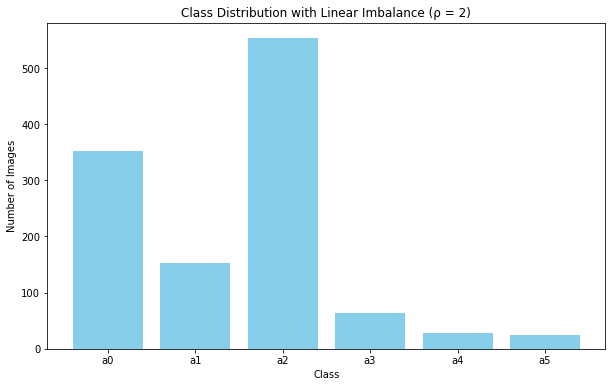

Class counts for ρ = 2:
Class a0: 352 images
Class a1: 153 images
Class a2: 553 images
Class a3: 64 images
Class a4: 29 images
Class a5: 25 images



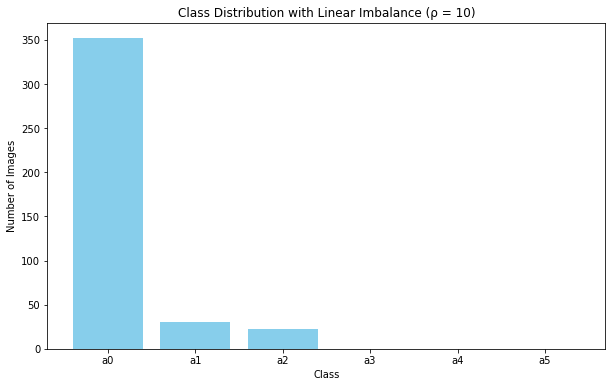

Class counts for ρ = 10:
Class a0: 352 images
Class a1: 30 images
Class a2: 22 images
Class a3: 0 images
Class a4: 0 images
Class a5: 0 images



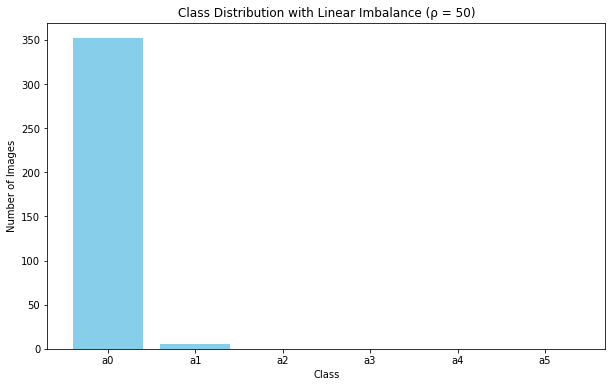

Class counts for ρ = 50:
Class a0: 352 images
Class a1: 6 images
Class a2: 0 images
Class a3: 0 images
Class a4: 0 images
Class a5: 0 images



In [2]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Define your image directory
image_dir = 'CWT_images'

# Get all image filenames from the directory
image_filenames = os.listdir(image_dir)

# Extract class information from filenames (assumes filenames like 'a0_image.png', 'a1_image.png', etc.)
def get_class_from_filename(filename):
    return filename.split('_')[0]  # Extract 'a0', 'a1', etc. from filenames like 'a0_image.png'

# Create a class count dictionary based on the images
def count_images_per_class(filenames):
    classes = [get_class_from_filename(f) for f in filenames]
    class_counts = Counter(classes)
    return class_counts

# Get the class counts for the original dataset
original_class_counts = count_images_per_class(image_filenames)

# Print the original class counts
print("Original class counts:")
for label, count in original_class_counts.items():
    print(f"Class {label}: {count} images")
print()

# Function to apply linear imbalance based on ρ
def apply_imbalance(class_counts, rho):
    imbalanced_class_counts = {}
    for i, label in enumerate(class_counts.keys()):
        # Apply the linear imbalance, reducing the number of images in each class by a factor of ρ^i
        imbalanced_class_counts[label] = class_counts[label] // (rho ** i)
    return imbalanced_class_counts

# Function to plot class distribution with respect to imbalance
def plot_imbalance(class_counts, rho):
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(f'Class Distribution with Linear Imbalance (ρ = {rho})')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

    # Print the class counts for this step of imbalance
    print(f"Class counts for ρ = {rho}:")
    for label, count in class_counts.items():
        print(f"Class {label}: {count} images")
    print()

# Apply and plot imbalance for each ρ
rhos = [2, 10, 50]

for rho in rhos:
    imbalanced_class_counts = apply_imbalance(original_class_counts, rho)
    plot_imbalance(imbalanced_class_counts, rho)


In [3]:
import os
import numpy as np
import cv2  # To load images
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define your image directory
image_dir = 'CWT_images'
image_filenames = os.listdir(image_dir)

# Extract class information from filenames (assumes filenames like 'a0_image.png', 'a1_image.png', etc.)
def get_class_from_filename(filename):
    return filename.split('_')[0]

# Load images and their corresponding labels
def load_images(image_dir, image_filenames):
    images = []
    labels = []
    
    for filename in image_filenames:
        # Load the image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        image = cv2.resize(image, (128, 128))  # Resize images to a uniform size if needed
        images.append(image)
        
        # Extract the label
        label = get_class_from_filename(filename)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# Load images and labels
images, labels = load_images(image_dir, image_filenames)

# Normalize the image data
images = images / 255.0

# Encode class labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert to one-hot encoding for classification
categorical_labels = to_categorical(encoded_labels)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'CWT_images'

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# Define Attention Mechanism
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, inputs):
        query, value = inputs, inputs
        scores = tf.matmul(query, value, transpose_b=True)
        distribution = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(distribution, value)
        return context

# Build the Bi-LSTM model
def build_bilstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    
    # Attention layer
    attention_out = Attention()(lstm_out)
    
    # Flatten and Dense Layers
    flattened = Flatten()(attention_out)
    dense_out = Dense(64, activation='relu')(flattened)
    dropout = Dropout(0.5)(dense_out)
    
    # Output Layer for classification
    outputs = Dense(num_classes, activation='softmax')(dropout)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Prepare the data for the model
input_shape = (128, 128)  # Sequence length and feature size (adjust based on your image data)
num_classes = len(np.unique(labels))

# Build and compile the model
model = build_bilstm_attention_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)

# Reshape the data if necessary to match input shape (for example, if you need to add a channel dimension)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc}")
